# Time Series Forecasting with ARIMAX, SARIMAX and PROPHET
## by Vesna Pop-Dimitrijoska
---

# Task

Forecasting AirQuality dataset with endogenious variable (target): CO(GT) and exogeneous variables: 'T' and 'NO2', using ARIMAX, SARIMAX and PROPHET. 

---
## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import tqdm 
from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns

#Time-series Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import prophet
from prophet.plot import plot_plotly, plot_components_plotly

from sklearn.model_selection import ParameterGrid

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

---
## EDA, DataPreprocessing, DataEngineering

In [2]:
df_org = pd.read_excel("AirQualityUCI.xlsx")
df = df_org.copy()
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000  0.750239  
3  11.00  60.000000  0.786713  
4  11.15  59.575001  0.788794

In [3]:
target = 'CO(GT)'
df = df[['Date', 'Time', 'T', 'NO2(GT)', target]]

In [4]:
df['ds'] = pd.to_datetime(df_org['Date'].astype(str) + " " + df_org['Time'].astype(str))
df.drop(columns=['Date','Time'], inplace=True)
df.set_index('ds', inplace=True)

In [5]:
df.head()

T  NO2(GT)  CO(GT)
ds                                         
2004-03-10 18:00:00  13.60    113.0     2.6
2004-03-10 19:00:00  13.30     92.0     2.0
2004-03-10 20:00:00  11.90    114.0     2.2
2004-03-10 21:00:00  11.00    122.0     2.2
2004-03-10 22:00:00  11.15    116.0     1.6

In [6]:
dfSummary(df)

In [7]:
print('Shape of the dataset:\n-------------------------------------------------------------')
print(f'{df.shape[0]} x {df.shape[1]}\n\n')

print('Basic info of the dataset:\n-------------------------------------------------------------')
print(df.info(), '\n\n')

print('Sum of NaN values in each column:\n-------------------------------------------------------------')
print(df.isna().sum(), '\n\n')

Shape of the dataset:
-------------------------------------------------------------
9357 x 3


Basic info of the dataset:
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T        9357 non-null   float64
 1   NO2(GT)  9357 non-null   float64
 2   CO(GT)   9357 non-null   float64
dtypes: float64(3)
memory usage: 292.4 KB
None 


Sum of NaN values in each column:
-------------------------------------------------------------
T          0
NO2(GT)    0
CO(GT)     0
dtype: int64 




In [8]:
df.describe()

T      NO2(GT)       CO(GT)
count  9357.000000  9357.000000  9357.000000
mean      9.776600    58.135898   -34.207524
std      43.203438   126.931428    77.657170
min    -200.000000  -200.000000  -200.000000
25%      10.950000    53.000000     0.600000
50%      17.200000    96.000000     1.500000
75%      24.075000   133.000000     2.600000
max      44.600000   339.700000    11.900000

---
## Handling missing values (Linear imputation in time-series)

In [9]:
# Missing values in a dataset are marked with -200

df =df.replace(-200, np.nan).reset_index()

In [10]:
print('Sum of NaN values in each column:\n----------------------------------')
print(df.isna().sum(), '\n\n')

Sum of NaN values in each column:
----------------------------------
ds            0
T           366
NO2(GT)    1642
CO(GT)     1683
dtype: int64 




In [11]:
# Aggregation of the dataset by days

df_grp = df.groupby(pd.Grouper(key='ds', freq='1D')).mean()

print('Shape of the dataset:\n-----------------------------------')
print(f'{df_grp.shape[0]} x {df_grp.shape[1]}\n\n')

Shape of the dataset:
-----------------------------------
391 x 3




In [12]:
print('Sum of NaN values in each column:\n-----------------------------------')
print(df_grp.isna().sum())

Sum of NaN values in each column:
-----------------------------------
T           8
NO2(GT)    34
CO(GT)     36
dtype: int64


In [13]:
df_grp.loc[list(df_grp.isna()[target])].shape

(36, 3)

In [14]:
# Linear imputation in time-series

gaps = {}
prev_idx = [-1, -1, -1]
next_idx = [-1, -1, -1]

for i in range(df_grp.shape[0]):
    for j in range(3):  # Iterate over columns
        if np.isnan(df_grp.iloc[i, j]):
            if prev_idx[j] == -1:
                prev_idx[j] = i
            next_idx[j] = i
        else:
            if prev_idx[j] > -1 and next_idx[j] > -1:
                gaps[(prev_idx[j], next_idx[j], next_idx[j] - prev_idx[j] + 1)] = j
                # print(df_grp.iloc[prev_idx[j] - 1, j], df_grp.iloc[next_idx[j] + 1, j], next_idx[j] - prev_idx[j] + 1)
                impute_values = np.linspace(df_grp.iloc[prev_idx[j] - 1, j], df_grp.iloc[next_idx[j] + 1, j], next_idx[j] - prev_idx[j] + 3)[1:-1]
                # print(impute_values)
                df_grp.iloc[prev_idx[j]:next_idx[j] + 1, j] = impute_values
            prev_idx[j] = -1
            next_idx[j] = -1


In [15]:
# sorted(gaps,key=lambda x: -x[-1])

In [16]:
df_grp.head()

T     NO2(GT)    CO(GT)
ds                                         
2004-03-10  12.020833  108.833333  1.966667
2004-03-11   9.833333   99.869565  2.239130
2004-03-12  11.292708  116.272727  2.804545
2004-03-13  12.866319  118.869565  2.695652
2004-03-14  16.016667  110.391304  2.469565

In [17]:
df_grp.describe()

T     NO2(GT)      CO(GT)
count  391.000000  391.000000  391.000000
mean    18.175063  110.549920    2.159142
std      7.928807   31.909220    0.863141
min      1.430208   38.043478    0.100000
25%     11.786908   89.413043    1.497826
50%     17.791320  108.217391    2.109091
75%     24.887326  129.043478    2.670290
max     32.997917  223.221739    5.650000

In [18]:
print('Sum of NaN values in each column:\n-----------------------------------')
print(df_grp.isna().sum())

Sum of NaN values in each column:
-----------------------------------
T          0
NO2(GT)    0
CO(GT)     0
dtype: int64


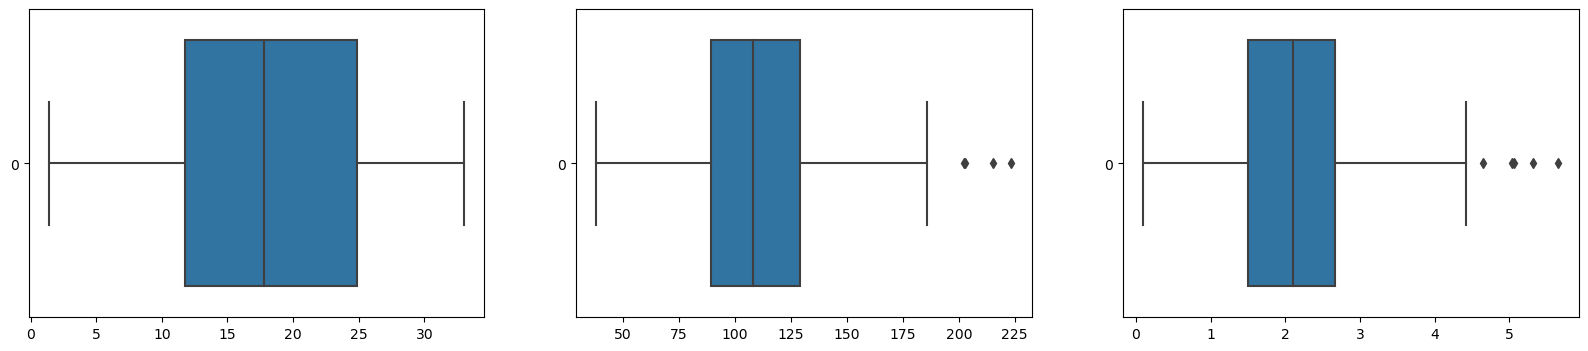

In [19]:
fig = plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(df_grp['T'], orient='h')
plt.subplot(132)
sns.boxplot(df_grp['NO2(GT)'], orient='h')
plt.subplot(133)
sns.boxplot(df_grp['CO(GT)'], orient='h')
plt.show()

Text(0.5, 1.0, 'Distribution of endogenous and exogenous time-series')

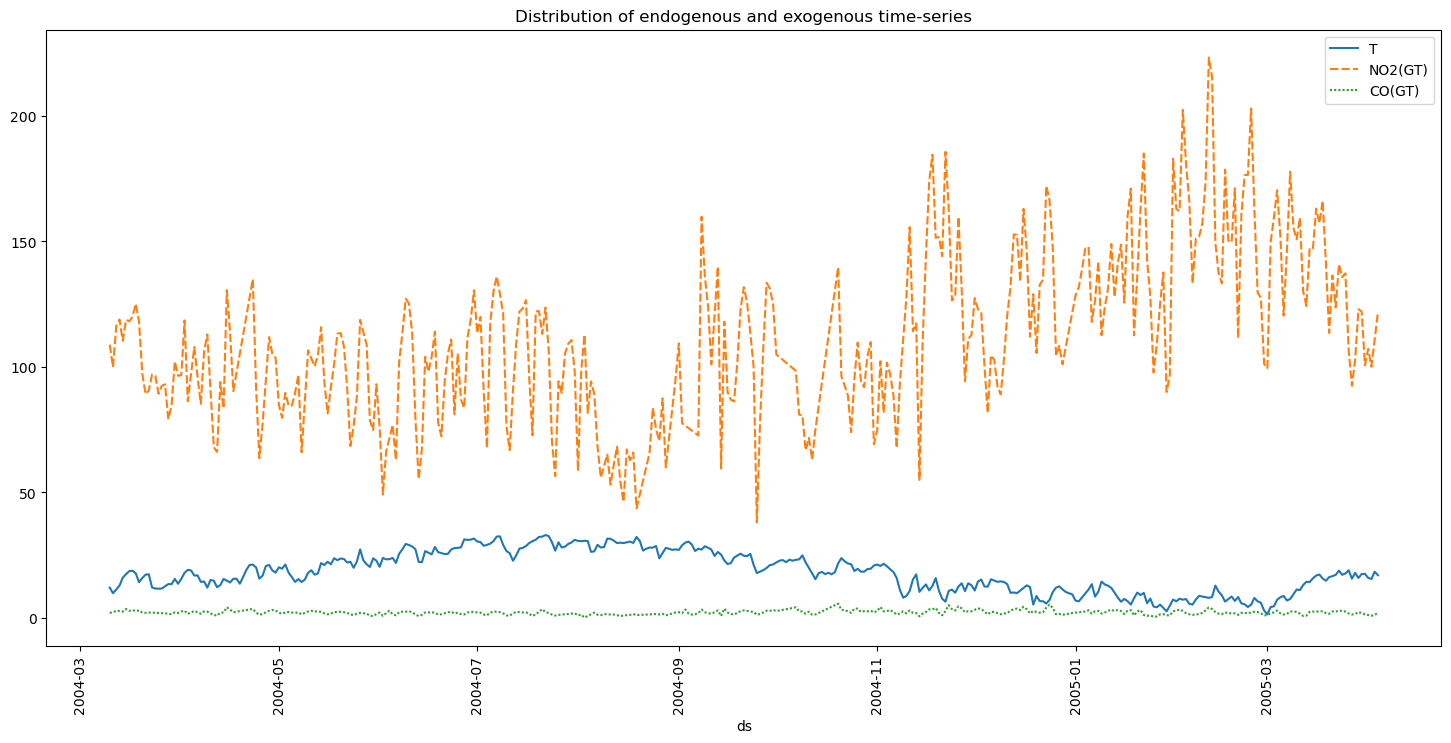

In [20]:
fig = plt.figure(figsize=(18,8))
plt.xticks(rotation=90)
sns.lineplot(df_grp)
plt.title('Distribution of endogenous and exogenous time-series')

---
## Decomposition of the endogenous variable: "CO(GT)"

In [21]:
decomp = seasonal_decompose(df_grp['CO(GT)'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid


Decomposition of the endogenous variable: "CO(GT)"


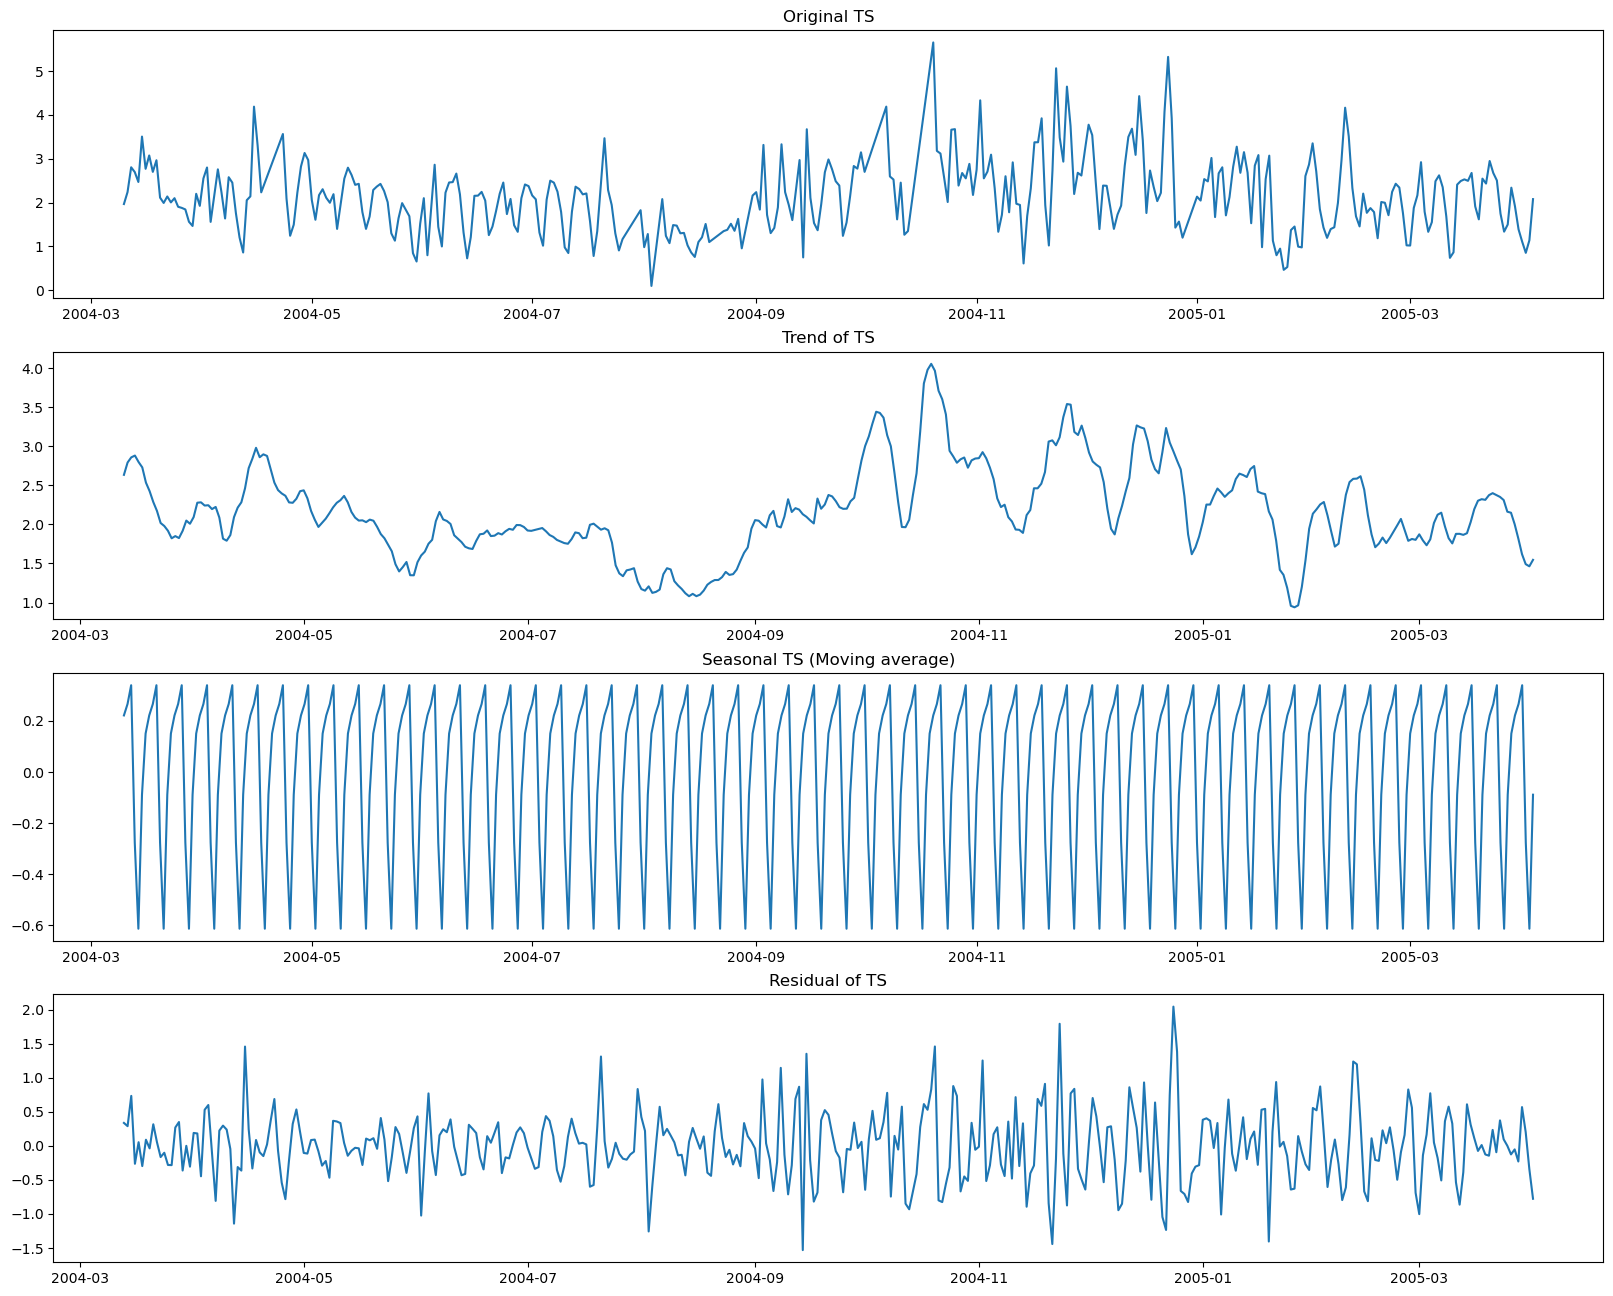

In [22]:
fig = plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df_grp['CO(GT)'])
plt.title('Original TS')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend of TS')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal TS (Moving average)')

plt.subplot(414)
plt.plot(resid)
plt.title('Residual of TS')

print('\nDecomposition of the endogenous variable: "CO(GT)"')

---
## Stationarity testing (Augmented Dickey–Fuller test) (ADFULLER)



Stationarity test for column: T


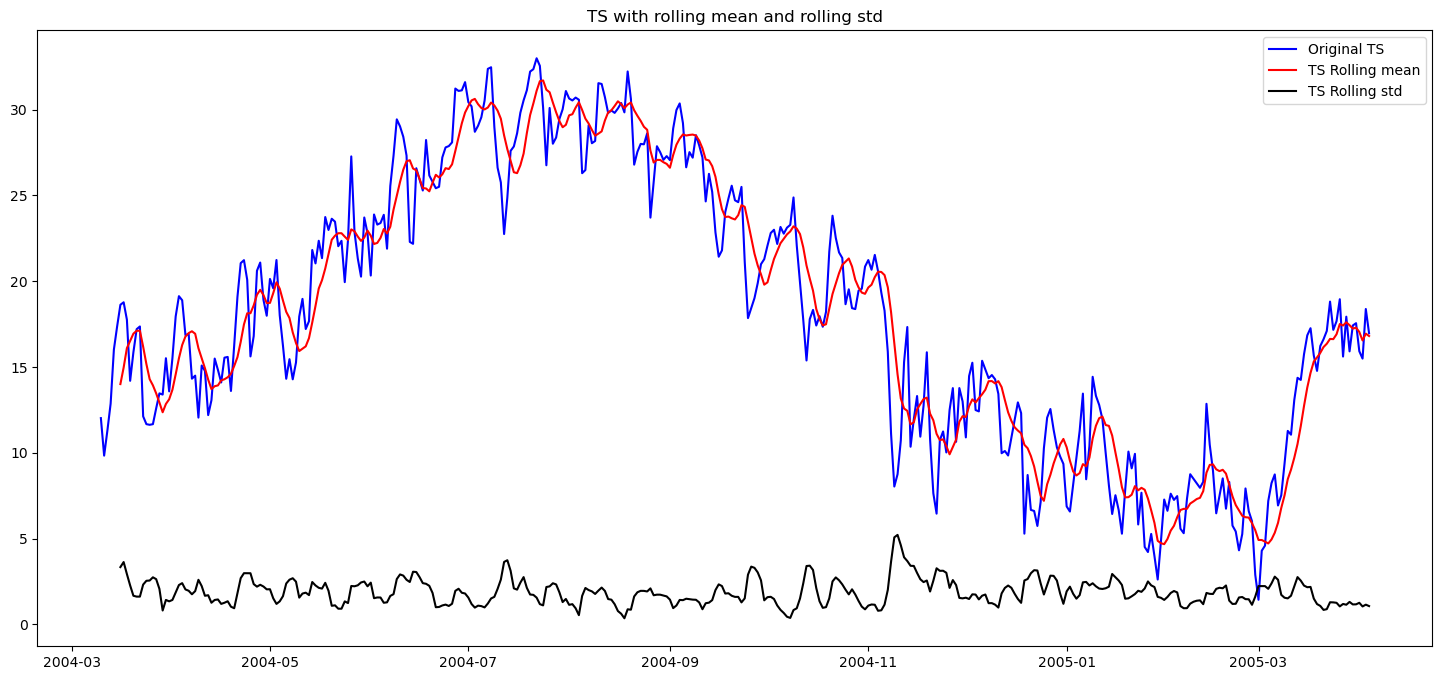

Results of the Augmented Dickey-Fuller test
Test stat.               -1.561784
p-value                   0.502757
#Lags chosen              5.000000
Total # observations    385.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.
-------------------------------------------------------------------------------------------------


Stationarity test for column: NO2(GT)


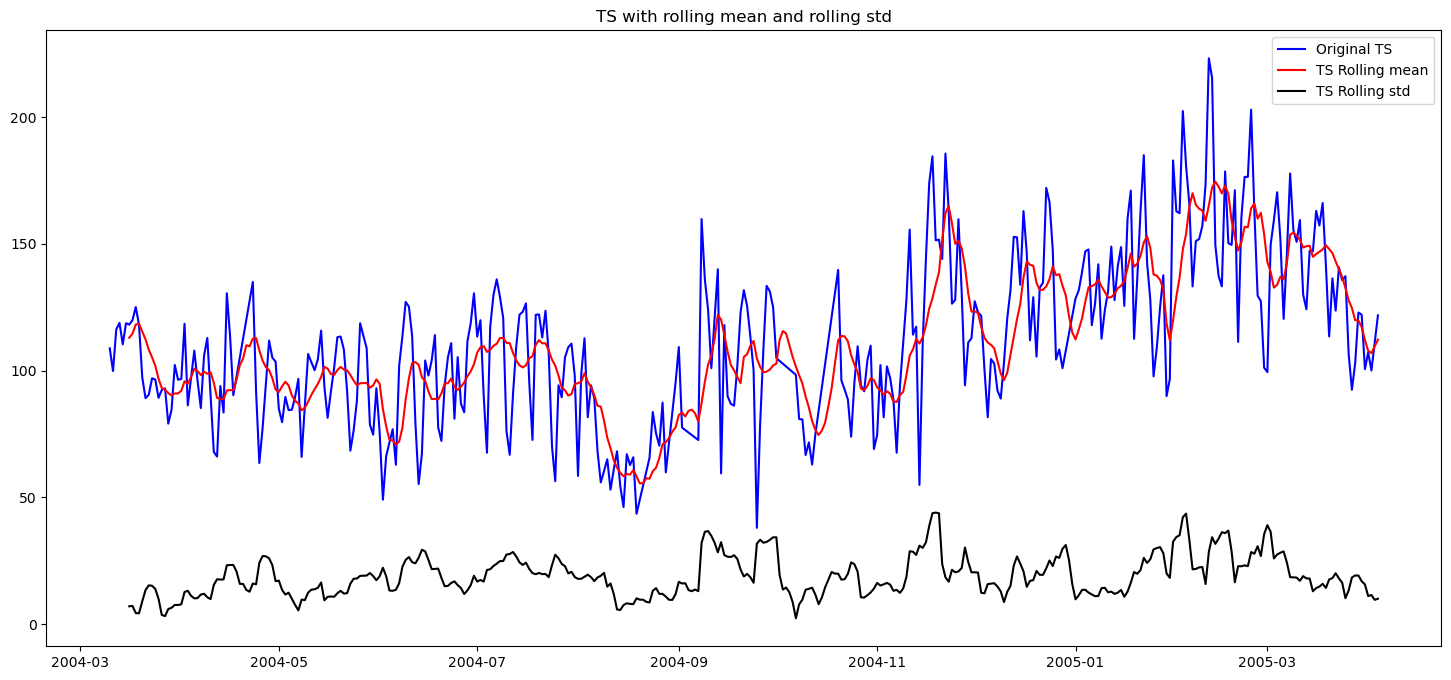

Results of the Augmented Dickey-Fuller test
Test stat.               -2.279536
p-value                   0.178653
#Lags chosen             14.000000
Total # observations    376.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.
-------------------------------------------------------------------------------------------------


Stationarity test for column: CO(GT)


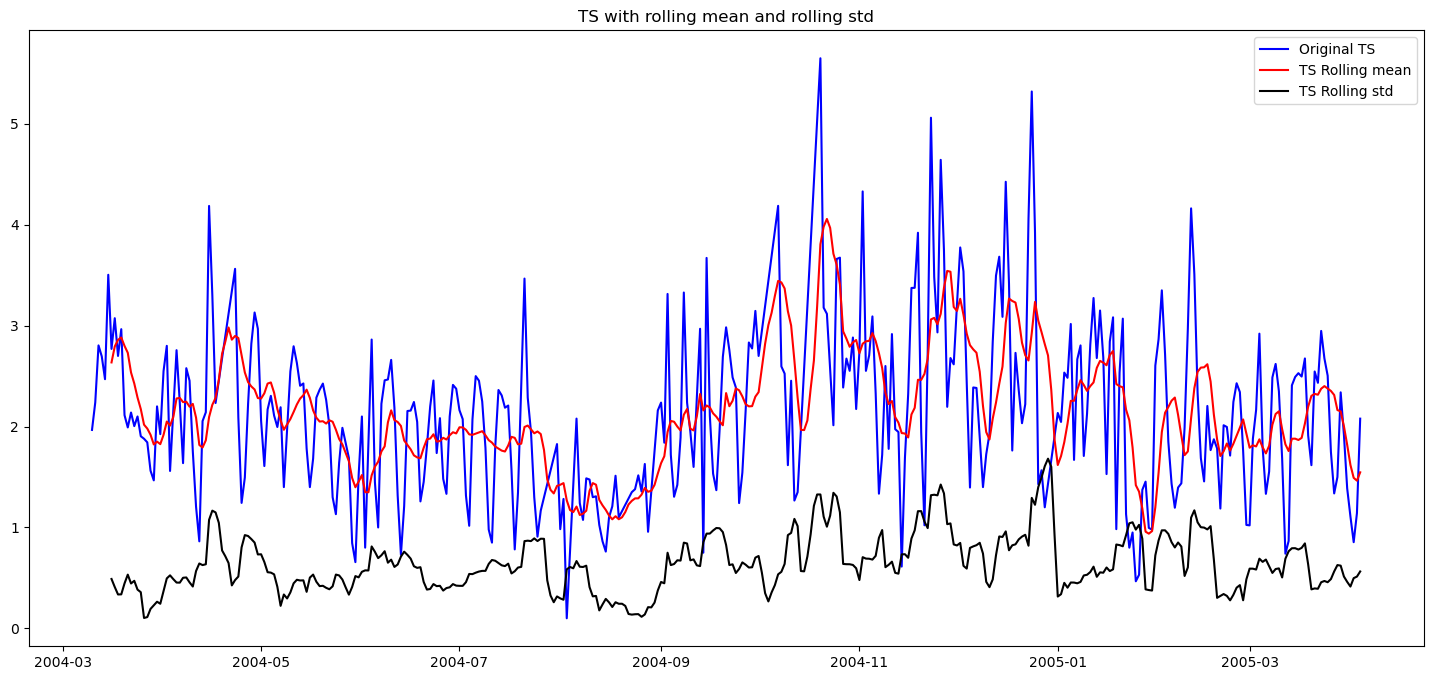

Results of the Augmented Dickey-Fuller test
Test stat.               -2.940472
p-value                   0.040840
#Lags chosen             12.000000
Total # observations    378.000000
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.
-------------------------------------------------------------------------------------------------


In [23]:
def test_stationarity(timeseries, ssn_period: int, alpha: float = 0.05):
    # calculate rolling statistics
    rol_mean = timeseries.rolling(window=ssn_period).mean()
    rol_std = timeseries.rolling(window=ssn_period).std()
    
    # plot the ts and rolling metrics
    fig = plt.figure(figsize=(18,8))
    plt.plot(timeseries, color='blue', label='Original TS')
    plt.plot(rol_mean, color='red', label='TS Rolling mean')
    plt.plot(rol_std, color='black', label='TS Rolling std')
    plt.legend(loc='best')
    plt.title("TS with rolling mean and rolling std")
    plt.show()

    print("Results of the Augmented Dickey-Fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test stat.', 'p-value', '#Lags chosen', 'Total # observations'])
    print(dfoutput)
    if dfoutput['p-value'] > alpha:
        print("Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.")
    else:
        print("Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.")
    
for i in range(3):
    print(f'\n\nStationarity test for column: {df_grp.columns[i]}')
    test_stationarity(df_grp.iloc[:, i], 7, 0.05)  
    print('-------------------------------------------------------------------------------------------------')

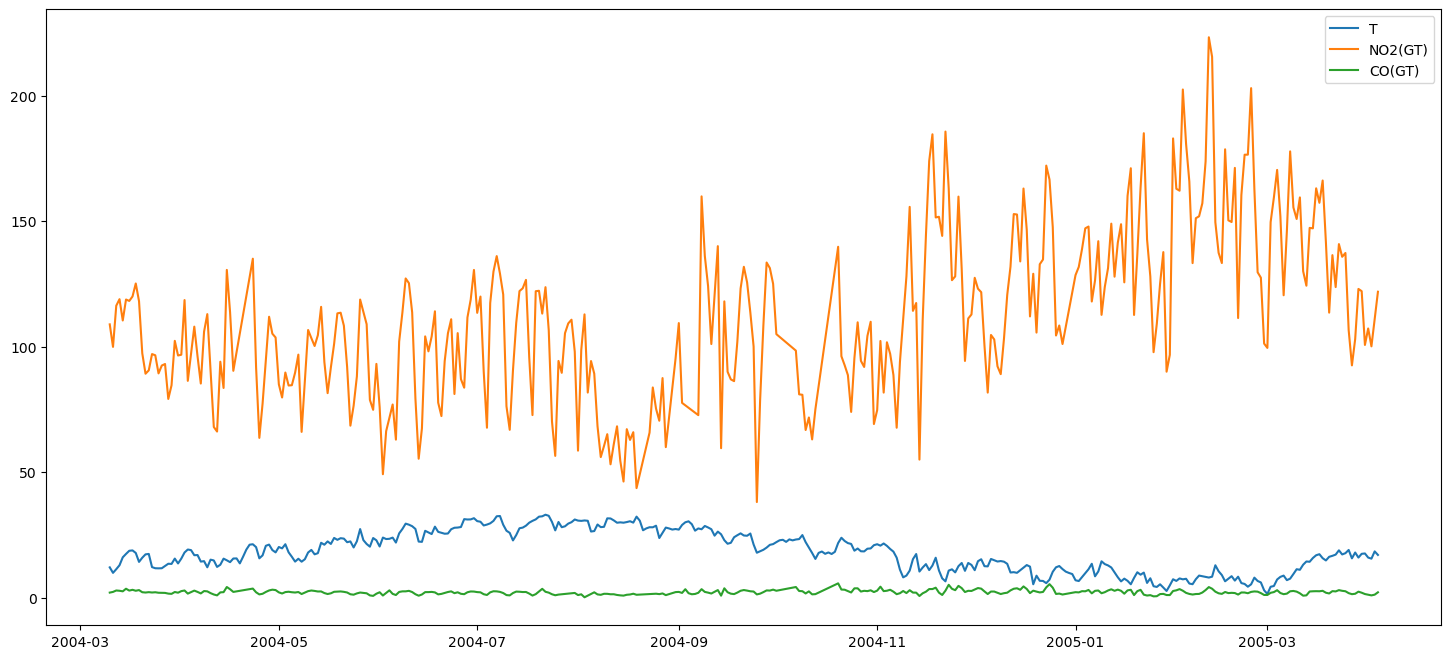

In [24]:
# Plot of all features BEFORE log function was applied

fig = plt.figure(figsize=(18,8))
plt.plot(df_grp)
plt.legend(['T', 'NO2(GT)', 'CO(GT)'])
plt.show()

## Option 1 - Without transformations

In [25]:
df_grp_log = df_grp    

## Option 2 - Log transformations on exogenous features

In [26]:
# df_grp[['T', 'NO2(GT)']] = np.log(df_grp[['T', 'NO2(GT)']])
# df_grp_log = df_grp  

## Option 3 - Log transformations on all features 

In [27]:
# df_grp_log = np.log(df_grp)

In [28]:
# # Plot of all features AFTER log function was applied

# fig = plt.figure(figsize=(18,8))
# plt.plot(df_grp_log)
# plt.legend(['T', 'NO2(GT)', 'CO(GT)'])

## Additional transformations for Stationarity

In [29]:
# # Calculationg moving average and difference between log funct and moving average in order to test the stationarity
# # ARIMA and SARIMA model is doing this automaticly, so this transformation won't be included in the model

# moving_avg = df_grp_log.rolling(window=7).mean()

# fig = plt.figure(figsize=(18,8))
# plt.plot(df_grp_log, color='blue')
# plt.plot(moving_avg, color='red')

In [30]:
# df_grp_log_moving_mean_diff = df_grp_log - moving_avg

# df_grp_log_moving_mean_diff.dropna(inplace=True)

In [31]:
# # Stationarity test after transformations

# for i in range(2):
#     test_stationarity(df_grp_log_moving_mean_diff.iloc[:, i], 7, 0.05)

---
#
# CONCLUSION from EDA, Data preprocessing and Data engineering:

---
## Handling missing values (Linear imputation in time-series)
Missing values in a dataset are marked with -200. They were replaced with NaN so that they could be imputed with linear imputation, as most appropriate technique in this type of dataset.    

## Time Series Aggregation
In order to reduce the granularity of the data, we made аggregation of the dataset by day.

## Oultiers inspection
There are no outliers in the endogenous variable from the dataset. Only few outliers not so extreme outliers in the exogenous variables.

## Decomposition of the endogenous variable

Decomposition doesn't shows specific patterns in a time series, which makes forecasting task harder.

**Trend Component**: Does not show persistent increasing or decreasing direction in the data.

**Seasonal Component**: This component captures regular patterns that occur over a period of 7 days.

**Residual Component**: This component represents the remaining random fluctuations in the data after removing the trend and seasonal components. Nothing particular can be seen at this point.      

## Stationarity test: 
Endogenous variable passed the stationarity test, while exogenous variables didn't. I tried few options listed above, but I left only the one that performed best. 

**Without transformations**: Since endogenous variable passed the stationarity test it is not necessary to transform exogenous variables. This model performed best.

**Log transformations on exogenous features**: Log transformation ONLY on exogenous variables gave me lower model performance. I wasn't sure how algorithm is working because I was transforming only exogenous variables, and I'm using enforce_stationarity=True parameter which applies to all features (log transformed and original ones). 

**Log transformations on all features**: I tried this option as well, because stationarity test will fail if critical values of stationarity test is 0.01, instead of 0.05, so it is totaly justified to transform endogenous variable together with others. This model preformed worst of all models. Probably beacuse the function has values near zero, which after log function was applied, become new outliers. So in my opinion is better not to transform endogenous variable.  

#


#
---
# Time Series Forecasting with ARIMAX, SARIMAX and PROPHET

---
## Dividing the dataset to Train and Test set: 
### Target (endogenous feature) and exogenous features 

In [32]:
split_idx = int(df_grp_log.shape[0]*0.9)
train_df = df_grp_log.iloc[:split_idx]
test_df = df_grp_log.iloc[split_idx:]

In [33]:
train_df_endog = train_df['CO(GT)']
train_df_exog = train_df[['T', 'NO2(GT)']]

test_df_endog = test_df['CO(GT)']
test_df_exog = test_df[['T', 'NO2(GT)']]

---
## Grid search over different (p, d, q) values for a ARIMAX

In [34]:
# Generate all different combinations of p, q and q triplets

p = range(0, 15)
q = range(0, 3)
d = range(0, 3)

pdq = list(itertools.product(p, d, q))

In [35]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order
    model = ARIMA(train_df_endog, 
                    exog=train_df_exog, 
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 7),
                    trend=None,
                    enforce_stationarity=False,
                    enforce_invertibility=False, 
                    freq='1D')
    
    results = model.fit()
    results = results.forecast(steps=len(test_df_endog), exog=test_df_exog)
   
    mape = mean_absolute_percentage_error(test_df_endog, results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


(p, d, q) order: (0, 0, 0), with MAPE = 45.15%
(p, d, q) order: (0, 0, 1), with MAPE = 45.23%
(p, d, q) order: (0, 0, 2), with MAPE = 46.77%
(p, d, q) order: (0, 1, 0), with MAPE = 65.22%
(p, d, q) order: (0, 1, 1), with MAPE = 50.62%
(p, d, q) order: (0, 1, 2), with MAPE = 35.38%
(p, d, q) order: (0, 2, 0), with MAPE = 424.75%
(p, d, q) order: (0, 2, 1), with MAPE = 71.77%
(p, d, q) order: (0, 2, 2), with MAPE = 58.14%
(p, d, q) order: (1, 0, 0), with MAPE = 44.12%
(p, d, q) order: (1, 0, 1), with MAPE = 40.22%
(p, d, q) order: (1, 0, 2), with MAPE = 23.78%
(p, d, q) order: (1, 1, 0), with MAPE = 62.22%
(p, d, q) order: (1, 1, 1), with MAPE = 34.21%
(p, d, q) order: (1, 1, 2), with MAPE = 34.11%
(p, d, q) order: (1, 2, 0), with MAPE = 472.95%
(p, d, q) order: (1, 2, 1), with MAPE = 70.24%
(p, d, q) order: (1, 2, 2), with MAPE = 47.12%
(p, d, q) order: (2, 0, 0), with MAPE = 42.84%
(p, d, q) order: (2, 0, 1), with MAPE = 7.142549251518186e+83%
(p, d, q) order: (2, 0, 2), with MAPE = 34

In [36]:
model = ARIMA(train_df_endog,                                         # endogenous variable
                exog=train_df_exog,                                   # exogenous variables
                order= (best_order[0], best_order[1], best_order[2]), # best parameters for the model
                seasonal_order=(0, 0, 0, 7),                          # seasonal component showing non-seasonal behavior
                trend=None,
                enforce_stationarity=False,                           # handling non-stationary data     
                enforce_invertibility=False, 
                freq='1D')

results = model.fit()
results = results.forecast(steps = len(test_df_endog), exog=test_df_exog)

In [37]:
y_test = test_df_endog
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for ARIMAX model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2))
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for ARIMAX model:
--------------------------------------
MAE:    0.36
RMSE:   0.44
R2:     48.28
MAPE:   22.8 %


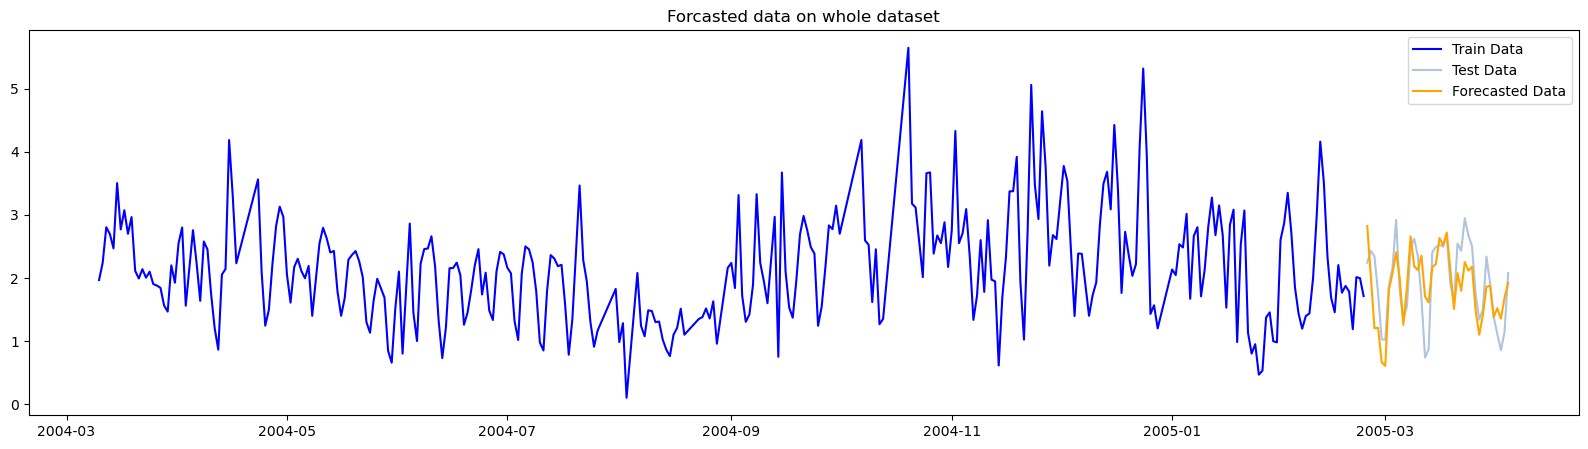

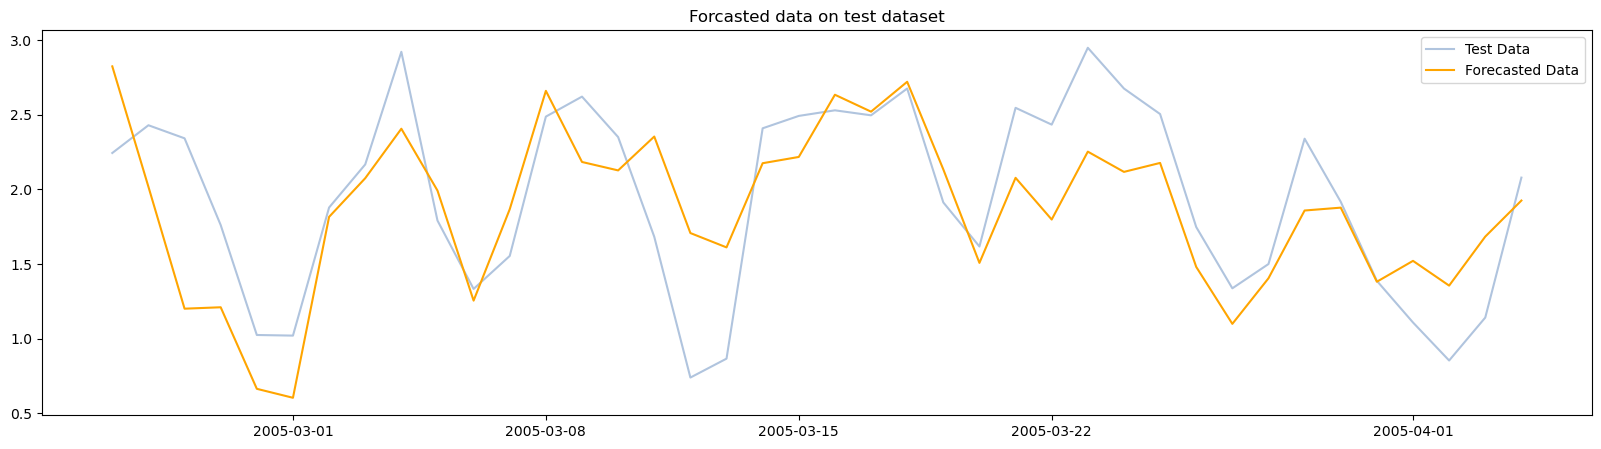

In [38]:
Train = train_df_endog
Test = test_df_endog
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset')
plt.legend()
plt.show()

---
## Grid search over different (p, d, q) values for a SARIMAX

In [39]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order
    model = SARIMAX(train_df_endog, 
                    exog=train_df_exog, 
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 7),
                    trend=None,
                    enforce_stationarity=False,
                    enforce_invertibility=False, 
                    freq='1D')
    
    
    results = model.fit()
    results = results.forecast(steps=len(test_df_endog), exog=test_df_exog)
   
    mape = mean_absolute_percentage_error(test_df_endog, results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


(p, d, q) order: (0, 0, 0), with MAPE = 44.85%
(p, d, q) order: (0, 0, 1), with MAPE = 46.37%
(p, d, q) order: (0, 0, 2), with MAPE = 49.54%
(p, d, q) order: (0, 1, 0), with MAPE = 65.22%
(p, d, q) order: (0, 1, 1), with MAPE = 50.62%
(p, d, q) order: (0, 1, 2), with MAPE = 35.38%
(p, d, q) order: (0, 2, 0), with MAPE = 424.75%
(p, d, q) order: (0, 2, 1), with MAPE = 71.77%
(p, d, q) order: (0, 2, 2), with MAPE = 58.14%
(p, d, q) order: (1, 0, 0), with MAPE = 54.82%
(p, d, q) order: (1, 0, 1), with MAPE = 53.32%
(p, d, q) order: (1, 0, 2), with MAPE = 30.97%
(p, d, q) order: (1, 1, 0), with MAPE = 62.22%
(p, d, q) order: (1, 1, 1), with MAPE = 34.21%
(p, d, q) order: (1, 1, 2), with MAPE = 34.11%
(p, d, q) order: (1, 2, 0), with MAPE = 472.95%
(p, d, q) order: (1, 2, 1), with MAPE = 70.24%
(p, d, q) order: (1, 2, 2), with MAPE = 47.12%
(p, d, q) order: (2, 0, 0), with MAPE = 54.67%
(p, d, q) order: (2, 0, 1), with MAPE = 54.61%
(p, d, q) order: (2, 0, 2), with MAPE = 34.09%
(p, d, q) o

In [40]:
model = SARIMAX(train_df_endog,                                       # endogenous variable
                exog=train_df_exog,                                   # exogenous variables
                order= (best_order[0], best_order[1], best_order[2]), # best parameters for the model
                seasonal_order=(0, 0, 0, 7),                          # seasonal component showing non-seasonal behavior
                trend=None,
                enforce_stationarity=False,                           # handling non-stationary data     
                enforce_invertibility=False)

results = model.fit()
results = results.forecast(steps = len(test_df_endog), exog=test_df_exog)

In [41]:
y_test = test_df_endog
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for SARIMAX model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2))
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for SARIMAX model:
--------------------------------------
MAE:    0.38
RMSE:   0.47
R2:     42.43
MAPE:   23.94 %


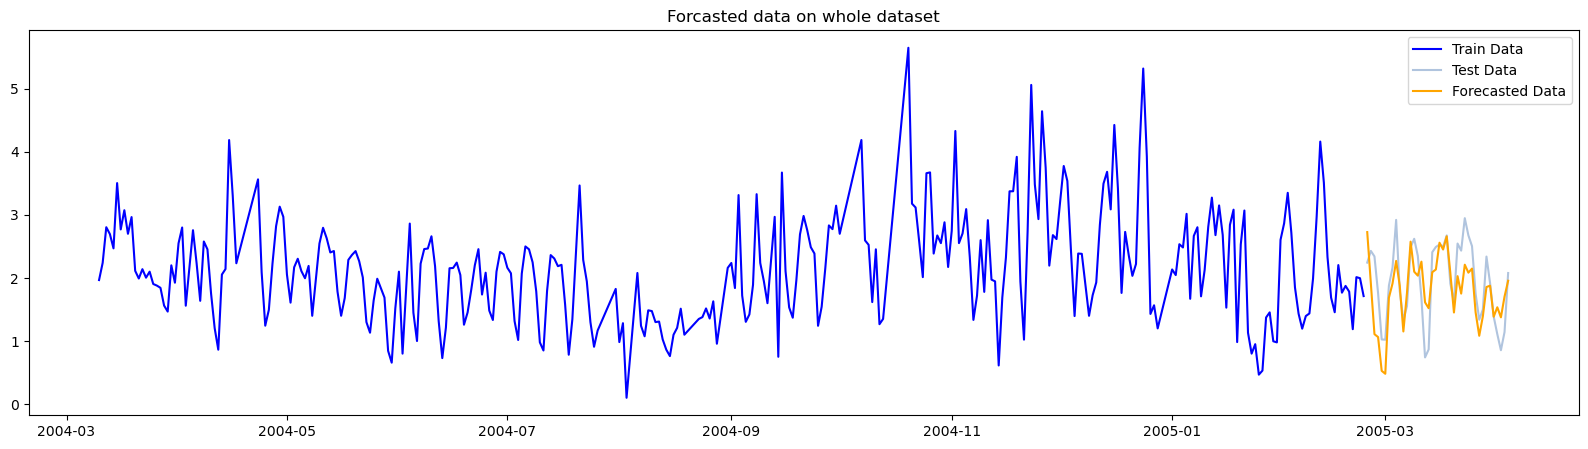

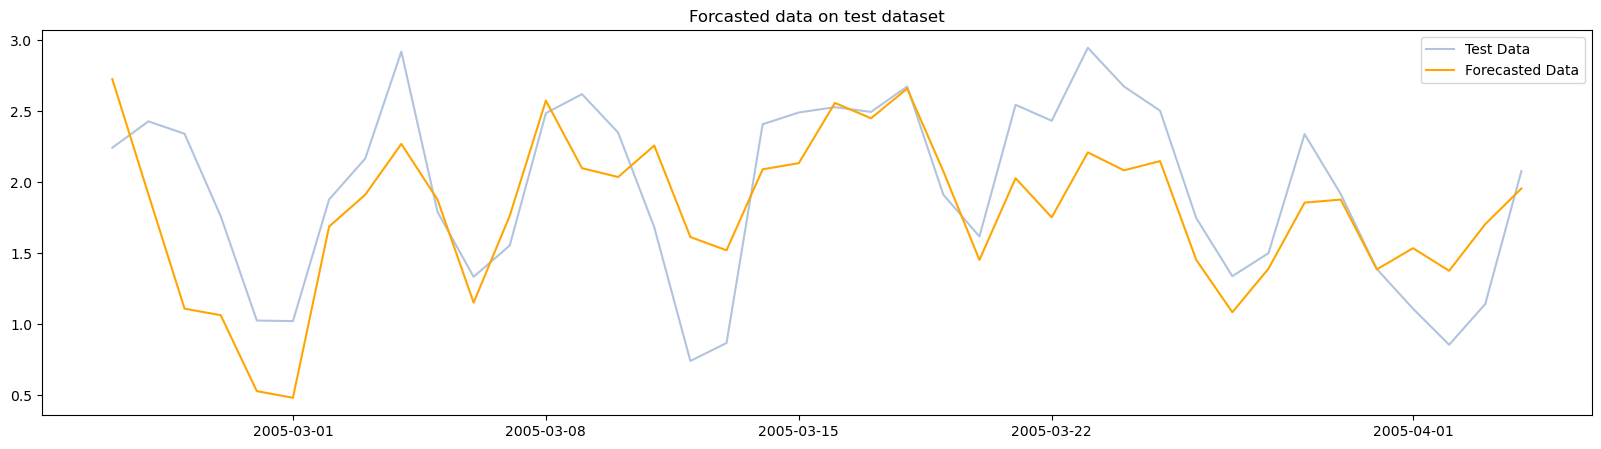

In [42]:
Train = train_df_endog
Test = test_df_endog
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset')
plt.legend()
plt.show()

#
---
## Time Series Forecasting with PROPHET

In [43]:
df = pd.read_excel("AirQualityUCI.xlsx")[['Date', 'Time', 'CO(GT)']]

In [44]:
df['ds'] = pd.to_datetime(df['Date'].astype(str) + " " + df['Time'].astype(str))
df.drop(columns=['Date','Time'], inplace=True)

In [45]:
df.rename(columns={'CO(GT)': 'y'}, inplace=True)

In [46]:
# Calculation on mean value

mean_df = df[df['y'] != -200]['y'].mean()

In [47]:
# Imputing values marked with -200 with mean value 

df = df.replace(-200, mean_df)

In [48]:
# Aggregation of the dataset by days

df_grp = df.groupby(pd.Grouper(key='ds', freq='1D')).mean().reset_index()

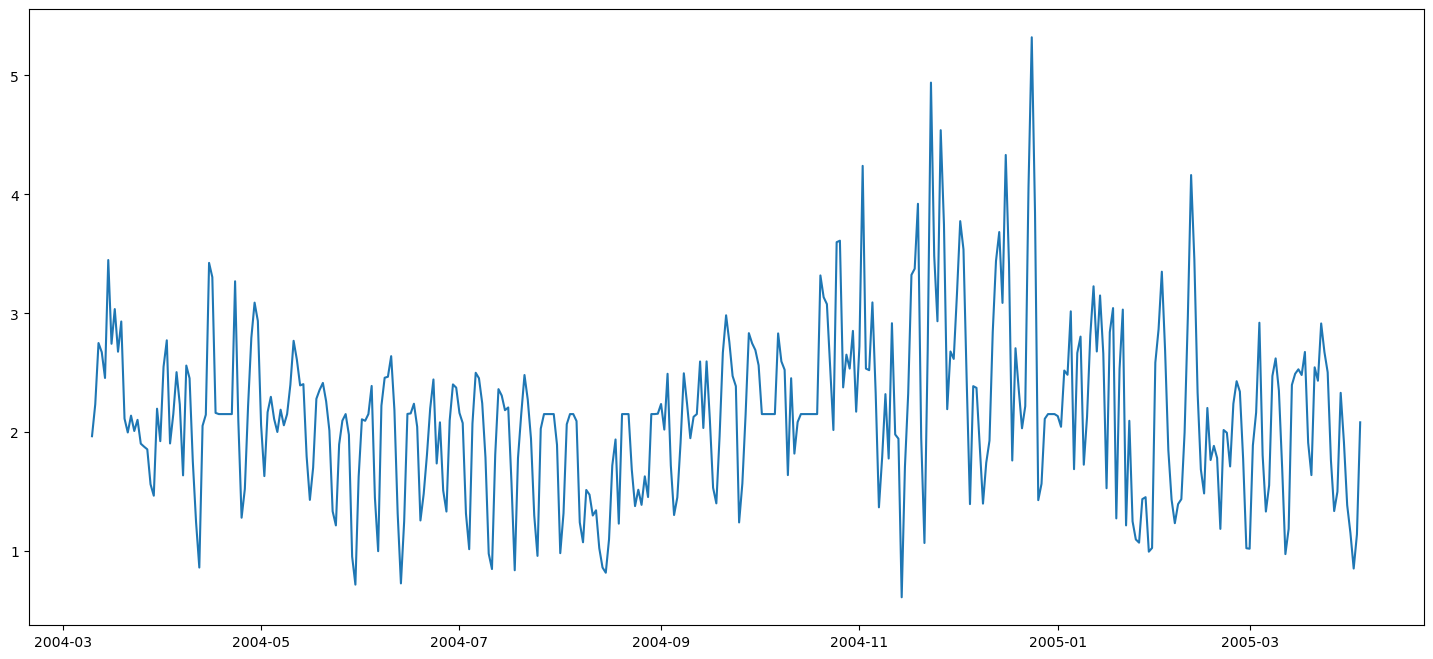

In [49]:
fig = plt.figure(figsize=(18,8))
plt.plot(df_grp[['ds']], df_grp[['y']])

In [50]:
split_idx = int(df_grp.shape[0]*0.9)
train_df = df_grp.iloc[:split_idx]
test_df = df_grp.iloc[split_idx:]

In [51]:
# Define the parameter grid
parameters = {
#     'n_changepoints': [85, 90, 95],          
#     'changepoint_range': np.arange(0.85, 0.95, 0.005)}
    'n_changepoints': [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100],          
    'changepoint_range': np.arange(0, 1, 0.005)}

parameter_grid = ParameterGrid(parameters)

best_mape = float('inf')
best_parameters = None

for param_set in parameter_grid:
    n_changepoints = param_set['n_changepoints']
    changepoint_range = param_set['changepoint_range']
    
    model = prophet.Prophet(
        growth='linear',
        changepoints=None,
        n_changepoints=n_changepoints,
        changepoint_range=changepoint_range,
        yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality='auto',
        holidays=None
    )
    
    model.fit(train_df)
    
    future = model.make_future_dataframe(periods=test_df.shape[0], freq='D')
    results = model.predict(future)
    
    mape = mean_absolute_percentage_error(test_df['y'], results['yhat'][-len(test_df['y']):])
    
    print(f'MAPE = {round(mape*100, 2)}% - n_changepoints = {n_changepoints}, changepoint_range = {changepoint_range}')
    
    if mape < best_mape:
        best_mape = mape
        best_parameters = param_set

print(f'Best parameters: {best_parameters}, MAPE = {round(best_mape*100, 2)}%')

15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.0


15:16:32 - cmdstanpy - INFO - Chain [1] start processing
15:16:32 - cmdstanpy - INFO - Chain [1] done processing
15:16:32 - cmdstanpy - INFO - Chain [1] start processing
15:16:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 5, changepoint_range = 0.0


15:16:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 10, changepoint_range = 0.0


15:16:32 - cmdstanpy - INFO - Chain [1] done processing
15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 20, changepoint_range = 0.0


15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 30, changepoint_range = 0.0


15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 40, changepoint_range = 0.0


15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 50, changepoint_range = 0.0


15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 60, changepoint_range = 0.0


15:16:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 70, changepoint_range = 0.0


15:16:34 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 80, changepoint_range = 0.0


15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 85, changepoint_range = 0.0


15:16:36 - cmdstanpy - INFO - Chain [1] start processing
15:16:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 90, changepoint_range = 0.0


15:16:36 - cmdstanpy - INFO - Chain [1] start processing
15:16:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 95, changepoint_range = 0.0


15:16:36 - cmdstanpy - INFO - Chain [1] start processing
15:16:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 100, changepoint_range = 0.0


15:16:37 - cmdstanpy - INFO - Chain [1] start processing
15:16:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.005


15:16:37 - cmdstanpy - INFO - Chain [1] start processing
15:16:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 5, changepoint_range = 0.005


15:16:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 10, changepoint_range = 0.005


15:16:37 - cmdstanpy - INFO - Chain [1] done processing
15:16:38 - cmdstanpy - INFO - Chain [1] start processing
15:16:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 20, changepoint_range = 0.005


15:16:38 - cmdstanpy - INFO - Chain [1] start processing
15:16:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 30, changepoint_range = 0.005


15:16:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 40, changepoint_range = 0.005


15:16:39 - cmdstanpy - INFO - Chain [1] done processing
15:16:39 - cmdstanpy - INFO - Chain [1] start processing
15:16:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 50, changepoint_range = 0.005


15:16:39 - cmdstanpy - INFO - Chain [1] start processing
15:16:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 60, changepoint_range = 0.005


15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 70, changepoint_range = 0.005


15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 80, changepoint_range = 0.005


15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 85, changepoint_range = 0.005


15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 90, changepoint_range = 0.005


15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 95, changepoint_range = 0.005


15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 100, changepoint_range = 0.005


15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.01


15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 5, changepoint_range = 0.01


15:16:43 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 10, changepoint_range = 0.01


15:16:43 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 20, changepoint_range = 0.01


15:16:43 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 30, changepoint_range = 0.01


15:16:44 - cmdstanpy - INFO - Chain [1] start processing
15:16:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 40, changepoint_range = 0.01


15:16:44 - cmdstanpy - INFO - Chain [1] start processing
15:16:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 50, changepoint_range = 0.01


15:16:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 60, changepoint_range = 0.01


15:16:44 - cmdstanpy - INFO - Chain [1] done processing
15:16:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 70, changepoint_range = 0.01


15:16:45 - cmdstanpy - INFO - Chain [1] done processing
15:16:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 80, changepoint_range = 0.01


15:16:45 - cmdstanpy - INFO - Chain [1] done processing
15:16:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 85, changepoint_range = 0.01


15:16:46 - cmdstanpy - INFO - Chain [1] done processing
15:16:46 - cmdstanpy - INFO - Chain [1] start processing
15:16:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 90, changepoint_range = 0.01


15:16:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 95, changepoint_range = 0.01


15:16:46 - cmdstanpy - INFO - Chain [1] done processing
15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.27% - n_changepoints = 100, changepoint_range = 0.01


15:16:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.015


15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 5, changepoint_range = 0.015


15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 10, changepoint_range = 0.015


15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 20, changepoint_range = 0.015


15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 30, changepoint_range = 0.015


15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 40, changepoint_range = 0.015


15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 50, changepoint_range = 0.015


15:16:50 - cmdstanpy - INFO - Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 60, changepoint_range = 0.015


15:16:50 - cmdstanpy - INFO - Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 70, changepoint_range = 0.015


15:16:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 80, changepoint_range = 0.015


15:16:50 - cmdstanpy - INFO - Chain [1] done processing
15:16:51 - cmdstanpy - INFO - Chain [1] start processing
15:16:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 85, changepoint_range = 0.015


15:16:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 90, changepoint_range = 0.015


15:16:51 - cmdstanpy - INFO - Chain [1] done processing
15:16:51 - cmdstanpy - INFO - Chain [1] start processing
15:16:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 95, changepoint_range = 0.015


15:16:52 - cmdstanpy - INFO - Chain [1] start processing
15:16:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 100, changepoint_range = 0.015


15:16:52 - cmdstanpy - INFO - Chain [1] start processing
15:16:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.02


15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.39% - n_changepoints = 5, changepoint_range = 0.02


15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 10, changepoint_range = 0.02


15:16:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.37% - n_changepoints = 20, changepoint_range = 0.02


15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:54 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 30, changepoint_range = 0.02


15:16:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.37% - n_changepoints = 40, changepoint_range = 0.02


15:16:54 - cmdstanpy - INFO - Chain [1] done processing
15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 50, changepoint_range = 0.02


15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 60, changepoint_range = 0.02


15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 70, changepoint_range = 0.02


15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 80, changepoint_range = 0.02


15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 85, changepoint_range = 0.02


15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 90, changepoint_range = 0.02


15:16:57 - cmdstanpy - INFO - Chain [1] start processing
15:16:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 95, changepoint_range = 0.02


15:16:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.37% - n_changepoints = 100, changepoint_range = 0.02


15:16:57 - cmdstanpy - INFO - Chain [1] done processing
15:16:57 - cmdstanpy - INFO - Chain [1] start processing
15:16:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.025


15:16:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.4% - n_changepoints = 5, changepoint_range = 0.025


15:16:58 - cmdstanpy - INFO - Chain [1] done processing
15:16:58 - cmdstanpy - INFO - Chain [1] start processing
15:16:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 10, changepoint_range = 0.025


15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 20, changepoint_range = 0.025


15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 30, changepoint_range = 0.025


15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 40, changepoint_range = 0.025


15:17:00 - cmdstanpy - INFO - Chain [1] start processing
15:17:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 50, changepoint_range = 0.025


15:17:00 - cmdstanpy - INFO - Chain [1] start processing
15:17:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 60, changepoint_range = 0.025


15:17:00 - cmdstanpy - INFO - Chain [1] start processing
15:17:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 70, changepoint_range = 0.025


15:17:01 - cmdstanpy - INFO - Chain [1] start processing
15:17:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 80, changepoint_range = 0.025


15:17:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.29% - n_changepoints = 85, changepoint_range = 0.025


15:17:01 - cmdstanpy - INFO - Chain [1] done processing
15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 90, changepoint_range = 0.025


15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 95, changepoint_range = 0.025


15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.29% - n_changepoints = 100, changepoint_range = 0.025


15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.03


15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.4% - n_changepoints = 5, changepoint_range = 0.03


15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.34% - n_changepoints = 10, changepoint_range = 0.03


15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.34% - n_changepoints = 20, changepoint_range = 0.03


15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.34% - n_changepoints = 30, changepoint_range = 0.03


15:17:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 40, changepoint_range = 0.03


15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 50, changepoint_range = 0.03


15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 60, changepoint_range = 0.03


15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 70, changepoint_range = 0.03


15:17:06 - cmdstanpy - INFO - Chain [1] done processing
15:17:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 80, changepoint_range = 0.03


15:17:06 - cmdstanpy - INFO - Chain [1] done processing
15:17:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 85, changepoint_range = 0.03


15:17:06 - cmdstanpy - INFO - Chain [1] done processing
15:17:07 - cmdstanpy - INFO - Chain [1] start processing
15:17:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.34% - n_changepoints = 90, changepoint_range = 0.03


15:17:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 95, changepoint_range = 0.03


15:17:07 - cmdstanpy - INFO - Chain [1] done processing
15:17:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.34% - n_changepoints = 100, changepoint_range = 0.03


15:17:08 - cmdstanpy - INFO - Chain [1] done processing
15:17:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.035


15:17:08 - cmdstanpy - INFO - Chain [1] done processing
15:17:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 5, changepoint_range = 0.035


15:17:08 - cmdstanpy - INFO - Chain [1] done processing
15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.0% - n_changepoints = 10, changepoint_range = 0.035


15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.17% - n_changepoints = 20, changepoint_range = 0.035


15:17:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 30, changepoint_range = 0.035


15:17:10 - cmdstanpy - INFO - Chain [1] done processing
15:17:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 40, changepoint_range = 0.035


15:17:10 - cmdstanpy - INFO - Chain [1] done processing
15:17:10 - cmdstanpy - INFO - Chain [1] start processing
15:17:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.17% - n_changepoints = 50, changepoint_range = 0.035


15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.17% - n_changepoints = 60, changepoint_range = 0.035


15:17:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 70, changepoint_range = 0.035


15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 80, changepoint_range = 0.035


15:17:12 - cmdstanpy - INFO - Chain [1] done processing
15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.17% - n_changepoints = 85, changepoint_range = 0.035


15:17:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 90, changepoint_range = 0.035


15:17:12 - cmdstanpy - INFO - Chain [1] done processing
15:17:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 95, changepoint_range = 0.035


15:17:13 - cmdstanpy - INFO - Chain [1] done processing
15:17:13 - cmdstanpy - INFO - Chain [1] start processing
15:17:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.17% - n_changepoints = 100, changepoint_range = 0.035


15:17:13 - cmdstanpy - INFO - Chain [1] start processing
15:17:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.04


15:17:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 5, changepoint_range = 0.04


15:17:14 - cmdstanpy - INFO - Chain [1] done processing
15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.2% - n_changepoints = 10, changepoint_range = 0.04


15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 20, changepoint_range = 0.04


15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 30, changepoint_range = 0.04


15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 40, changepoint_range = 0.04


15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 50, changepoint_range = 0.04


15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 60, changepoint_range = 0.04


15:17:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 70, changepoint_range = 0.04


15:17:16 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 80, changepoint_range = 0.04


15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 85, changepoint_range = 0.04


15:17:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 90, changepoint_range = 0.04


15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 95, changepoint_range = 0.04


15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 100, changepoint_range = 0.04


15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.045


15:17:19 - cmdstanpy - INFO - Chain [1] done processing
15:17:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.26% - n_changepoints = 5, changepoint_range = 0.045


15:17:19 - cmdstanpy - INFO - Chain [1] done processing
15:17:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.97% - n_changepoints = 10, changepoint_range = 0.045


15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 20, changepoint_range = 0.045


15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 30, changepoint_range = 0.045


15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 40, changepoint_range = 0.045


15:17:21 - cmdstanpy - INFO - Chain [1] done processing
15:17:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 50, changepoint_range = 0.045


15:17:21 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 60, changepoint_range = 0.045


15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 70, changepoint_range = 0.045


15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 80, changepoint_range = 0.045


15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 85, changepoint_range = 0.045


15:17:23 - cmdstanpy - INFO - Chain [1] done processing
15:17:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 90, changepoint_range = 0.045


15:17:23 - cmdstanpy - INFO - Chain [1] done processing
15:17:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 95, changepoint_range = 0.045


15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.94% - n_changepoints = 100, changepoint_range = 0.045


15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.05


15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 5, changepoint_range = 0.05


15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.14% - n_changepoints = 10, changepoint_range = 0.05


15:17:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 20, changepoint_range = 0.05


15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:26 - cmdstanpy - INFO - Chain [1] start processing
15:17:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 30, changepoint_range = 0.05


15:17:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 40, changepoint_range = 0.05


15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 50, changepoint_range = 0.05


15:17:27 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 60, changepoint_range = 0.05


15:17:27 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 70, changepoint_range = 0.05


15:17:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 80, changepoint_range = 0.05


15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 85, changepoint_range = 0.05


15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 90, changepoint_range = 0.05


15:17:29 - cmdstanpy - INFO - Chain [1] done processing
15:17:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 95, changepoint_range = 0.05


15:17:29 - cmdstanpy - INFO - Chain [1] done processing
15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.08% - n_changepoints = 100, changepoint_range = 0.05


15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.055


15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.9% - n_changepoints = 5, changepoint_range = 0.055


15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 10, changepoint_range = 0.055


15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 20, changepoint_range = 0.055


15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 30, changepoint_range = 0.055


15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 40, changepoint_range = 0.055


15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 50, changepoint_range = 0.055


15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 60, changepoint_range = 0.055


15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 70, changepoint_range = 0.055


15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 80, changepoint_range = 0.055


15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 85, changepoint_range = 0.055


15:17:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.05% - n_changepoints = 90, changepoint_range = 0.055


15:17:34 - cmdstanpy - INFO - Chain [1] done processing
15:17:34 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.05% - n_changepoints = 95, changepoint_range = 0.055


15:17:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.05% - n_changepoints = 100, changepoint_range = 0.055


15:17:35 - cmdstanpy - INFO - Chain [1] done processing
15:17:35 - cmdstanpy - INFO - Chain [1] start processing
15:17:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.06


15:17:35 - cmdstanpy - INFO - Chain [1] start processing
15:17:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 5, changepoint_range = 0.06


15:17:36 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.12% - n_changepoints = 10, changepoint_range = 0.06


15:17:36 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 20, changepoint_range = 0.06


15:17:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.92% - n_changepoints = 30, changepoint_range = 0.06


15:17:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 40, changepoint_range = 0.06


15:17:37 - cmdstanpy - INFO - Chain [1] start processing
15:17:37 - cmdstanpy - INFO - Chain [1] done processing
15:17:37 - cmdstanpy - INFO - Chain [1] start processing
15:17:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 50, changepoint_range = 0.06


15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 60, changepoint_range = 0.06


15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 70, changepoint_range = 0.06


15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 80, changepoint_range = 0.06


15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 85, changepoint_range = 0.06


15:17:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.92% - n_changepoints = 90, changepoint_range = 0.06


15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:40 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 95, changepoint_range = 0.06


15:17:40 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.92% - n_changepoints = 100, changepoint_range = 0.06


15:17:40 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.065


15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.3% - n_changepoints = 5, changepoint_range = 0.065


15:17:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.62% - n_changepoints = 10, changepoint_range = 0.065


15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.97% - n_changepoints = 20, changepoint_range = 0.065


15:17:42 - cmdstanpy - INFO - Chain [1] start processing
15:17:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 30, changepoint_range = 0.065


15:17:42 - cmdstanpy - INFO - Chain [1] start processing
15:17:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 40, changepoint_range = 0.065


15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 50, changepoint_range = 0.065


15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 60, changepoint_range = 0.065


15:17:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.93% - n_changepoints = 70, changepoint_range = 0.065


15:17:43 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.93% - n_changepoints = 80, changepoint_range = 0.065


15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 85, changepoint_range = 0.065


15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 90, changepoint_range = 0.065


15:17:45 - cmdstanpy - INFO - Chain [1] start processing
15:17:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 95, changepoint_range = 0.065


15:17:45 - cmdstanpy - INFO - Chain [1] start processing
15:17:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.93% - n_changepoints = 100, changepoint_range = 0.065


15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.07


15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.23% - n_changepoints = 5, changepoint_range = 0.07


15:17:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.98% - n_changepoints = 10, changepoint_range = 0.07


15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 20, changepoint_range = 0.07


15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 30, changepoint_range = 0.07


15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 40, changepoint_range = 0.07


15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 50, changepoint_range = 0.07


15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 60, changepoint_range = 0.07


15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 70, changepoint_range = 0.07


15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 80, changepoint_range = 0.07


15:17:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.84% - n_changepoints = 85, changepoint_range = 0.07


15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 90, changepoint_range = 0.07


15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 95, changepoint_range = 0.07


15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 100, changepoint_range = 0.07


15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.075


15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.96% - n_changepoints = 5, changepoint_range = 0.075


15:17:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.03% - n_changepoints = 10, changepoint_range = 0.075


15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.13% - n_changepoints = 20, changepoint_range = 0.075


15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 30, changepoint_range = 0.075


15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 40, changepoint_range = 0.075


15:17:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.07% - n_changepoints = 50, changepoint_range = 0.075


15:17:53 - cmdstanpy - INFO - Chain [1] done processing
15:17:53 - cmdstanpy - INFO - Chain [1] start processing
15:17:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 60, changepoint_range = 0.075


15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 70, changepoint_range = 0.075


15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 80, changepoint_range = 0.075


15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 85, changepoint_range = 0.075


15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 90, changepoint_range = 0.075


15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 95, changepoint_range = 0.075


15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.07% - n_changepoints = 100, changepoint_range = 0.075


15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.08


15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 5, changepoint_range = 0.08


15:17:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.85% - n_changepoints = 10, changepoint_range = 0.08


15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:57 - cmdstanpy - INFO - Chain [1] start processing
15:17:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.24% - n_changepoints = 20, changepoint_range = 0.08


15:17:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 30, changepoint_range = 0.08


15:17:57 - cmdstanpy - INFO - Chain [1] done processing
15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 40, changepoint_range = 0.08


15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 50, changepoint_range = 0.08


15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 60, changepoint_range = 0.08


15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 70, changepoint_range = 0.08


15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 80, changepoint_range = 0.08


15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 85, changepoint_range = 0.08


15:18:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 90, changepoint_range = 0.08


15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 95, changepoint_range = 0.08


15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.18% - n_changepoints = 100, changepoint_range = 0.08


15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.085


15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.23% - n_changepoints = 5, changepoint_range = 0.085


15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.83% - n_changepoints = 10, changepoint_range = 0.085


15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.1% - n_changepoints = 20, changepoint_range = 0.085


15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 30, changepoint_range = 0.085


15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 40, changepoint_range = 0.085


15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 50, changepoint_range = 0.085


15:18:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.84% - n_changepoints = 60, changepoint_range = 0.085


15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 70, changepoint_range = 0.085


15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 80, changepoint_range = 0.085


15:18:05 - cmdstanpy - INFO - Chain [1] start processing
15:18:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.84% - n_changepoints = 85, changepoint_range = 0.085


15:18:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.84% - n_changepoints = 90, changepoint_range = 0.085


15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.84% - n_changepoints = 95, changepoint_range = 0.085


15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.84% - n_changepoints = 100, changepoint_range = 0.085


15:18:06 - cmdstanpy - INFO - Chain [1] done processing
15:18:06 - cmdstanpy - INFO - Chain [1] start processing
15:18:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.09


15:18:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 5, changepoint_range = 0.09


15:18:06 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.2% - n_changepoints = 10, changepoint_range = 0.09


15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.82% - n_changepoints = 20, changepoint_range = 0.09


15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 30, changepoint_range = 0.09


15:18:08 - cmdstanpy - INFO - Chain [1] done processing
15:18:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 40, changepoint_range = 0.09


15:18:08 - cmdstanpy - INFO - Chain [1] done processing
15:18:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 50, changepoint_range = 0.09


15:18:08 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 60, changepoint_range = 0.09


15:18:09 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing
15:18:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.04% - n_changepoints = 70, changepoint_range = 0.09


15:18:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 80, changepoint_range = 0.09


15:18:09 - cmdstanpy - INFO - Chain [1] done processing
15:18:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 85, changepoint_range = 0.09


15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 90, changepoint_range = 0.09


15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 95, changepoint_range = 0.09


15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 100, changepoint_range = 0.09


15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.095


15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 5, changepoint_range = 0.095


15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.88% - n_changepoints = 10, changepoint_range = 0.095


15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.29% - n_changepoints = 20, changepoint_range = 0.095


15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.86% - n_changepoints = 30, changepoint_range = 0.095


15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 40, changepoint_range = 0.095


15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 50, changepoint_range = 0.095


15:18:14 - cmdstanpy - INFO - Chain [1] done processing
15:18:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 60, changepoint_range = 0.095


15:18:14 - cmdstanpy - INFO - Chain [1] done processing
15:18:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 70, changepoint_range = 0.095


15:18:15 - cmdstanpy - INFO - Chain [1] done processing
15:18:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 80, changepoint_range = 0.095


15:18:15 - cmdstanpy - INFO - Chain [1] done processing
15:18:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 85, changepoint_range = 0.095


15:18:15 - cmdstanpy - INFO - Chain [1] done processing
15:18:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 90, changepoint_range = 0.095


15:18:16 - cmdstanpy - INFO - Chain [1] done processing
15:18:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 95, changepoint_range = 0.095


15:18:16 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.95% - n_changepoints = 100, changepoint_range = 0.095


15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.1


15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.63% - n_changepoints = 5, changepoint_range = 0.1


15:18:17 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.0% - n_changepoints = 10, changepoint_range = 0.1


15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 20, changepoint_range = 0.1


15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.05% - n_changepoints = 30, changepoint_range = 0.1


15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.67% - n_changepoints = 40, changepoint_range = 0.1


15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.67% - n_changepoints = 50, changepoint_range = 0.1


15:18:20 - cmdstanpy - INFO - Chain [1] start processing
15:18:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.67% - n_changepoints = 60, changepoint_range = 0.1


15:18:20 - cmdstanpy - INFO - Chain [1] start processing
15:18:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.67% - n_changepoints = 70, changepoint_range = 0.1


15:18:20 - cmdstanpy - INFO - Chain [1] start processing
15:18:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.67% - n_changepoints = 80, changepoint_range = 0.1


15:18:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.67% - n_changepoints = 85, changepoint_range = 0.1


15:18:21 - cmdstanpy - INFO - Chain [1] done processing
15:18:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.67% - n_changepoints = 90, changepoint_range = 0.1


15:18:21 - cmdstanpy - INFO - Chain [1] done processing
15:18:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.67% - n_changepoints = 95, changepoint_range = 0.1


15:18:22 - cmdstanpy - INFO - Chain [1] done processing
15:18:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.67% - n_changepoints = 100, changepoint_range = 0.1


15:18:22 - cmdstanpy - INFO - Chain [1] done processing
15:18:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.105


15:18:22 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 5, changepoint_range = 0.105


15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.0% - n_changepoints = 10, changepoint_range = 0.105


15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.79% - n_changepoints = 20, changepoint_range = 0.105


15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.0% - n_changepoints = 30, changepoint_range = 0.105


15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 40, changepoint_range = 0.105


15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 50, changepoint_range = 0.105


15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.14% - n_changepoints = 60, changepoint_range = 0.105


15:18:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 70, changepoint_range = 0.105


15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 80, changepoint_range = 0.105


15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 85, changepoint_range = 0.105


15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 90, changepoint_range = 0.105


15:18:27 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 95, changepoint_range = 0.105


15:18:27 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.14% - n_changepoints = 100, changepoint_range = 0.105


15:18:27 - cmdstanpy - INFO - Chain [1] done processing
15:18:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.11


15:18:28 - cmdstanpy - INFO - Chain [1] done processing
15:18:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.21% - n_changepoints = 5, changepoint_range = 0.11


15:18:28 - cmdstanpy - INFO - Chain [1] done processing
15:18:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 10, changepoint_range = 0.11


15:18:29 - cmdstanpy - INFO - Chain [1] done processing
15:18:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.98% - n_changepoints = 20, changepoint_range = 0.11


15:18:29 - cmdstanpy - INFO - Chain [1] done processing
15:18:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 30, changepoint_range = 0.11


15:18:29 - cmdstanpy - INFO - Chain [1] done processing
15:18:30 - cmdstanpy - INFO - Chain [1] start processing
15:18:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 40, changepoint_range = 0.11


15:18:30 - cmdstanpy - INFO - Chain [1] start processing
15:18:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 50, changepoint_range = 0.11


15:18:30 - cmdstanpy - INFO - Chain [1] start processing
15:18:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 60, changepoint_range = 0.11


15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 70, changepoint_range = 0.11


15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 80, changepoint_range = 0.11


15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 85, changepoint_range = 0.11


15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 90, changepoint_range = 0.11


15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 95, changepoint_range = 0.11


15:18:33 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 100, changepoint_range = 0.11


15:18:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.115


15:18:33 - cmdstanpy - INFO - Chain [1] done processing
15:18:33 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.82% - n_changepoints = 5, changepoint_range = 0.115


15:18:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 10, changepoint_range = 0.115


15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.69% - n_changepoints = 20, changepoint_range = 0.115


15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.99% - n_changepoints = 30, changepoint_range = 0.115


15:18:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.86% - n_changepoints = 40, changepoint_range = 0.115


15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.86% - n_changepoints = 50, changepoint_range = 0.115


15:18:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.86% - n_changepoints = 60, changepoint_range = 0.115


15:18:36 - cmdstanpy - INFO - Chain [1] done processing
15:18:36 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.86% - n_changepoints = 70, changepoint_range = 0.115


15:18:36 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.86% - n_changepoints = 80, changepoint_range = 0.115


15:18:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.86% - n_changepoints = 85, changepoint_range = 0.115


15:18:37 - cmdstanpy - INFO - Chain [1] done processing
15:18:37 - cmdstanpy - INFO - Chain [1] start processing
15:18:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.86% - n_changepoints = 90, changepoint_range = 0.115


15:18:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.86% - n_changepoints = 95, changepoint_range = 0.115


15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.86% - n_changepoints = 100, changepoint_range = 0.115


15:18:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.12


15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 5, changepoint_range = 0.12


15:18:39 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.76% - n_changepoints = 10, changepoint_range = 0.12


15:18:39 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.13% - n_changepoints = 20, changepoint_range = 0.12


15:18:39 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.93% - n_changepoints = 30, changepoint_range = 0.12


15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.07% - n_changepoints = 40, changepoint_range = 0.12


15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 50, changepoint_range = 0.12


15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 60, changepoint_range = 0.12


15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing
15:18:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.96% - n_changepoints = 70, changepoint_range = 0.12


15:18:42 - cmdstanpy - INFO - Chain [1] start processing
15:18:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.96% - n_changepoints = 80, changepoint_range = 0.12


15:18:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 85, changepoint_range = 0.12


15:18:42 - cmdstanpy - INFO - Chain [1] done processing
15:18:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 90, changepoint_range = 0.12


15:18:42 - cmdstanpy - INFO - Chain [1] done processing
15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.96% - n_changepoints = 95, changepoint_range = 0.12


15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.96% - n_changepoints = 100, changepoint_range = 0.12


15:18:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.125


15:18:44 - cmdstanpy - INFO - Chain [1] done processing
15:18:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.32% - n_changepoints = 5, changepoint_range = 0.125


15:18:44 - cmdstanpy - INFO - Chain [1] done processing
15:18:44 - cmdstanpy - INFO - Chain [1] start processing
15:18:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.38% - n_changepoints = 10, changepoint_range = 0.125


15:18:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.51% - n_changepoints = 20, changepoint_range = 0.125


15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 30, changepoint_range = 0.125


15:18:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.82% - n_changepoints = 40, changepoint_range = 0.125


15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.98% - n_changepoints = 50, changepoint_range = 0.125


15:18:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.98% - n_changepoints = 60, changepoint_range = 0.125


15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.98% - n_changepoints = 70, changepoint_range = 0.125


15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.98% - n_changepoints = 80, changepoint_range = 0.125


15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.98% - n_changepoints = 85, changepoint_range = 0.125


15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.98% - n_changepoints = 90, changepoint_range = 0.125


15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.98% - n_changepoints = 95, changepoint_range = 0.125


15:18:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.98% - n_changepoints = 100, changepoint_range = 0.125


15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.13


15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.79% - n_changepoints = 5, changepoint_range = 0.13


15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:50 - cmdstanpy - INFO - Chain [1] start processing
15:18:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.06% - n_changepoints = 10, changepoint_range = 0.13


15:18:50 - cmdstanpy - INFO - Chain [1] start processing
15:18:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.12% - n_changepoints = 20, changepoint_range = 0.13


15:18:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.9% - n_changepoints = 30, changepoint_range = 0.13


15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.05% - n_changepoints = 40, changepoint_range = 0.13


15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.01% - n_changepoints = 50, changepoint_range = 0.13


15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.01% - n_changepoints = 60, changepoint_range = 0.13


15:18:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.01% - n_changepoints = 70, changepoint_range = 0.13


15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.01% - n_changepoints = 80, changepoint_range = 0.13


15:18:53 - cmdstanpy - INFO - Chain [1] start processing
15:18:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.01% - n_changepoints = 85, changepoint_range = 0.13


15:18:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.01% - n_changepoints = 90, changepoint_range = 0.13


15:18:53 - cmdstanpy - INFO - Chain [1] done processing
15:18:54 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.01% - n_changepoints = 95, changepoint_range = 0.13


15:18:54 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.01% - n_changepoints = 100, changepoint_range = 0.13


15:18:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.135


15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.43% - n_changepoints = 5, changepoint_range = 0.135


15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 10, changepoint_range = 0.135


15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.97% - n_changepoints = 20, changepoint_range = 0.135


15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.99% - n_changepoints = 30, changepoint_range = 0.135


15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.25% - n_changepoints = 40, changepoint_range = 0.135


15:18:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.02% - n_changepoints = 50, changepoint_range = 0.135


15:18:57 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 60, changepoint_range = 0.135


15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 70, changepoint_range = 0.135


15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 80, changepoint_range = 0.135


15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 85, changepoint_range = 0.135


15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 90, changepoint_range = 0.135


15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 95, changepoint_range = 0.135


15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.02% - n_changepoints = 100, changepoint_range = 0.135


15:19:00 - cmdstanpy - INFO - Chain [1] start processing
15:19:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.14


15:19:00 - cmdstanpy - INFO - Chain [1] start processing
15:19:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.34% - n_changepoints = 5, changepoint_range = 0.14


15:19:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.06% - n_changepoints = 10, changepoint_range = 0.14


15:19:01 - cmdstanpy - INFO - Chain [1] done processing
15:19:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.87% - n_changepoints = 20, changepoint_range = 0.14


15:19:01 - cmdstanpy - INFO - Chain [1] done processing
15:19:01 - cmdstanpy - INFO - Chain [1] start processing
15:19:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.14% - n_changepoints = 30, changepoint_range = 0.14


15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.16% - n_changepoints = 40, changepoint_range = 0.14


15:19:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 50, changepoint_range = 0.14


15:19:02 - cmdstanpy - INFO - Chain [1] done processing
15:19:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 60, changepoint_range = 0.14


15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.89% - n_changepoints = 70, changepoint_range = 0.14


15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.89% - n_changepoints = 80, changepoint_range = 0.14


15:19:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 85, changepoint_range = 0.14


15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 90, changepoint_range = 0.14


15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 95, changepoint_range = 0.14


15:19:05 - cmdstanpy - INFO - Chain [1] done processing
15:19:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.89% - n_changepoints = 100, changepoint_range = 0.14


15:19:05 - cmdstanpy - INFO - Chain [1] done processing
15:19:05 - cmdstanpy - INFO - Chain [1] start processing
15:19:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.145


15:19:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.51% - n_changepoints = 5, changepoint_range = 0.145


15:19:06 - cmdstanpy - INFO - Chain [1] done processing
15:19:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.08% - n_changepoints = 10, changepoint_range = 0.145


15:19:06 - cmdstanpy - INFO - Chain [1] done processing
15:19:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.06% - n_changepoints = 20, changepoint_range = 0.145


15:19:06 - cmdstanpy - INFO - Chain [1] done processing
15:19:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.05% - n_changepoints = 30, changepoint_range = 0.145


15:19:07 - cmdstanpy - INFO - Chain [1] done processing
15:19:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.92% - n_changepoints = 40, changepoint_range = 0.145


15:19:07 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 50, changepoint_range = 0.145


15:19:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 60, changepoint_range = 0.145


15:19:08 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 70, changepoint_range = 0.145


15:19:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 80, changepoint_range = 0.145


15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 85, changepoint_range = 0.145


15:19:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 90, changepoint_range = 0.145


15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 95, changepoint_range = 0.145


15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 100, changepoint_range = 0.145


15:19:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.15


15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.12% - n_changepoints = 5, changepoint_range = 0.15


15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.27% - n_changepoints = 10, changepoint_range = 0.15


15:19:12 - cmdstanpy - INFO - Chain [1] done processing
15:19:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.06% - n_changepoints = 20, changepoint_range = 0.15


15:19:12 - cmdstanpy - INFO - Chain [1] done processing
15:19:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 30, changepoint_range = 0.15


15:19:12 - cmdstanpy - INFO - Chain [1] done processing
15:19:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.04% - n_changepoints = 40, changepoint_range = 0.15


15:19:13 - cmdstanpy - INFO - Chain [1] done processing
15:19:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.19% - n_changepoints = 50, changepoint_range = 0.15


15:19:13 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 60, changepoint_range = 0.15


15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 70, changepoint_range = 0.15


15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 80, changepoint_range = 0.15


15:19:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 85, changepoint_range = 0.15


15:19:15 - cmdstanpy - INFO - Chain [1] done processing
15:19:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 90, changepoint_range = 0.15


15:19:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 95, changepoint_range = 0.15


15:19:16 - cmdstanpy - INFO - Chain [1] start processing
15:19:16 - cmdstanpy - INFO - Chain [1] done processing
15:19:16 - cmdstanpy - INFO - Chain [1] start processing
15:19:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.15% - n_changepoints = 100, changepoint_range = 0.15


15:19:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.155


15:19:16 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.23% - n_changepoints = 5, changepoint_range = 0.155


15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.03% - n_changepoints = 10, changepoint_range = 0.155


15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.29% - n_changepoints = 20, changepoint_range = 0.155


15:19:18 - cmdstanpy - INFO - Chain [1] done processing
15:19:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.1% - n_changepoints = 30, changepoint_range = 0.155


15:19:18 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.06% - n_changepoints = 40, changepoint_range = 0.155


15:19:19 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.16% - n_changepoints = 50, changepoint_range = 0.155


15:19:19 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 60, changepoint_range = 0.155


15:19:19 - cmdstanpy - INFO - Chain [1] done processing
15:19:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 70, changepoint_range = 0.155


15:19:20 - cmdstanpy - INFO - Chain [1] done processing
15:19:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 80, changepoint_range = 0.155


15:19:20 - cmdstanpy - INFO - Chain [1] done processing
15:19:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 85, changepoint_range = 0.155


15:19:21 - cmdstanpy - INFO - Chain [1] done processing
15:19:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 90, changepoint_range = 0.155


15:19:21 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 95, changepoint_range = 0.155


15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.11% - n_changepoints = 100, changepoint_range = 0.155


15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.16


15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.45% - n_changepoints = 5, changepoint_range = 0.16


15:19:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 10, changepoint_range = 0.16


15:19:23 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.23% - n_changepoints = 20, changepoint_range = 0.16


15:19:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.2% - n_changepoints = 30, changepoint_range = 0.16


15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.47% - n_changepoints = 40, changepoint_range = 0.16


15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.33% - n_changepoints = 50, changepoint_range = 0.16


15:19:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 60, changepoint_range = 0.16


15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 70, changepoint_range = 0.16


15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 80, changepoint_range = 0.16


15:19:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 85, changepoint_range = 0.16


15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 90, changepoint_range = 0.16


15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 95, changepoint_range = 0.16


15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 100, changepoint_range = 0.16


15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.165


15:19:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.15% - n_changepoints = 5, changepoint_range = 0.165


15:19:28 - cmdstanpy - INFO - Chain [1] done processing
15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.21% - n_changepoints = 10, changepoint_range = 0.165


15:19:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.25% - n_changepoints = 20, changepoint_range = 0.165


15:19:29 - cmdstanpy - INFO - Chain [1] done processing
15:19:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.17% - n_changepoints = 30, changepoint_range = 0.165


15:19:29 - cmdstanpy - INFO - Chain [1] done processing
15:19:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.33% - n_changepoints = 40, changepoint_range = 0.165


15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.37% - n_changepoints = 50, changepoint_range = 0.165


15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 60, changepoint_range = 0.165


15:19:31 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 70, changepoint_range = 0.165


15:19:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 80, changepoint_range = 0.165


15:19:31 - cmdstanpy - INFO - Chain [1] done processing
15:19:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 85, changepoint_range = 0.165


15:19:31 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.36% - n_changepoints = 90, changepoint_range = 0.165


15:19:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 95, changepoint_range = 0.165


15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.36% - n_changepoints = 100, changepoint_range = 0.165


15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.17


15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.77% - n_changepoints = 5, changepoint_range = 0.17


15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.55% - n_changepoints = 10, changepoint_range = 0.17


15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.37% - n_changepoints = 20, changepoint_range = 0.17


15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.24% - n_changepoints = 30, changepoint_range = 0.17


15:19:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.39% - n_changepoints = 40, changepoint_range = 0.17


15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.3% - n_changepoints = 50, changepoint_range = 0.17


15:19:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.42% - n_changepoints = 60, changepoint_range = 0.17


15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.42% - n_changepoints = 70, changepoint_range = 0.17


15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.42% - n_changepoints = 80, changepoint_range = 0.17


15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.42% - n_changepoints = 85, changepoint_range = 0.17


15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.42% - n_changepoints = 90, changepoint_range = 0.17


15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.42% - n_changepoints = 95, changepoint_range = 0.17


15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.42% - n_changepoints = 100, changepoint_range = 0.17


15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.17500000000000002


15:19:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.45% - n_changepoints = 5, changepoint_range = 0.17500000000000002


15:19:38 - cmdstanpy - INFO - Chain [1] done processing
15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.48% - n_changepoints = 10, changepoint_range = 0.17500000000000002


15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.4% - n_changepoints = 20, changepoint_range = 0.17500000000000002


15:19:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.18% - n_changepoints = 30, changepoint_range = 0.17500000000000002


15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.26% - n_changepoints = 40, changepoint_range = 0.17500000000000002


15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.41% - n_changepoints = 50, changepoint_range = 0.17500000000000002


15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 60, changepoint_range = 0.17500000000000002


15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 70, changepoint_range = 0.17500000000000002


15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 80, changepoint_range = 0.17500000000000002


15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 85, changepoint_range = 0.17500000000000002


15:19:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.44% - n_changepoints = 90, changepoint_range = 0.17500000000000002


15:19:42 - cmdstanpy - INFO - Chain [1] done processing
15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 95, changepoint_range = 0.17500000000000002


15:19:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.44% - n_changepoints = 100, changepoint_range = 0.17500000000000002


15:19:42 - cmdstanpy - INFO - Chain [1] done processing
15:19:43 - cmdstanpy - INFO - Chain [1] start processing
15:19:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.18


15:19:43 - cmdstanpy - INFO - Chain [1] start processing
15:19:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.38% - n_changepoints = 5, changepoint_range = 0.18


15:19:43 - cmdstanpy - INFO - Chain [1] start processing
15:19:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.47% - n_changepoints = 10, changepoint_range = 0.18


15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.5% - n_changepoints = 20, changepoint_range = 0.18


15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.41% - n_changepoints = 30, changepoint_range = 0.18


15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.64% - n_changepoints = 40, changepoint_range = 0.18


15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.47% - n_changepoints = 50, changepoint_range = 0.18


15:19:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.57% - n_changepoints = 60, changepoint_range = 0.18


15:19:45 - cmdstanpy - INFO - Chain [1] done processing
15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 70, changepoint_range = 0.18


15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 80, changepoint_range = 0.18


15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 85, changepoint_range = 0.18


15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 90, changepoint_range = 0.18


15:19:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.44% - n_changepoints = 95, changepoint_range = 0.18


15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.44% - n_changepoints = 100, changepoint_range = 0.18


15:19:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.185


15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 5, changepoint_range = 0.185


15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.39% - n_changepoints = 10, changepoint_range = 0.185


15:19:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.39% - n_changepoints = 20, changepoint_range = 0.185


15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.6% - n_changepoints = 30, changepoint_range = 0.185


15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.53% - n_changepoints = 40, changepoint_range = 0.185


15:19:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.49% - n_changepoints = 50, changepoint_range = 0.185


15:19:50 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.64% - n_changepoints = 60, changepoint_range = 0.185


15:19:50 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.53% - n_changepoints = 70, changepoint_range = 0.185


15:19:51 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.53% - n_changepoints = 80, changepoint_range = 0.185


15:19:51 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.53% - n_changepoints = 85, changepoint_range = 0.185


15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.53% - n_changepoints = 90, changepoint_range = 0.185


15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.53% - n_changepoints = 95, changepoint_range = 0.185


15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.53% - n_changepoints = 100, changepoint_range = 0.185


15:19:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.19


15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.5% - n_changepoints = 5, changepoint_range = 0.19


15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.49% - n_changepoints = 10, changepoint_range = 0.19


15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.58% - n_changepoints = 20, changepoint_range = 0.19


15:19:54 - cmdstanpy - INFO - Chain [1] done processing
15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.66% - n_changepoints = 30, changepoint_range = 0.19


15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.63% - n_changepoints = 40, changepoint_range = 0.19


15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.63% - n_changepoints = 50, changepoint_range = 0.19


15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.58% - n_changepoints = 60, changepoint_range = 0.19


15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 70, changepoint_range = 0.19


15:19:56 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 80, changepoint_range = 0.19


15:19:56 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 85, changepoint_range = 0.19


15:19:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.7% - n_changepoints = 90, changepoint_range = 0.19


15:19:57 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 95, changepoint_range = 0.19


15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 100, changepoint_range = 0.19


15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.195


15:19:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.73% - n_changepoints = 5, changepoint_range = 0.195


15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.71% - n_changepoints = 10, changepoint_range = 0.195


15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.57% - n_changepoints = 20, changepoint_range = 0.195


15:19:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.81% - n_changepoints = 30, changepoint_range = 0.195


15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.85% - n_changepoints = 40, changepoint_range = 0.195


15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.74% - n_changepoints = 50, changepoint_range = 0.195


15:20:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.8% - n_changepoints = 60, changepoint_range = 0.195


15:20:00 - cmdstanpy - INFO - Chain [1] done processing
15:20:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.7% - n_changepoints = 70, changepoint_range = 0.195


15:20:00 - cmdstanpy - INFO - Chain [1] done processing
15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 80, changepoint_range = 0.195


15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 85, changepoint_range = 0.195


15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 90, changepoint_range = 0.195


15:20:02 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 95, changepoint_range = 0.195


15:20:02 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 100, changepoint_range = 0.195


15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.2


15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.67% - n_changepoints = 5, changepoint_range = 0.2


15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.06% - n_changepoints = 10, changepoint_range = 0.2


15:20:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.79% - n_changepoints = 20, changepoint_range = 0.2


15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.74% - n_changepoints = 30, changepoint_range = 0.2


15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.84% - n_changepoints = 40, changepoint_range = 0.2


15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.85% - n_changepoints = 50, changepoint_range = 0.2


15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.76% - n_changepoints = 60, changepoint_range = 0.2


15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.83% - n_changepoints = 70, changepoint_range = 0.2


15:20:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.83% - n_changepoints = 80, changepoint_range = 0.2


15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.83% - n_changepoints = 85, changepoint_range = 0.2


15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.83% - n_changepoints = 90, changepoint_range = 0.2


15:20:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.83% - n_changepoints = 95, changepoint_range = 0.2


15:20:07 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.83% - n_changepoints = 100, changepoint_range = 0.2


15:20:08 - cmdstanpy - INFO - Chain [1] start processing
15:20:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.20500000000000002


15:20:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.78% - n_changepoints = 5, changepoint_range = 0.20500000000000002


15:20:08 - cmdstanpy - INFO - Chain [1] done processing
15:20:08 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.93% - n_changepoints = 10, changepoint_range = 0.20500000000000002


15:20:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.75% - n_changepoints = 20, changepoint_range = 0.20500000000000002


15:20:09 - cmdstanpy - INFO - Chain [1] done processing
15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.78% - n_changepoints = 30, changepoint_range = 0.20500000000000002


15:20:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.87% - n_changepoints = 40, changepoint_range = 0.20500000000000002


15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.98% - n_changepoints = 50, changepoint_range = 0.20500000000000002


15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.94% - n_changepoints = 60, changepoint_range = 0.20500000000000002


15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.91% - n_changepoints = 70, changepoint_range = 0.20500000000000002


15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.91% - n_changepoints = 80, changepoint_range = 0.20500000000000002


15:20:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.91% - n_changepoints = 85, changepoint_range = 0.20500000000000002


15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.91% - n_changepoints = 90, changepoint_range = 0.20500000000000002


15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.91% - n_changepoints = 95, changepoint_range = 0.20500000000000002


15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.91% - n_changepoints = 100, changepoint_range = 0.20500000000000002


15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.21


15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.96% - n_changepoints = 5, changepoint_range = 0.21


15:20:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.98% - n_changepoints = 10, changepoint_range = 0.21


15:20:14 - cmdstanpy - INFO - Chain [1] done processing
15:20:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.91% - n_changepoints = 20, changepoint_range = 0.21


15:20:14 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.96% - n_changepoints = 30, changepoint_range = 0.21


15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.91% - n_changepoints = 40, changepoint_range = 0.21


15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.99% - n_changepoints = 50, changepoint_range = 0.21


15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.01% - n_changepoints = 60, changepoint_range = 0.21


15:20:16 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.96% - n_changepoints = 70, changepoint_range = 0.21


15:20:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.92% - n_changepoints = 80, changepoint_range = 0.21


15:20:17 - cmdstanpy - INFO - Chain [1] done processing
15:20:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.92% - n_changepoints = 85, changepoint_range = 0.21


15:20:17 - cmdstanpy - INFO - Chain [1] done processing
15:20:17 - cmdstanpy - INFO - Chain [1] start processing
15:20:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.92% - n_changepoints = 90, changepoint_range = 0.21


15:20:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.92% - n_changepoints = 95, changepoint_range = 0.21


15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.92% - n_changepoints = 100, changepoint_range = 0.21


15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.215


15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.74% - n_changepoints = 5, changepoint_range = 0.215


15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.83% - n_changepoints = 10, changepoint_range = 0.215


15:20:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.03% - n_changepoints = 20, changepoint_range = 0.215


15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.12% - n_changepoints = 30, changepoint_range = 0.215


15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.97% - n_changepoints = 40, changepoint_range = 0.215


15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.15% - n_changepoints = 50, changepoint_range = 0.215


15:20:21 - cmdstanpy - INFO - Chain [1] done processing
15:20:21 - cmdstanpy - INFO - Chain [1] start processing
15:20:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.06% - n_changepoints = 60, changepoint_range = 0.215


15:20:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.15% - n_changepoints = 70, changepoint_range = 0.215


15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.06% - n_changepoints = 80, changepoint_range = 0.215


15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.06% - n_changepoints = 85, changepoint_range = 0.215


15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.06% - n_changepoints = 90, changepoint_range = 0.215


15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.06% - n_changepoints = 95, changepoint_range = 0.215


15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.06% - n_changepoints = 100, changepoint_range = 0.215


15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.22


15:20:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.9% - n_changepoints = 5, changepoint_range = 0.22


15:20:24 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.93% - n_changepoints = 10, changepoint_range = 0.22


15:20:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.97% - n_changepoints = 20, changepoint_range = 0.22


15:20:25 - cmdstanpy - INFO - Chain [1] done processing
15:20:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.11% - n_changepoints = 30, changepoint_range = 0.22


15:20:25 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.16% - n_changepoints = 40, changepoint_range = 0.22


15:20:26 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.22% - n_changepoints = 50, changepoint_range = 0.22


15:20:26 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.32% - n_changepoints = 60, changepoint_range = 0.22


15:20:26 - cmdstanpy - INFO - Chain [1] done processing
15:20:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.34% - n_changepoints = 70, changepoint_range = 0.22


15:20:27 - cmdstanpy - INFO - Chain [1] done processing
15:20:27 - cmdstanpy - INFO - Chain [1] start processing
15:20:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.22% - n_changepoints = 80, changepoint_range = 0.22


15:20:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.22% - n_changepoints = 85, changepoint_range = 0.22


15:20:28 - cmdstanpy - INFO - Chain [1] done processing
15:20:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.22% - n_changepoints = 90, changepoint_range = 0.22


15:20:28 - cmdstanpy - INFO - Chain [1] done processing
15:20:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.22% - n_changepoints = 95, changepoint_range = 0.22


15:20:28 - cmdstanpy - INFO - Chain [1] done processing
15:20:29 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.22% - n_changepoints = 100, changepoint_range = 0.22


15:20:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.225


15:20:29 - cmdstanpy - INFO - Chain [1] done processing
15:20:29 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.2% - n_changepoints = 5, changepoint_range = 0.225


15:20:30 - cmdstanpy - INFO - Chain [1] start processing
15:20:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.03% - n_changepoints = 10, changepoint_range = 0.225


15:20:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.35% - n_changepoints = 20, changepoint_range = 0.225


15:20:30 - cmdstanpy - INFO - Chain [1] done processing
15:20:30 - cmdstanpy - INFO - Chain [1] start processing
15:20:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.24% - n_changepoints = 30, changepoint_range = 0.225


15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.27% - n_changepoints = 40, changepoint_range = 0.225


15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.26% - n_changepoints = 50, changepoint_range = 0.225


15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.23% - n_changepoints = 60, changepoint_range = 0.225


15:20:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.31% - n_changepoints = 70, changepoint_range = 0.225


15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.26% - n_changepoints = 80, changepoint_range = 0.225


15:20:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.26% - n_changepoints = 85, changepoint_range = 0.225


15:20:33 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.26% - n_changepoints = 90, changepoint_range = 0.225


15:20:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.26% - n_changepoints = 95, changepoint_range = 0.225


15:20:33 - cmdstanpy - INFO - Chain [1] done processing
15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.26% - n_changepoints = 100, changepoint_range = 0.225


15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.23


15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.74% - n_changepoints = 5, changepoint_range = 0.23


15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.42% - n_changepoints = 10, changepoint_range = 0.23


15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.3% - n_changepoints = 20, changepoint_range = 0.23


15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.42% - n_changepoints = 30, changepoint_range = 0.23


15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.22% - n_changepoints = 40, changepoint_range = 0.23


15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.26% - n_changepoints = 50, changepoint_range = 0.23


15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.56% - n_changepoints = 60, changepoint_range = 0.23


15:20:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.36% - n_changepoints = 70, changepoint_range = 0.23


15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.37% - n_changepoints = 80, changepoint_range = 0.23


15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.37% - n_changepoints = 85, changepoint_range = 0.23


15:20:38 - cmdstanpy - INFO - Chain [1] done processing
15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.37% - n_changepoints = 90, changepoint_range = 0.23


15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.37% - n_changepoints = 95, changepoint_range = 0.23


15:20:39 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.37% - n_changepoints = 100, changepoint_range = 0.23


15:20:39 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.23500000000000001


15:20:39 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.75% - n_changepoints = 5, changepoint_range = 0.23500000000000001


15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.71% - n_changepoints = 10, changepoint_range = 0.23500000000000001


15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.31% - n_changepoints = 20, changepoint_range = 0.23500000000000001


15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.41% - n_changepoints = 30, changepoint_range = 0.23500000000000001


15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.37% - n_changepoints = 40, changepoint_range = 0.23500000000000001


15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.48% - n_changepoints = 50, changepoint_range = 0.23500000000000001


15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.48% - n_changepoints = 60, changepoint_range = 0.23500000000000001


15:20:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.58% - n_changepoints = 70, changepoint_range = 0.23500000000000001


15:20:42 - cmdstanpy - INFO - Chain [1] done processing
15:20:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.68% - n_changepoints = 80, changepoint_range = 0.23500000000000001


15:20:42 - cmdstanpy - INFO - Chain [1] done processing
15:20:42 - cmdstanpy - INFO - Chain [1] start processing
15:20:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.46% - n_changepoints = 85, changepoint_range = 0.23500000000000001


15:20:43 - cmdstanpy - INFO - Chain [1] start processing
15:20:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.46% - n_changepoints = 90, changepoint_range = 0.23500000000000001


15:20:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.46% - n_changepoints = 95, changepoint_range = 0.23500000000000001


15:20:43 - cmdstanpy - INFO - Chain [1] done processing
15:20:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.46% - n_changepoints = 100, changepoint_range = 0.23500000000000001


15:20:43 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.24


15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.72% - n_changepoints = 5, changepoint_range = 0.24


15:20:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.51% - n_changepoints = 10, changepoint_range = 0.24


15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.53% - n_changepoints = 20, changepoint_range = 0.24


15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.57% - n_changepoints = 30, changepoint_range = 0.24


15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.6% - n_changepoints = 40, changepoint_range = 0.24


15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.51% - n_changepoints = 50, changepoint_range = 0.24


15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.54% - n_changepoints = 60, changepoint_range = 0.24


15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.67% - n_changepoints = 70, changepoint_range = 0.24


15:20:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.72% - n_changepoints = 80, changepoint_range = 0.24


15:20:47 - cmdstanpy - INFO - Chain [1] done processing
15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.54% - n_changepoints = 85, changepoint_range = 0.24


15:20:48 - cmdstanpy - INFO - Chain [1] start processing
15:20:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.54% - n_changepoints = 90, changepoint_range = 0.24


15:20:48 - cmdstanpy - INFO - Chain [1] start processing
15:20:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.54% - n_changepoints = 95, changepoint_range = 0.24


15:20:48 - cmdstanpy - INFO - Chain [1] start processing
15:20:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.54% - n_changepoints = 100, changepoint_range = 0.24


15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.245


15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.82% - n_changepoints = 5, changepoint_range = 0.245


15:20:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.51% - n_changepoints = 10, changepoint_range = 0.245


15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:20:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.45% - n_changepoints = 20, changepoint_range = 0.245


15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:20:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.67% - n_changepoints = 30, changepoint_range = 0.245


15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:20:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.64% - n_changepoints = 40, changepoint_range = 0.245


15:20:51 - cmdstanpy - INFO - Chain [1] start processing
15:20:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.77% - n_changepoints = 50, changepoint_range = 0.245


15:20:51 - cmdstanpy - INFO - Chain [1] start processing
15:20:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.71% - n_changepoints = 60, changepoint_range = 0.245


15:20:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.64% - n_changepoints = 70, changepoint_range = 0.245


15:20:51 - cmdstanpy - INFO - Chain [1] done processing
15:20:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.78% - n_changepoints = 80, changepoint_range = 0.245


15:20:52 - cmdstanpy - INFO - Chain [1] done processing
15:20:52 - cmdstanpy - INFO - Chain [1] start processing
15:20:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.8% - n_changepoints = 85, changepoint_range = 0.245


15:20:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.8% - n_changepoints = 90, changepoint_range = 0.245


15:20:53 - cmdstanpy - INFO - Chain [1] done processing
15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.8% - n_changepoints = 95, changepoint_range = 0.245


15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.8% - n_changepoints = 100, changepoint_range = 0.245


15:20:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.25


15:20:54 - cmdstanpy - INFO - Chain [1] done processing
15:20:54 - cmdstanpy - INFO - Chain [1] start processing
15:20:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.88% - n_changepoints = 5, changepoint_range = 0.25


15:20:54 - cmdstanpy - INFO - Chain [1] start processing
15:20:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.56% - n_changepoints = 10, changepoint_range = 0.25


15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.89% - n_changepoints = 20, changepoint_range = 0.25


15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.69% - n_changepoints = 30, changepoint_range = 0.25


15:20:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.66% - n_changepoints = 40, changepoint_range = 0.25


15:20:55 - cmdstanpy - INFO - Chain [1] done processing
15:20:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.84% - n_changepoints = 50, changepoint_range = 0.25


15:20:56 - cmdstanpy - INFO - Chain [1] done processing
15:20:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.83% - n_changepoints = 60, changepoint_range = 0.25


15:20:56 - cmdstanpy - INFO - Chain [1] done processing
15:20:56 - cmdstanpy - INFO - Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.65% - n_changepoints = 70, changepoint_range = 0.25


15:20:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.74% - n_changepoints = 80, changepoint_range = 0.25


15:20:57 - cmdstanpy - INFO - Chain [1] done processing
15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.82% - n_changepoints = 85, changepoint_range = 0.25


15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.85% - n_changepoints = 90, changepoint_range = 0.25


15:20:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.85% - n_changepoints = 95, changepoint_range = 0.25


15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.85% - n_changepoints = 100, changepoint_range = 0.25


15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.255


15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.38% - n_changepoints = 5, changepoint_range = 0.255


15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.8% - n_changepoints = 10, changepoint_range = 0.255


15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.83% - n_changepoints = 20, changepoint_range = 0.255


15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.79% - n_changepoints = 30, changepoint_range = 0.255


15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.8% - n_changepoints = 40, changepoint_range = 0.255


15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.02% - n_changepoints = 50, changepoint_range = 0.255


15:21:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.79% - n_changepoints = 60, changepoint_range = 0.255


15:21:01 - cmdstanpy - INFO - Chain [1] done processing
15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.84% - n_changepoints = 70, changepoint_range = 0.255


15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.01% - n_changepoints = 80, changepoint_range = 0.255


15:21:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.13% - n_changepoints = 85, changepoint_range = 0.255


15:21:02 - cmdstanpy - INFO - Chain [1] done processing
15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.88% - n_changepoints = 90, changepoint_range = 0.255


15:21:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.88% - n_changepoints = 95, changepoint_range = 0.255


15:21:03 - cmdstanpy - INFO - Chain [1] done processing
15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.88% - n_changepoints = 100, changepoint_range = 0.255


15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.26


15:21:04 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.58% - n_changepoints = 5, changepoint_range = 0.26


15:21:04 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.05% - n_changepoints = 10, changepoint_range = 0.26


15:21:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.78% - n_changepoints = 20, changepoint_range = 0.26


15:21:05 - cmdstanpy - INFO - Chain [1] done processing
15:21:05 - cmdstanpy - INFO - Chain [1] start processing
15:21:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.06% - n_changepoints = 30, changepoint_range = 0.26


15:21:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.86% - n_changepoints = 40, changepoint_range = 0.26


15:21:05 - cmdstanpy - INFO - Chain [1] done processing
15:21:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.05% - n_changepoints = 50, changepoint_range = 0.26


15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.08% - n_changepoints = 60, changepoint_range = 0.26


15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.21% - n_changepoints = 70, changepoint_range = 0.26


15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:07 - cmdstanpy - INFO - Chain [1] start processing
15:21:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.12% - n_changepoints = 80, changepoint_range = 0.26


15:21:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.16% - n_changepoints = 85, changepoint_range = 0.26


15:21:07 - cmdstanpy - INFO - Chain [1] done processing
15:21:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.86% - n_changepoints = 90, changepoint_range = 0.26


15:21:08 - cmdstanpy - INFO - Chain [1] done processing
15:21:08 - cmdstanpy - INFO - Chain [1] start processing
15:21:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.86% - n_changepoints = 95, changepoint_range = 0.26


15:21:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.86% - n_changepoints = 100, changepoint_range = 0.26


15:21:08 - cmdstanpy - INFO - Chain [1] done processing
15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.265


15:21:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.45% - n_changepoints = 5, changepoint_range = 0.265


15:21:09 - cmdstanpy - INFO - Chain [1] done processing
15:21:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.03% - n_changepoints = 10, changepoint_range = 0.265


15:21:09 - cmdstanpy - INFO - Chain [1] done processing
15:21:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.9% - n_changepoints = 20, changepoint_range = 0.265


15:21:10 - cmdstanpy - INFO - Chain [1] done processing
15:21:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.1% - n_changepoints = 30, changepoint_range = 0.265


15:21:10 - cmdstanpy - INFO - Chain [1] done processing
15:21:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.1% - n_changepoints = 40, changepoint_range = 0.265


15:21:11 - cmdstanpy - INFO - Chain [1] done processing
15:21:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.16% - n_changepoints = 50, changepoint_range = 0.265


15:21:11 - cmdstanpy - INFO - Chain [1] done processing
15:21:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.27% - n_changepoints = 60, changepoint_range = 0.265


15:21:11 - cmdstanpy - INFO - Chain [1] done processing
15:21:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.14% - n_changepoints = 70, changepoint_range = 0.265


15:21:12 - cmdstanpy - INFO - Chain [1] done processing
15:21:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.32% - n_changepoints = 80, changepoint_range = 0.265


15:21:12 - cmdstanpy - INFO - Chain [1] done processing
15:21:12 - cmdstanpy - INFO - Chain [1] start processing
15:21:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.08% - n_changepoints = 85, changepoint_range = 0.265


15:21:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.4% - n_changepoints = 90, changepoint_range = 0.265


15:21:13 - cmdstanpy - INFO - Chain [1] done processing
15:21:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.2% - n_changepoints = 95, changepoint_range = 0.265


15:21:13 - cmdstanpy - INFO - Chain [1] done processing
15:21:14 - cmdstanpy - INFO - Chain [1] start processing
15:21:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.2% - n_changepoints = 100, changepoint_range = 0.265


15:21:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.27


15:21:14 - cmdstanpy - INFO - Chain [1] done processing
15:21:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.79% - n_changepoints = 5, changepoint_range = 0.27


15:21:14 - cmdstanpy - INFO - Chain [1] done processing
15:21:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.32% - n_changepoints = 10, changepoint_range = 0.27


15:21:15 - cmdstanpy - INFO - Chain [1] done processing
15:21:15 - cmdstanpy - INFO - Chain [1] start processing
15:21:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.16% - n_changepoints = 20, changepoint_range = 0.27


15:21:16 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.2% - n_changepoints = 30, changepoint_range = 0.27


15:21:16 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.02% - n_changepoints = 40, changepoint_range = 0.27


15:21:16 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.16% - n_changepoints = 50, changepoint_range = 0.27


15:21:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.27% - n_changepoints = 60, changepoint_range = 0.27


15:21:17 - cmdstanpy - INFO - Chain [1] done processing
15:21:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.27% - n_changepoints = 70, changepoint_range = 0.27


15:21:17 - cmdstanpy - INFO - Chain [1] done processing
15:21:17 - cmdstanpy - INFO - Chain [1] start processing
15:21:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.29% - n_changepoints = 80, changepoint_range = 0.27


15:21:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.26% - n_changepoints = 85, changepoint_range = 0.27


15:21:18 - cmdstanpy - INFO - Chain [1] done processing
15:21:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.15% - n_changepoints = 90, changepoint_range = 0.27


15:21:18 - cmdstanpy - INFO - Chain [1] done processing
15:21:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.24% - n_changepoints = 95, changepoint_range = 0.27


15:21:19 - cmdstanpy - INFO - Chain [1] done processing
15:21:19 - cmdstanpy - INFO - Chain [1] start processing
15:21:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.24% - n_changepoints = 100, changepoint_range = 0.27


15:21:19 - cmdstanpy - INFO - Chain [1] start processing
15:21:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.275


15:21:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.92% - n_changepoints = 5, changepoint_range = 0.275


15:21:20 - cmdstanpy - INFO - Chain [1] done processing
15:21:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.66% - n_changepoints = 10, changepoint_range = 0.275


15:21:20 - cmdstanpy - INFO - Chain [1] done processing
15:21:20 - cmdstanpy - INFO - Chain [1] start processing
15:21:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.15% - n_changepoints = 20, changepoint_range = 0.275


15:21:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.27% - n_changepoints = 30, changepoint_range = 0.275


15:21:21 - cmdstanpy - INFO - Chain [1] done processing
15:21:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.21% - n_changepoints = 40, changepoint_range = 0.275


15:21:21 - cmdstanpy - INFO - Chain [1] done processing
15:21:22 - cmdstanpy - INFO - Chain [1] start processing
15:21:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.32% - n_changepoints = 50, changepoint_range = 0.275


15:21:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.35% - n_changepoints = 60, changepoint_range = 0.275


15:21:22 - cmdstanpy - INFO - Chain [1] done processing
15:21:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.4% - n_changepoints = 70, changepoint_range = 0.275


15:21:22 - cmdstanpy - INFO - Chain [1] done processing
15:21:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.54% - n_changepoints = 80, changepoint_range = 0.275


15:21:23 - cmdstanpy - INFO - Chain [1] done processing
15:21:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.38% - n_changepoints = 85, changepoint_range = 0.275


15:21:23 - cmdstanpy - INFO - Chain [1] done processing
15:21:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.42% - n_changepoints = 90, changepoint_range = 0.275


15:21:24 - cmdstanpy - INFO - Chain [1] done processing
15:21:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.25% - n_changepoints = 95, changepoint_range = 0.275


15:21:24 - cmdstanpy - INFO - Chain [1] done processing
15:21:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.25% - n_changepoints = 100, changepoint_range = 0.275


15:21:24 - cmdstanpy - INFO - Chain [1] done processing
15:21:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.28


15:21:25 - cmdstanpy - INFO - Chain [1] done processing
15:21:25 - cmdstanpy - INFO - Chain [1] start processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.2% - n_changepoints = 5, changepoint_range = 0.28


15:21:25 - cmdstanpy - INFO - Chain [1] start processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.71% - n_changepoints = 10, changepoint_range = 0.28


15:21:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.15% - n_changepoints = 20, changepoint_range = 0.28


15:21:26 - cmdstanpy - INFO - Chain [1] done processing
15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.24% - n_changepoints = 30, changepoint_range = 0.28


15:21:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.47% - n_changepoints = 40, changepoint_range = 0.28


15:21:27 - cmdstanpy - INFO - Chain [1] done processing
15:21:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.39% - n_changepoints = 50, changepoint_range = 0.28


15:21:27 - cmdstanpy - INFO - Chain [1] done processing
15:21:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.59% - n_changepoints = 60, changepoint_range = 0.28


15:21:27 - cmdstanpy - INFO - Chain [1] done processing
15:21:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.46% - n_changepoints = 70, changepoint_range = 0.28


15:21:28 - cmdstanpy - INFO - Chain [1] done processing
15:21:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.5% - n_changepoints = 80, changepoint_range = 0.28


15:21:28 - cmdstanpy - INFO - Chain [1] done processing
15:21:29 - cmdstanpy - INFO - Chain [1] start processing
15:21:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.59% - n_changepoints = 85, changepoint_range = 0.28


15:21:29 - cmdstanpy - INFO - Chain [1] start processing
15:21:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.56% - n_changepoints = 90, changepoint_range = 0.28


15:21:29 - cmdstanpy - INFO - Chain [1] start processing
15:21:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.29% - n_changepoints = 95, changepoint_range = 0.28


15:21:30 - cmdstanpy - INFO - Chain [1] start processing
15:21:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.45% - n_changepoints = 100, changepoint_range = 0.28


15:21:30 - cmdstanpy - INFO - Chain [1] start processing
15:21:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.28500000000000003


15:21:30 - cmdstanpy - INFO - Chain [1] start processing
15:21:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.58% - n_changepoints = 5, changepoint_range = 0.28500000000000003


15:21:31 - cmdstanpy - INFO - Chain [1] start processing
15:21:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.29% - n_changepoints = 10, changepoint_range = 0.28500000000000003


15:21:31 - cmdstanpy - INFO - Chain [1] start processing
15:21:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.26% - n_changepoints = 20, changepoint_range = 0.28500000000000003


15:21:32 - cmdstanpy - INFO - Chain [1] start processing
15:21:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.38% - n_changepoints = 30, changepoint_range = 0.28500000000000003


15:21:32 - cmdstanpy - INFO - Chain [1] start processing
15:21:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.53% - n_changepoints = 40, changepoint_range = 0.28500000000000003


15:21:32 - cmdstanpy - INFO - Chain [1] start processing
15:21:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.34% - n_changepoints = 50, changepoint_range = 0.28500000000000003


15:21:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.51% - n_changepoints = 60, changepoint_range = 0.28500000000000003


15:21:33 - cmdstanpy - INFO - Chain [1] done processing
15:21:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.61% - n_changepoints = 70, changepoint_range = 0.28500000000000003


15:21:33 - cmdstanpy - INFO - Chain [1] done processing
15:21:33 - cmdstanpy - INFO - Chain [1] start processing
15:21:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.67% - n_changepoints = 80, changepoint_range = 0.28500000000000003


15:21:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.59% - n_changepoints = 85, changepoint_range = 0.28500000000000003


15:21:34 - cmdstanpy - INFO - Chain [1] done processing
15:21:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.85% - n_changepoints = 90, changepoint_range = 0.28500000000000003


15:21:34 - cmdstanpy - INFO - Chain [1] done processing
15:21:34 - cmdstanpy - INFO - Chain [1] start processing
15:21:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.63% - n_changepoints = 95, changepoint_range = 0.28500000000000003


15:21:35 - cmdstanpy - INFO - Chain [1] start processing
15:21:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.41% - n_changepoints = 100, changepoint_range = 0.28500000000000003


15:21:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.29


15:21:35 - cmdstanpy - INFO - Chain [1] done processing
15:21:35 - cmdstanpy - INFO - Chain [1] start processing
15:21:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.56% - n_changepoints = 5, changepoint_range = 0.29


15:21:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.11% - n_changepoints = 10, changepoint_range = 0.29


15:21:36 - cmdstanpy - INFO - Chain [1] done processing
15:21:36 - cmdstanpy - INFO - Chain [1] start processing
15:21:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.49% - n_changepoints = 20, changepoint_range = 0.29


15:21:37 - cmdstanpy - INFO - Chain [1] start processing
15:21:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.59% - n_changepoints = 30, changepoint_range = 0.29


15:21:37 - cmdstanpy - INFO - Chain [1] start processing
15:21:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.68% - n_changepoints = 40, changepoint_range = 0.29


15:21:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.61% - n_changepoints = 50, changepoint_range = 0.29


15:21:37 - cmdstanpy - INFO - Chain [1] done processing
15:21:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.69% - n_changepoints = 60, changepoint_range = 0.29


15:21:38 - cmdstanpy - INFO - Chain [1] done processing
15:21:38 - cmdstanpy - INFO - Chain [1] start processing
15:21:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.43% - n_changepoints = 70, changepoint_range = 0.29


15:21:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.68% - n_changepoints = 80, changepoint_range = 0.29


15:21:38 - cmdstanpy - INFO - Chain [1] done processing
15:21:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.77% - n_changepoints = 85, changepoint_range = 0.29


15:21:39 - cmdstanpy - INFO - Chain [1] done processing
15:21:39 - cmdstanpy - INFO - Chain [1] start processing
15:21:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.51% - n_changepoints = 90, changepoint_range = 0.29


15:21:39 - cmdstanpy - INFO - Chain [1] start processing
15:21:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.51% - n_changepoints = 95, changepoint_range = 0.29


15:21:40 - cmdstanpy - INFO - Chain [1] start processing
15:21:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.5% - n_changepoints = 100, changepoint_range = 0.29


15:21:40 - cmdstanpy - INFO - Chain [1] start processing
15:21:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.295


15:21:40 - cmdstanpy - INFO - Chain [1] start processing
15:21:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 5, changepoint_range = 0.295


15:21:41 - cmdstanpy - INFO - Chain [1] start processing
15:21:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.42% - n_changepoints = 10, changepoint_range = 0.295


15:21:41 - cmdstanpy - INFO - Chain [1] start processing
15:21:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.62% - n_changepoints = 20, changepoint_range = 0.295


15:21:41 - cmdstanpy - INFO - Chain [1] start processing
15:21:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.61% - n_changepoints = 30, changepoint_range = 0.295


15:21:42 - cmdstanpy - INFO - Chain [1] start processing
15:21:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.8% - n_changepoints = 40, changepoint_range = 0.295


15:21:42 - cmdstanpy - INFO - Chain [1] start processing
15:21:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.76% - n_changepoints = 50, changepoint_range = 0.295


15:21:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.67% - n_changepoints = 60, changepoint_range = 0.295


15:21:43 - cmdstanpy - INFO - Chain [1] done processing
15:21:43 - cmdstanpy - INFO - Chain [1] start processing
15:21:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.67% - n_changepoints = 70, changepoint_range = 0.295


15:21:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.66% - n_changepoints = 80, changepoint_range = 0.295


15:21:43 - cmdstanpy - INFO - Chain [1] done processing
15:21:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.88% - n_changepoints = 85, changepoint_range = 0.295


15:21:44 - cmdstanpy - INFO - Chain [1] done processing
15:21:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.6% - n_changepoints = 90, changepoint_range = 0.295


15:21:44 - cmdstanpy - INFO - Chain [1] done processing
15:21:44 - cmdstanpy - INFO - Chain [1] start processing
15:21:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.62% - n_changepoints = 95, changepoint_range = 0.295


15:21:45 - cmdstanpy - INFO - Chain [1] start processing
15:21:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.73% - n_changepoints = 100, changepoint_range = 0.295


15:21:45 - cmdstanpy - INFO - Chain [1] start processing
15:21:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.3


15:21:45 - cmdstanpy - INFO - Chain [1] start processing
15:21:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.67% - n_changepoints = 5, changepoint_range = 0.3


15:21:46 - cmdstanpy - INFO - Chain [1] start processing
15:21:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.07% - n_changepoints = 10, changepoint_range = 0.3


15:21:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.48% - n_changepoints = 20, changepoint_range = 0.3


15:21:46 - cmdstanpy - INFO - Chain [1] done processing
15:21:46 - cmdstanpy - INFO - Chain [1] start processing
15:21:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.81% - n_changepoints = 30, changepoint_range = 0.3


15:21:47 - cmdstanpy - INFO - Chain [1] start processing
15:21:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.96% - n_changepoints = 40, changepoint_range = 0.3


15:21:47 - cmdstanpy - INFO - Chain [1] start processing
15:21:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.67% - n_changepoints = 50, changepoint_range = 0.3


15:21:47 - cmdstanpy - INFO - Chain [1] start processing
15:21:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.89% - n_changepoints = 60, changepoint_range = 0.3


15:21:48 - cmdstanpy - INFO - Chain [1] start processing
15:21:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.92% - n_changepoints = 70, changepoint_range = 0.3


15:21:48 - cmdstanpy - INFO - Chain [1] start processing
15:21:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.98% - n_changepoints = 80, changepoint_range = 0.3


15:21:49 - cmdstanpy - INFO - Chain [1] start processing
15:21:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.97% - n_changepoints = 85, changepoint_range = 0.3


15:21:49 - cmdstanpy - INFO - Chain [1] start processing
15:21:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.89% - n_changepoints = 90, changepoint_range = 0.3


15:21:49 - cmdstanpy - INFO - Chain [1] start processing
15:21:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.88% - n_changepoints = 95, changepoint_range = 0.3


15:21:50 - cmdstanpy - INFO - Chain [1] start processing
15:21:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.68% - n_changepoints = 100, changepoint_range = 0.3


15:21:50 - cmdstanpy - INFO - Chain [1] start processing
15:21:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.305


15:21:50 - cmdstanpy - INFO - Chain [1] start processing
15:21:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.61% - n_changepoints = 5, changepoint_range = 0.305


15:21:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.39% - n_changepoints = 10, changepoint_range = 0.305


15:21:51 - cmdstanpy - INFO - Chain [1] done processing
15:21:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.94% - n_changepoints = 20, changepoint_range = 0.305


15:21:51 - cmdstanpy - INFO - Chain [1] done processing
15:21:51 - cmdstanpy - INFO - Chain [1] start processing
15:21:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.73% - n_changepoints = 30, changepoint_range = 0.305


15:21:52 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.97% - n_changepoints = 40, changepoint_range = 0.305


15:21:52 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.81% - n_changepoints = 50, changepoint_range = 0.305


15:21:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.93% - n_changepoints = 60, changepoint_range = 0.305


15:21:53 - cmdstanpy - INFO - Chain [1] done processing
15:21:53 - cmdstanpy - INFO - Chain [1] start processing
15:21:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.07% - n_changepoints = 70, changepoint_range = 0.305


15:21:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.82% - n_changepoints = 80, changepoint_range = 0.305


15:21:53 - cmdstanpy - INFO - Chain [1] done processing
15:21:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.11% - n_changepoints = 85, changepoint_range = 0.305


15:21:54 - cmdstanpy - INFO - Chain [1] done processing
15:21:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.1% - n_changepoints = 90, changepoint_range = 0.305


15:21:54 - cmdstanpy - INFO - Chain [1] done processing
15:21:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.74% - n_changepoints = 95, changepoint_range = 0.305


15:21:54 - cmdstanpy - INFO - Chain [1] done processing
15:21:55 - cmdstanpy - INFO - Chain [1] start processing
15:21:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.15% - n_changepoints = 100, changepoint_range = 0.305


15:21:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.31


15:21:55 - cmdstanpy - INFO - Chain [1] done processing
15:21:55 - cmdstanpy - INFO - Chain [1] start processing
15:21:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.01% - n_changepoints = 5, changepoint_range = 0.31


15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.69% - n_changepoints = 10, changepoint_range = 0.31


15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.48% - n_changepoints = 20, changepoint_range = 0.31


15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.93% - n_changepoints = 30, changepoint_range = 0.31


15:21:57 - cmdstanpy - INFO - Chain [1] start processing
15:21:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.01% - n_changepoints = 40, changepoint_range = 0.31


15:21:57 - cmdstanpy - INFO - Chain [1] start processing
15:21:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.91% - n_changepoints = 50, changepoint_range = 0.31


15:21:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.87% - n_changepoints = 60, changepoint_range = 0.31


15:21:58 - cmdstanpy - INFO - Chain [1] done processing
15:21:58 - cmdstanpy - INFO - Chain [1] start processing
15:21:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.08% - n_changepoints = 70, changepoint_range = 0.31


15:21:58 - cmdstanpy - INFO - Chain [1] start processing
15:21:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.0% - n_changepoints = 80, changepoint_range = 0.31


15:21:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.15% - n_changepoints = 85, changepoint_range = 0.31


15:21:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.22% - n_changepoints = 90, changepoint_range = 0.31


15:21:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.87% - n_changepoints = 95, changepoint_range = 0.31


15:21:59 - cmdstanpy - INFO - Chain [1] done processing
15:22:00 - cmdstanpy - INFO - Chain [1] start processing
15:22:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.16% - n_changepoints = 100, changepoint_range = 0.31


15:22:00 - cmdstanpy - INFO - Chain [1] start processing
15:22:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.315


15:22:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.12% - n_changepoints = 5, changepoint_range = 0.315


15:22:00 - cmdstanpy - INFO - Chain [1] done processing
15:22:01 - cmdstanpy - INFO - Chain [1] start processing
15:22:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.48% - n_changepoints = 10, changepoint_range = 0.315


15:22:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 20, changepoint_range = 0.315


15:22:01 - cmdstanpy - INFO - Chain [1] done processing
15:22:01 - cmdstanpy - INFO - Chain [1] start processing
15:22:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.17% - n_changepoints = 30, changepoint_range = 0.315


15:22:02 - cmdstanpy - INFO - Chain [1] start processing
15:22:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.11% - n_changepoints = 40, changepoint_range = 0.315


15:22:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.28% - n_changepoints = 50, changepoint_range = 0.315


15:22:02 - cmdstanpy - INFO - Chain [1] done processing
15:22:02 - cmdstanpy - INFO - Chain [1] start processing
15:22:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.0% - n_changepoints = 60, changepoint_range = 0.315


15:22:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.23% - n_changepoints = 70, changepoint_range = 0.315


15:22:03 - cmdstanpy - INFO - Chain [1] done processing
15:22:03 - cmdstanpy - INFO - Chain [1] start processing
15:22:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.97% - n_changepoints = 80, changepoint_range = 0.315


15:22:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.45% - n_changepoints = 85, changepoint_range = 0.315


15:22:04 - cmdstanpy - INFO - Chain [1] done processing
15:22:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.07% - n_changepoints = 90, changepoint_range = 0.315


15:22:04 - cmdstanpy - INFO - Chain [1] done processing
15:22:04 - cmdstanpy - INFO - Chain [1] start processing
15:22:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.06% - n_changepoints = 95, changepoint_range = 0.315


15:22:05 - cmdstanpy - INFO - Chain [1] start processing
15:22:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.32% - n_changepoints = 100, changepoint_range = 0.315


15:22:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.32


15:22:05 - cmdstanpy - INFO - Chain [1] done processing
15:22:05 - cmdstanpy - INFO - Chain [1] start processing
15:22:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 5, changepoint_range = 0.32


15:22:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.05% - n_changepoints = 10, changepoint_range = 0.32


15:22:06 - cmdstanpy - INFO - Chain [1] done processing
15:22:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.62% - n_changepoints = 20, changepoint_range = 0.32


15:22:06 - cmdstanpy - INFO - Chain [1] done processing
15:22:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.98% - n_changepoints = 30, changepoint_range = 0.32


15:22:06 - cmdstanpy - INFO - Chain [1] done processing
15:22:07 - cmdstanpy - INFO - Chain [1] start processing
15:22:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.36% - n_changepoints = 40, changepoint_range = 0.32


15:22:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.55% - n_changepoints = 50, changepoint_range = 0.32


15:22:07 - cmdstanpy - INFO - Chain [1] done processing
15:22:08 - cmdstanpy - INFO - Chain [1] start processing
15:22:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.25% - n_changepoints = 60, changepoint_range = 0.32


15:22:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.34% - n_changepoints = 70, changepoint_range = 0.32


15:22:08 - cmdstanpy - INFO - Chain [1] done processing
15:22:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.37% - n_changepoints = 80, changepoint_range = 0.32


15:22:08 - cmdstanpy - INFO - Chain [1] done processing
15:22:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.29% - n_changepoints = 85, changepoint_range = 0.32


15:22:09 - cmdstanpy - INFO - Chain [1] done processing
15:22:09 - cmdstanpy - INFO - Chain [1] start processing
15:22:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.22% - n_changepoints = 90, changepoint_range = 0.32


15:22:09 - cmdstanpy - INFO - Chain [1] start processing
15:22:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.27% - n_changepoints = 95, changepoint_range = 0.32


15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.33% - n_changepoints = 100, changepoint_range = 0.32


15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.325


15:22:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.0% - n_changepoints = 5, changepoint_range = 0.325


15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.87% - n_changepoints = 10, changepoint_range = 0.325


15:22:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.92% - n_changepoints = 20, changepoint_range = 0.325


15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.21% - n_changepoints = 30, changepoint_range = 0.325


15:22:12 - cmdstanpy - INFO - Chain [1] done processing
15:22:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.29% - n_changepoints = 40, changepoint_range = 0.325


15:22:12 - cmdstanpy - INFO - Chain [1] done processing
15:22:12 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.62% - n_changepoints = 50, changepoint_range = 0.325


15:22:13 - cmdstanpy - INFO - Chain [1] start processing
15:22:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.23% - n_changepoints = 60, changepoint_range = 0.325


15:22:13 - cmdstanpy - INFO - Chain [1] start processing
15:22:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.17% - n_changepoints = 70, changepoint_range = 0.325


15:22:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.23% - n_changepoints = 80, changepoint_range = 0.325


15:22:13 - cmdstanpy - INFO - Chain [1] done processing
15:22:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.44% - n_changepoints = 85, changepoint_range = 0.325


15:22:14 - cmdstanpy - INFO - Chain [1] done processing
15:22:14 - cmdstanpy - INFO - Chain [1] start processing
15:22:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.44% - n_changepoints = 90, changepoint_range = 0.325


15:22:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.14% - n_changepoints = 95, changepoint_range = 0.325


15:22:14 - cmdstanpy - INFO - Chain [1] done processing
15:22:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.35% - n_changepoints = 100, changepoint_range = 0.325


15:22:15 - cmdstanpy - INFO - Chain [1] done processing
15:22:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.33


15:22:15 - cmdstanpy - INFO - Chain [1] done processing
15:22:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.43% - n_changepoints = 5, changepoint_range = 0.33


15:22:16 - cmdstanpy - INFO - Chain [1] done processing
15:22:16 - cmdstanpy - INFO - Chain [1] start processing
15:22:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.18% - n_changepoints = 10, changepoint_range = 0.33


15:22:16 - cmdstanpy - INFO - Chain [1] start processing
15:22:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.25% - n_changepoints = 20, changepoint_range = 0.33


15:22:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.23% - n_changepoints = 30, changepoint_range = 0.33


15:22:17 - cmdstanpy - INFO - Chain [1] done processing
15:22:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.96% - n_changepoints = 40, changepoint_range = 0.33


15:22:17 - cmdstanpy - INFO - Chain [1] done processing
15:22:17 - cmdstanpy - INFO - Chain [1] start processing
15:22:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.5% - n_changepoints = 50, changepoint_range = 0.33


15:22:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.49% - n_changepoints = 60, changepoint_range = 0.33


15:22:18 - cmdstanpy - INFO - Chain [1] done processing
15:22:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.61% - n_changepoints = 70, changepoint_range = 0.33


15:22:18 - cmdstanpy - INFO - Chain [1] done processing
15:22:18 - cmdstanpy - INFO - Chain [1] start processing
15:22:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.6% - n_changepoints = 80, changepoint_range = 0.33


15:22:19 - cmdstanpy - INFO - Chain [1] start processing
15:22:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.47% - n_changepoints = 85, changepoint_range = 0.33


15:22:19 - cmdstanpy - INFO - Chain [1] start processing
15:22:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.62% - n_changepoints = 90, changepoint_range = 0.33


15:22:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.55% - n_changepoints = 95, changepoint_range = 0.33


15:22:20 - cmdstanpy - INFO - Chain [1] done processing
15:22:20 - cmdstanpy - INFO - Chain [1] start processing
15:22:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.44% - n_changepoints = 100, changepoint_range = 0.33


15:22:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.335


15:22:20 - cmdstanpy - INFO - Chain [1] done processing
15:22:21 - cmdstanpy - INFO - Chain [1] start processing
15:22:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.22% - n_changepoints = 5, changepoint_range = 0.335


15:22:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.19% - n_changepoints = 10, changepoint_range = 0.335


15:22:21 - cmdstanpy - INFO - Chain [1] done processing
15:22:21 - cmdstanpy - INFO - Chain [1] start processing
15:22:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.49% - n_changepoints = 20, changepoint_range = 0.335


15:22:22 - cmdstanpy - INFO - Chain [1] start processing
15:22:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.76% - n_changepoints = 30, changepoint_range = 0.335


15:22:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.82% - n_changepoints = 40, changepoint_range = 0.335


15:22:22 - cmdstanpy - INFO - Chain [1] done processing
15:22:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.56% - n_changepoints = 50, changepoint_range = 0.335


15:22:22 - cmdstanpy - INFO - Chain [1] done processing
15:22:23 - cmdstanpy - INFO - Chain [1] start processing
15:22:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.7% - n_changepoints = 60, changepoint_range = 0.335


15:22:23 - cmdstanpy - INFO - Chain [1] start processing
15:22:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.2% - n_changepoints = 70, changepoint_range = 0.335


15:22:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.7% - n_changepoints = 80, changepoint_range = 0.335


15:22:24 - cmdstanpy - INFO - Chain [1] done processing
15:22:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.71% - n_changepoints = 85, changepoint_range = 0.335


15:22:24 - cmdstanpy - INFO - Chain [1] done processing
15:22:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.72% - n_changepoints = 90, changepoint_range = 0.335


15:22:24 - cmdstanpy - INFO - Chain [1] done processing
15:22:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.51% - n_changepoints = 95, changepoint_range = 0.335


15:22:25 - cmdstanpy - INFO - Chain [1] done processing
15:22:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.55% - n_changepoints = 100, changepoint_range = 0.335


15:22:25 - cmdstanpy - INFO - Chain [1] done processing
15:22:25 - cmdstanpy - INFO - Chain [1] start processing
15:22:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.34


15:22:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.34% - n_changepoints = 5, changepoint_range = 0.34


15:22:26 - cmdstanpy - INFO - Chain [1] done processing
15:22:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.21% - n_changepoints = 10, changepoint_range = 0.34


15:22:26 - cmdstanpy - INFO - Chain [1] done processing
15:22:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.1% - n_changepoints = 20, changepoint_range = 0.34


15:22:27 - cmdstanpy - INFO - Chain [1] done processing
15:22:27 - cmdstanpy - INFO - Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.0% - n_changepoints = 30, changepoint_range = 0.34


15:22:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.33% - n_changepoints = 40, changepoint_range = 0.34


15:22:27 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.61% - n_changepoints = 50, changepoint_range = 0.34


15:22:28 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.34% - n_changepoints = 60, changepoint_range = 0.34


15:22:28 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.02% - n_changepoints = 70, changepoint_range = 0.34


15:22:28 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.64% - n_changepoints = 80, changepoint_range = 0.34


15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.41% - n_changepoints = 85, changepoint_range = 0.34


15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.55% - n_changepoints = 90, changepoint_range = 0.34


15:22:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.2% - n_changepoints = 95, changepoint_range = 0.34


15:22:30 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing
15:22:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.0% - n_changepoints = 100, changepoint_range = 0.34


15:22:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.34500000000000003


15:22:31 - cmdstanpy - INFO - Chain [1] done processing
15:22:31 - cmdstanpy - INFO - Chain [1] start processing
15:22:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.9% - n_changepoints = 5, changepoint_range = 0.34500000000000003


15:22:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.87% - n_changepoints = 10, changepoint_range = 0.34500000000000003


15:22:31 - cmdstanpy - INFO - Chain [1] done processing
15:22:32 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 20, changepoint_range = 0.34500000000000003


15:22:32 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.94% - n_changepoints = 30, changepoint_range = 0.34500000000000003


15:22:32 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.18% - n_changepoints = 40, changepoint_range = 0.34500000000000003


15:22:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.93% - n_changepoints = 50, changepoint_range = 0.34500000000000003


15:22:33 - cmdstanpy - INFO - Chain [1] done processing
15:22:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.79% - n_changepoints = 60, changepoint_range = 0.34500000000000003


15:22:33 - cmdstanpy - INFO - Chain [1] done processing
15:22:33 - cmdstanpy - INFO - Chain [1] start processing
15:22:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.72% - n_changepoints = 70, changepoint_range = 0.34500000000000003


15:22:34 - cmdstanpy - INFO - Chain [1] start processing
15:22:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.87% - n_changepoints = 80, changepoint_range = 0.34500000000000003


15:22:34 - cmdstanpy - INFO - Chain [1] start processing
15:22:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.7% - n_changepoints = 85, changepoint_range = 0.34500000000000003


15:22:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.7% - n_changepoints = 90, changepoint_range = 0.34500000000000003


15:22:34 - cmdstanpy - INFO - Chain [1] done processing
15:22:35 - cmdstanpy - INFO - Chain [1] start processing
15:22:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.82% - n_changepoints = 95, changepoint_range = 0.34500000000000003


15:22:35 - cmdstanpy - INFO - Chain [1] start processing
15:22:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.74% - n_changepoints = 100, changepoint_range = 0.34500000000000003


15:22:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.35000000000000003


15:22:36 - cmdstanpy - INFO - Chain [1] done processing
15:22:36 - cmdstanpy - INFO - Chain [1] start processing
15:22:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.55% - n_changepoints = 5, changepoint_range = 0.35000000000000003


15:22:36 - cmdstanpy - INFO - Chain [1] start processing
15:22:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.07% - n_changepoints = 10, changepoint_range = 0.35000000000000003


15:22:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 20, changepoint_range = 0.35000000000000003


15:22:37 - cmdstanpy - INFO - Chain [1] done processing
15:22:37 - cmdstanpy - INFO - Chain [1] start processing
15:22:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.03% - n_changepoints = 30, changepoint_range = 0.35000000000000003


15:22:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.61% - n_changepoints = 40, changepoint_range = 0.35000000000000003


15:22:37 - cmdstanpy - INFO - Chain [1] done processing
15:22:38 - cmdstanpy - INFO - Chain [1] start processing
15:22:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.87% - n_changepoints = 50, changepoint_range = 0.35000000000000003


15:22:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.03% - n_changepoints = 60, changepoint_range = 0.35000000000000003


15:22:38 - cmdstanpy - INFO - Chain [1] done processing
15:22:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.67% - n_changepoints = 70, changepoint_range = 0.35000000000000003


15:22:38 - cmdstanpy - INFO - Chain [1] done processing
15:22:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.75% - n_changepoints = 80, changepoint_range = 0.35000000000000003


15:22:39 - cmdstanpy - INFO - Chain [1] done processing
15:22:39 - cmdstanpy - INFO - Chain [1] start processing
15:22:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.84% - n_changepoints = 85, changepoint_range = 0.35000000000000003


15:22:39 - cmdstanpy - INFO - Chain [1] start processing
15:22:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.76% - n_changepoints = 90, changepoint_range = 0.35000000000000003


15:22:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.74% - n_changepoints = 95, changepoint_range = 0.35000000000000003


15:22:40 - cmdstanpy - INFO - Chain [1] done processing
15:22:40 - cmdstanpy - INFO - Chain [1] start processing
15:22:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.86% - n_changepoints = 100, changepoint_range = 0.35000000000000003


15:22:41 - cmdstanpy - INFO - Chain [1] start processing
15:22:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.355


15:22:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.7% - n_changepoints = 5, changepoint_range = 0.355


15:22:41 - cmdstanpy - INFO - Chain [1] done processing
15:22:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.01% - n_changepoints = 10, changepoint_range = 0.355


15:22:41 - cmdstanpy - INFO - Chain [1] done processing
15:22:42 - cmdstanpy - INFO - Chain [1] start processing
15:22:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 20, changepoint_range = 0.355


15:22:42 - cmdstanpy - INFO - Chain [1] start processing
15:22:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.37% - n_changepoints = 30, changepoint_range = 0.355


15:22:42 - cmdstanpy - INFO - Chain [1] start processing
15:22:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.38% - n_changepoints = 40, changepoint_range = 0.355


15:22:43 - cmdstanpy - INFO - Chain [1] start processing
15:22:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.83% - n_changepoints = 50, changepoint_range = 0.355


15:22:43 - cmdstanpy - INFO - Chain [1] start processing
15:22:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.2% - n_changepoints = 60, changepoint_range = 0.355


15:22:43 - cmdstanpy - INFO - Chain [1] start processing
15:22:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.76% - n_changepoints = 70, changepoint_range = 0.355


15:22:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.92% - n_changepoints = 80, changepoint_range = 0.355


15:22:44 - cmdstanpy - INFO - Chain [1] done processing
15:22:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.04% - n_changepoints = 85, changepoint_range = 0.355


15:22:44 - cmdstanpy - INFO - Chain [1] done processing
15:22:45 - cmdstanpy - INFO - Chain [1] start processing
15:22:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.26% - n_changepoints = 90, changepoint_range = 0.355


15:22:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.02% - n_changepoints = 95, changepoint_range = 0.355


15:22:45 - cmdstanpy - INFO - Chain [1] done processing
15:22:45 - cmdstanpy - INFO - Chain [1] start processing
15:22:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.0% - n_changepoints = 100, changepoint_range = 0.355


15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.36


15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.79% - n_changepoints = 5, changepoint_range = 0.36


15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.71% - n_changepoints = 10, changepoint_range = 0.36


15:22:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.65% - n_changepoints = 20, changepoint_range = 0.36


15:22:47 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.18% - n_changepoints = 30, changepoint_range = 0.36


15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.36% - n_changepoints = 40, changepoint_range = 0.36


15:22:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.46% - n_changepoints = 50, changepoint_range = 0.36


15:22:48 - cmdstanpy - INFO - Chain [1] done processing
15:22:48 - cmdstanpy - INFO - Chain [1] start processing
15:22:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.97% - n_changepoints = 60, changepoint_range = 0.36


15:22:48 - cmdstanpy - INFO - Chain [1] start processing
15:22:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.29% - n_changepoints = 70, changepoint_range = 0.36


15:22:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.88% - n_changepoints = 80, changepoint_range = 0.36


15:22:49 - cmdstanpy - INFO - Chain [1] done processing
15:22:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.89% - n_changepoints = 85, changepoint_range = 0.36


15:22:49 - cmdstanpy - INFO - Chain [1] done processing
15:22:50 - cmdstanpy - INFO - Chain [1] start processing
15:22:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.1% - n_changepoints = 90, changepoint_range = 0.36


15:22:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.34% - n_changepoints = 95, changepoint_range = 0.36


15:22:50 - cmdstanpy - INFO - Chain [1] done processing
15:22:50 - cmdstanpy - INFO - Chain [1] start processing
15:22:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.27% - n_changepoints = 100, changepoint_range = 0.36


15:22:51 - cmdstanpy - INFO - Chain [1] start processing
15:22:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.365


15:22:51 - cmdstanpy - INFO - Chain [1] start processing
15:22:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.15% - n_changepoints = 5, changepoint_range = 0.365


15:22:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.26% - n_changepoints = 10, changepoint_range = 0.365


15:22:51 - cmdstanpy - INFO - Chain [1] done processing
15:22:52 - cmdstanpy - INFO - Chain [1] start processing
15:22:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.96% - n_changepoints = 20, changepoint_range = 0.365


15:22:52 - cmdstanpy - INFO - Chain [1] start processing
15:22:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.12% - n_changepoints = 30, changepoint_range = 0.365


15:22:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.6% - n_changepoints = 40, changepoint_range = 0.365


15:22:52 - cmdstanpy - INFO - Chain [1] done processing
15:22:53 - cmdstanpy - INFO - Chain [1] start processing
15:22:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.2% - n_changepoints = 50, changepoint_range = 0.365


15:22:53 - cmdstanpy - INFO - Chain [1] start processing
15:22:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.25% - n_changepoints = 60, changepoint_range = 0.365


15:22:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.46% - n_changepoints = 70, changepoint_range = 0.365


15:22:53 - cmdstanpy - INFO - Chain [1] done processing
15:22:54 - cmdstanpy - INFO - Chain [1] start processing
15:22:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.26% - n_changepoints = 80, changepoint_range = 0.365


15:22:54 - cmdstanpy - INFO - Chain [1] start processing
15:22:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.23% - n_changepoints = 85, changepoint_range = 0.365


15:22:54 - cmdstanpy - INFO - Chain [1] start processing
15:22:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.16% - n_changepoints = 90, changepoint_range = 0.365


15:22:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.36% - n_changepoints = 95, changepoint_range = 0.365


15:22:55 - cmdstanpy - INFO - Chain [1] done processing
15:22:55 - cmdstanpy - INFO - Chain [1] start processing
15:22:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.33% - n_changepoints = 100, changepoint_range = 0.365


15:22:56 - cmdstanpy - INFO - Chain [1] start processing
15:22:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.37


15:22:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 5, changepoint_range = 0.37


15:22:56 - cmdstanpy - INFO - Chain [1] done processing
15:22:56 - cmdstanpy - INFO - Chain [1] start processing
15:22:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.52% - n_changepoints = 10, changepoint_range = 0.37


15:22:57 - cmdstanpy - INFO - Chain [1] start processing
15:22:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.29% - n_changepoints = 20, changepoint_range = 0.37


15:22:57 - cmdstanpy - INFO - Chain [1] start processing
15:22:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.66% - n_changepoints = 30, changepoint_range = 0.37


15:22:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.45% - n_changepoints = 40, changepoint_range = 0.37


15:22:57 - cmdstanpy - INFO - Chain [1] done processing
15:22:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.21% - n_changepoints = 50, changepoint_range = 0.37


15:22:58 - cmdstanpy - INFO - Chain [1] done processing
15:22:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.12% - n_changepoints = 60, changepoint_range = 0.37


15:22:58 - cmdstanpy - INFO - Chain [1] done processing
15:22:58 - cmdstanpy - INFO - Chain [1] start processing
15:22:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.44% - n_changepoints = 70, changepoint_range = 0.37


15:22:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.09% - n_changepoints = 80, changepoint_range = 0.37


15:22:59 - cmdstanpy - INFO - Chain [1] done processing
15:22:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.26% - n_changepoints = 85, changepoint_range = 0.37


15:22:59 - cmdstanpy - INFO - Chain [1] done processing
15:22:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.39% - n_changepoints = 90, changepoint_range = 0.37


15:23:00 - cmdstanpy - INFO - Chain [1] done processing
15:23:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.43% - n_changepoints = 95, changepoint_range = 0.37


15:23:00 - cmdstanpy - INFO - Chain [1] done processing
15:23:00 - cmdstanpy - INFO - Chain [1] start processing
15:23:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.09% - n_changepoints = 100, changepoint_range = 0.37


15:23:01 - cmdstanpy - INFO - Chain [1] start processing
15:23:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.375


15:23:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.5% - n_changepoints = 5, changepoint_range = 0.375


15:23:01 - cmdstanpy - INFO - Chain [1] done processing
15:23:01 - cmdstanpy - INFO - Chain [1] start processing
15:23:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.33% - n_changepoints = 10, changepoint_range = 0.375


15:23:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.17% - n_changepoints = 20, changepoint_range = 0.375


15:23:02 - cmdstanpy - INFO - Chain [1] done processing
15:23:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.41% - n_changepoints = 30, changepoint_range = 0.375


15:23:02 - cmdstanpy - INFO - Chain [1] done processing
15:23:02 - cmdstanpy - INFO - Chain [1] start processing
15:23:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.02% - n_changepoints = 40, changepoint_range = 0.375


15:23:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.5% - n_changepoints = 50, changepoint_range = 0.375


15:23:03 - cmdstanpy - INFO - Chain [1] done processing
15:23:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.32% - n_changepoints = 60, changepoint_range = 0.375


15:23:03 - cmdstanpy - INFO - Chain [1] done processing
15:23:03 - cmdstanpy - INFO - Chain [1] start processing
15:23:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.79% - n_changepoints = 70, changepoint_range = 0.375


15:23:04 - cmdstanpy - INFO - Chain [1] start processing
15:23:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.36% - n_changepoints = 80, changepoint_range = 0.375


15:23:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.37% - n_changepoints = 85, changepoint_range = 0.375


15:23:04 - cmdstanpy - INFO - Chain [1] done processing
15:23:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.51% - n_changepoints = 90, changepoint_range = 0.375


15:23:05 - cmdstanpy - INFO - Chain [1] done processing
15:23:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.11% - n_changepoints = 95, changepoint_range = 0.375


15:23:05 - cmdstanpy - INFO - Chain [1] done processing
15:23:05 - cmdstanpy - INFO - Chain [1] start processing
15:23:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.06% - n_changepoints = 100, changepoint_range = 0.375


15:23:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.38


15:23:06 - cmdstanpy - INFO - Chain [1] done processing
15:23:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.63% - n_changepoints = 5, changepoint_range = 0.38


15:23:06 - cmdstanpy - INFO - Chain [1] done processing
15:23:06 - cmdstanpy - INFO - Chain [1] start processing
15:23:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.82% - n_changepoints = 10, changepoint_range = 0.38


15:23:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.24% - n_changepoints = 20, changepoint_range = 0.38


15:23:07 - cmdstanpy - INFO - Chain [1] done processing
15:23:07 - cmdstanpy - INFO - Chain [1] start processing
15:23:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 30, changepoint_range = 0.38


15:23:07 - cmdstanpy - INFO - Chain [1] start processing
15:23:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.79% - n_changepoints = 40, changepoint_range = 0.38


15:23:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.77% - n_changepoints = 50, changepoint_range = 0.38


15:23:08 - cmdstanpy - INFO - Chain [1] done processing
15:23:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.51% - n_changepoints = 60, changepoint_range = 0.38


15:23:08 - cmdstanpy - INFO - Chain [1] done processing
15:23:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.37% - n_changepoints = 70, changepoint_range = 0.38


15:23:09 - cmdstanpy - INFO - Chain [1] done processing
15:23:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.5% - n_changepoints = 80, changepoint_range = 0.38


15:23:09 - cmdstanpy - INFO - Chain [1] done processing
15:23:09 - cmdstanpy - INFO - Chain [1] start processing
15:23:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.66% - n_changepoints = 85, changepoint_range = 0.38


15:23:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.46% - n_changepoints = 90, changepoint_range = 0.38


15:23:10 - cmdstanpy - INFO - Chain [1] done processing
15:23:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 95, changepoint_range = 0.38


15:23:10 - cmdstanpy - INFO - Chain [1] done processing
15:23:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.5% - n_changepoints = 100, changepoint_range = 0.38


15:23:10 - cmdstanpy - INFO - Chain [1] done processing
15:23:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.385


15:23:11 - cmdstanpy - INFO - Chain [1] done processing
15:23:11 - cmdstanpy - INFO - Chain [1] start processing
15:23:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.66% - n_changepoints = 5, changepoint_range = 0.385


15:23:11 - cmdstanpy - INFO - Chain [1] start processing
15:23:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.39% - n_changepoints = 10, changepoint_range = 0.385


15:23:12 - cmdstanpy - INFO - Chain [1] start processing
15:23:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.9% - n_changepoints = 20, changepoint_range = 0.385


15:23:12 - cmdstanpy - INFO - Chain [1] start processing
15:23:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.31% - n_changepoints = 30, changepoint_range = 0.385


15:23:12 - cmdstanpy - INFO - Chain [1] start processing
15:23:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.86% - n_changepoints = 40, changepoint_range = 0.385


15:23:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.53% - n_changepoints = 50, changepoint_range = 0.385


15:23:13 - cmdstanpy - INFO - Chain [1] done processing
15:23:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.22% - n_changepoints = 60, changepoint_range = 0.385


15:23:13 - cmdstanpy - INFO - Chain [1] done processing
15:23:14 - cmdstanpy - INFO - Chain [1] start processing
15:23:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.68% - n_changepoints = 70, changepoint_range = 0.385


15:23:14 - cmdstanpy - INFO - Chain [1] start processing
15:23:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.31% - n_changepoints = 80, changepoint_range = 0.385


15:23:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.52% - n_changepoints = 85, changepoint_range = 0.385


15:23:14 - cmdstanpy - INFO - Chain [1] done processing
15:23:15 - cmdstanpy - INFO - Chain [1] start processing
15:23:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.55% - n_changepoints = 90, changepoint_range = 0.385


15:23:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.54% - n_changepoints = 95, changepoint_range = 0.385


15:23:15 - cmdstanpy - INFO - Chain [1] done processing
15:23:15 - cmdstanpy - INFO - Chain [1] start processing
15:23:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.48% - n_changepoints = 100, changepoint_range = 0.385


15:23:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.39


15:23:16 - cmdstanpy - INFO - Chain [1] done processing
15:23:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.8% - n_changepoints = 5, changepoint_range = 0.39


15:23:16 - cmdstanpy - INFO - Chain [1] done processing
15:23:16 - cmdstanpy - INFO - Chain [1] start processing
15:23:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 10, changepoint_range = 0.39


15:23:17 - cmdstanpy - INFO - Chain [1] start processing
15:23:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.77% - n_changepoints = 20, changepoint_range = 0.39


15:23:17 - cmdstanpy - INFO - Chain [1] start processing
15:23:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.55% - n_changepoints = 30, changepoint_range = 0.39


15:23:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.82% - n_changepoints = 40, changepoint_range = 0.39


15:23:18 - cmdstanpy - INFO - Chain [1] done processing
15:23:18 - cmdstanpy - INFO - Chain [1] start processing
15:23:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 50, changepoint_range = 0.39


15:23:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.71% - n_changepoints = 60, changepoint_range = 0.39


15:23:18 - cmdstanpy - INFO - Chain [1] done processing
15:23:19 - cmdstanpy - INFO - Chain [1] start processing
15:23:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.6% - n_changepoints = 70, changepoint_range = 0.39


15:23:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.29% - n_changepoints = 80, changepoint_range = 0.39


15:23:19 - cmdstanpy - INFO - Chain [1] done processing
15:23:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.35% - n_changepoints = 85, changepoint_range = 0.39


15:23:20 - cmdstanpy - INFO - Chain [1] done processing
15:23:20 - cmdstanpy - INFO - Chain [1] start processing
15:23:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.45% - n_changepoints = 90, changepoint_range = 0.39


15:23:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 95, changepoint_range = 0.39


15:23:20 - cmdstanpy - INFO - Chain [1] done processing
15:23:21 - cmdstanpy - INFO - Chain [1] start processing
15:23:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.75% - n_changepoints = 100, changepoint_range = 0.39


15:23:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.395


15:23:21 - cmdstanpy - INFO - Chain [1] done processing
15:23:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.06% - n_changepoints = 5, changepoint_range = 0.395


15:23:21 - cmdstanpy - INFO - Chain [1] done processing
15:23:22 - cmdstanpy - INFO - Chain [1] start processing
15:23:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.7% - n_changepoints = 10, changepoint_range = 0.395


15:23:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 20, changepoint_range = 0.395


15:23:22 - cmdstanpy - INFO - Chain [1] done processing
15:23:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 30, changepoint_range = 0.395


15:23:22 - cmdstanpy - INFO - Chain [1] done processing
15:23:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.04% - n_changepoints = 40, changepoint_range = 0.395


15:23:23 - cmdstanpy - INFO - Chain [1] done processing
15:23:23 - cmdstanpy - INFO - Chain [1] start processing
15:23:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.57% - n_changepoints = 50, changepoint_range = 0.395


15:23:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.03% - n_changepoints = 60, changepoint_range = 0.395


15:23:24 - cmdstanpy - INFO - Chain [1] done processing
15:23:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.46% - n_changepoints = 70, changepoint_range = 0.395


15:23:24 - cmdstanpy - INFO - Chain [1] done processing
15:23:24 - cmdstanpy - INFO - Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.45% - n_changepoints = 80, changepoint_range = 0.395


15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.42% - n_changepoints = 85, changepoint_range = 0.395


15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.55% - n_changepoints = 90, changepoint_range = 0.395


15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.3% - n_changepoints = 95, changepoint_range = 0.395


15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.56% - n_changepoints = 100, changepoint_range = 0.395


15:23:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.4


15:23:26 - cmdstanpy - INFO - Chain [1] done processing
15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.33% - n_changepoints = 5, changepoint_range = 0.4


15:23:27 - cmdstanpy - INFO - Chain [1] start processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.07% - n_changepoints = 10, changepoint_range = 0.4


15:23:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.05% - n_changepoints = 20, changepoint_range = 0.4


15:23:27 - cmdstanpy - INFO - Chain [1] done processing
15:23:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.6% - n_changepoints = 30, changepoint_range = 0.4


15:23:28 - cmdstanpy - INFO - Chain [1] done processing
15:23:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.48% - n_changepoints = 40, changepoint_range = 0.4


15:23:28 - cmdstanpy - INFO - Chain [1] done processing
15:23:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.51% - n_changepoints = 50, changepoint_range = 0.4


15:23:28 - cmdstanpy - INFO - Chain [1] done processing
15:23:29 - cmdstanpy - INFO - Chain [1] start processing
15:23:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 60, changepoint_range = 0.4


15:23:29 - cmdstanpy - INFO - Chain [1] start processing
15:23:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 70, changepoint_range = 0.4


15:23:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 80, changepoint_range = 0.4


15:23:29 - cmdstanpy - INFO - Chain [1] done processing
15:23:30 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.69% - n_changepoints = 85, changepoint_range = 0.4


15:23:30 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.38% - n_changepoints = 90, changepoint_range = 0.4


15:23:30 - cmdstanpy - INFO - Chain [1] start processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.7% - n_changepoints = 95, changepoint_range = 0.4


15:23:31 - cmdstanpy - INFO - Chain [1] start processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.65% - n_changepoints = 100, changepoint_range = 0.4


15:23:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.405


15:23:31 - cmdstanpy - INFO - Chain [1] done processing
15:23:31 - cmdstanpy - INFO - Chain [1] start processing
15:23:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.89% - n_changepoints = 5, changepoint_range = 0.405


15:23:32 - cmdstanpy - INFO - Chain [1] start processing
15:23:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.72% - n_changepoints = 10, changepoint_range = 0.405


15:23:32 - cmdstanpy - INFO - Chain [1] start processing
15:23:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 20, changepoint_range = 0.405


15:23:33 - cmdstanpy - INFO - Chain [1] start processing
15:23:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.18% - n_changepoints = 30, changepoint_range = 0.405


15:23:33 - cmdstanpy - INFO - Chain [1] start processing
15:23:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 40, changepoint_range = 0.405


15:23:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.56% - n_changepoints = 50, changepoint_range = 0.405


15:23:33 - cmdstanpy - INFO - Chain [1] done processing
15:23:34 - cmdstanpy - INFO - Chain [1] start processing
15:23:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.66% - n_changepoints = 60, changepoint_range = 0.405


15:23:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.71% - n_changepoints = 70, changepoint_range = 0.405


15:23:34 - cmdstanpy - INFO - Chain [1] done processing
15:23:34 - cmdstanpy - INFO - Chain [1] start processing
15:23:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.67% - n_changepoints = 80, changepoint_range = 0.405


15:23:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.5% - n_changepoints = 85, changepoint_range = 0.405


15:23:35 - cmdstanpy - INFO - Chain [1] done processing
15:23:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 90, changepoint_range = 0.405


15:23:35 - cmdstanpy - INFO - Chain [1] done processing
15:23:35 - cmdstanpy - INFO - Chain [1] start processing
15:23:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.7% - n_changepoints = 95, changepoint_range = 0.405


15:23:36 - cmdstanpy - INFO - Chain [1] start processing
15:23:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.8% - n_changepoints = 100, changepoint_range = 0.405


15:23:36 - cmdstanpy - INFO - Chain [1] start processing
15:23:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.41000000000000003


15:23:36 - cmdstanpy - INFO - Chain [1] start processing
15:23:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.12% - n_changepoints = 5, changepoint_range = 0.41000000000000003


15:23:37 - cmdstanpy - INFO - Chain [1] start processing
15:23:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.33% - n_changepoints = 10, changepoint_range = 0.41000000000000003


15:23:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 20, changepoint_range = 0.41000000000000003


15:23:37 - cmdstanpy - INFO - Chain [1] done processing
15:23:37 - cmdstanpy - INFO - Chain [1] start processing
15:23:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.84% - n_changepoints = 30, changepoint_range = 0.41000000000000003


15:23:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.61% - n_changepoints = 40, changepoint_range = 0.41000000000000003


15:23:38 - cmdstanpy - INFO - Chain [1] done processing
15:23:38 - cmdstanpy - INFO - Chain [1] start processing
15:23:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.5% - n_changepoints = 50, changepoint_range = 0.41000000000000003


15:23:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.91% - n_changepoints = 60, changepoint_range = 0.41000000000000003


15:23:39 - cmdstanpy - INFO - Chain [1] done processing
15:23:39 - cmdstanpy - INFO - Chain [1] start processing
15:23:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 70, changepoint_range = 0.41000000000000003


15:23:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.47% - n_changepoints = 80, changepoint_range = 0.41000000000000003


15:23:39 - cmdstanpy - INFO - Chain [1] done processing
15:23:40 - cmdstanpy - INFO - Chain [1] start processing
15:23:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.46% - n_changepoints = 85, changepoint_range = 0.41000000000000003


15:23:40 - cmdstanpy - INFO - Chain [1] start processing
15:23:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.83% - n_changepoints = 90, changepoint_range = 0.41000000000000003


15:23:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.58% - n_changepoints = 95, changepoint_range = 0.41000000000000003


15:23:40 - cmdstanpy - INFO - Chain [1] done processing
15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.58% - n_changepoints = 100, changepoint_range = 0.41000000000000003


15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.41500000000000004


15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.17% - n_changepoints = 5, changepoint_range = 0.41500000000000004


15:23:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.88% - n_changepoints = 10, changepoint_range = 0.41500000000000004


15:23:42 - cmdstanpy - INFO - Chain [1] done processing
15:23:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.68% - n_changepoints = 20, changepoint_range = 0.41500000000000004


15:23:42 - cmdstanpy - INFO - Chain [1] done processing
15:23:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.66% - n_changepoints = 30, changepoint_range = 0.41500000000000004


15:23:43 - cmdstanpy - INFO - Chain [1] done processing
15:23:43 - cmdstanpy - INFO - Chain [1] start processing
15:23:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.75% - n_changepoints = 40, changepoint_range = 0.41500000000000004


15:23:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.73% - n_changepoints = 50, changepoint_range = 0.41500000000000004


15:23:43 - cmdstanpy - INFO - Chain [1] done processing
15:23:44 - cmdstanpy - INFO - Chain [1] start processing
15:23:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.57% - n_changepoints = 60, changepoint_range = 0.41500000000000004


15:23:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.84% - n_changepoints = 70, changepoint_range = 0.41500000000000004


15:23:44 - cmdstanpy - INFO - Chain [1] done processing
15:23:44 - cmdstanpy - INFO - Chain [1] start processing
15:23:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 80, changepoint_range = 0.41500000000000004


15:23:45 - cmdstanpy - INFO - Chain [1] start processing
15:23:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.68% - n_changepoints = 85, changepoint_range = 0.41500000000000004


15:23:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 90, changepoint_range = 0.41500000000000004


15:23:45 - cmdstanpy - INFO - Chain [1] done processing
15:23:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.89% - n_changepoints = 95, changepoint_range = 0.41500000000000004


15:23:45 - cmdstanpy - INFO - Chain [1] done processing
15:23:46 - cmdstanpy - INFO - Chain [1] start processing
15:23:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.49% - n_changepoints = 100, changepoint_range = 0.41500000000000004


15:23:46 - cmdstanpy - INFO - Chain [1] start processing
15:23:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.42


15:23:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.87% - n_changepoints = 5, changepoint_range = 0.42


15:23:46 - cmdstanpy - INFO - Chain [1] done processing
15:23:47 - cmdstanpy - INFO - Chain [1] start processing
15:23:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.62% - n_changepoints = 10, changepoint_range = 0.42


15:23:47 - cmdstanpy - INFO - Chain [1] start processing
15:23:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.73% - n_changepoints = 20, changepoint_range = 0.42


15:23:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.62% - n_changepoints = 30, changepoint_range = 0.42


15:23:48 - cmdstanpy - INFO - Chain [1] done processing
15:23:48 - cmdstanpy - INFO - Chain [1] start processing
15:23:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.9% - n_changepoints = 40, changepoint_range = 0.42


15:23:48 - cmdstanpy - INFO - Chain [1] start processing
15:23:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.84% - n_changepoints = 50, changepoint_range = 0.42


15:23:49 - cmdstanpy - INFO - Chain [1] start processing
15:23:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.72% - n_changepoints = 60, changepoint_range = 0.42


15:23:49 - cmdstanpy - INFO - Chain [1] start processing
15:23:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.54% - n_changepoints = 70, changepoint_range = 0.42


15:23:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.27% - n_changepoints = 80, changepoint_range = 0.42


15:23:49 - cmdstanpy - INFO - Chain [1] done processing
15:23:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.74% - n_changepoints = 85, changepoint_range = 0.42


15:23:50 - cmdstanpy - INFO - Chain [1] done processing
15:23:50 - cmdstanpy - INFO - Chain [1] start processing
15:23:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 90, changepoint_range = 0.42


15:23:50 - cmdstanpy - INFO - Chain [1] start processing
15:23:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 95, changepoint_range = 0.42


15:23:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.66% - n_changepoints = 100, changepoint_range = 0.42


15:23:51 - cmdstanpy - INFO - Chain [1] done processing
15:23:51 - cmdstanpy - INFO - Chain [1] start processing
15:23:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.425


15:23:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:23:51 - cmdstanpy - INFO - Chain [1] start processing
15:23:51 - cmdstanpy - INFO - Chain [1] done processing
15:23:52 - cmdstanpy - INFO - Chain [1] start processing
15:23:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.77% - n_changepoints = 5, changepoint_range = 0.425


15:23:52 - cmdstanpy - INFO - Chain [1] start processing
15:23:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.55% - n_changepoints = 10, changepoint_range = 0.425


15:23:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 20, changepoint_range = 0.425


15:23:52 - cmdstanpy - INFO - Chain [1] done processing
15:23:53 - cmdstanpy - INFO - Chain [1] start processing
15:23:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 30, changepoint_range = 0.425


15:23:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 40, changepoint_range = 0.425


15:23:53 - cmdstanpy - INFO - Chain [1] done processing
15:23:53 - cmdstanpy - INFO - Chain [1] start processing
15:23:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.74% - n_changepoints = 50, changepoint_range = 0.425


15:23:54 - cmdstanpy - INFO - Chain [1] start processing
15:23:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.63% - n_changepoints = 60, changepoint_range = 0.425


15:23:54 - cmdstanpy - INFO - Chain [1] start processing
15:23:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 70, changepoint_range = 0.425


15:23:54 - cmdstanpy - INFO - Chain [1] start processing
15:23:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 80, changepoint_range = 0.425


15:23:55 - cmdstanpy - INFO - Chain [1] start processing
15:23:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.86% - n_changepoints = 85, changepoint_range = 0.425


15:23:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 90, changepoint_range = 0.425


15:23:55 - cmdstanpy - INFO - Chain [1] done processing
15:23:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.84% - n_changepoints = 95, changepoint_range = 0.425


15:23:56 - cmdstanpy - INFO - Chain [1] done processing
15:23:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 100, changepoint_range = 0.425


15:23:56 - cmdstanpy - INFO - Chain [1] done processing
15:23:56 - cmdstanpy - INFO - Chain [1] start processing
15:23:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.43


15:23:57 - cmdstanpy - INFO - Chain [1] start processing
15:23:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.95% - n_changepoints = 5, changepoint_range = 0.43


15:23:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.89% - n_changepoints = 10, changepoint_range = 0.43


15:23:57 - cmdstanpy - INFO - Chain [1] done processing
15:23:57 - cmdstanpy - INFO - Chain [1] start processing
15:23:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.04% - n_changepoints = 20, changepoint_range = 0.43


15:23:58 - cmdstanpy - INFO - Chain [1] start processing
15:23:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.1% - n_changepoints = 30, changepoint_range = 0.43


15:23:58 - cmdstanpy - INFO - Chain [1] start processing
15:23:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.56% - n_changepoints = 40, changepoint_range = 0.43


15:23:58 - cmdstanpy - INFO - Chain [1] start processing
15:23:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.95% - n_changepoints = 50, changepoint_range = 0.43


15:23:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 60, changepoint_range = 0.43


15:23:59 - cmdstanpy - INFO - Chain [1] done processing
15:23:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.68% - n_changepoints = 70, changepoint_range = 0.43


15:23:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.63% - n_changepoints = 80, changepoint_range = 0.43


15:24:00 - cmdstanpy - INFO - Chain [1] start processing
15:24:00 - cmdstanpy - INFO - Chain [1] done processing
15:24:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 85, changepoint_range = 0.43


15:24:00 - cmdstanpy - INFO - Chain [1] done processing
15:24:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.91% - n_changepoints = 90, changepoint_range = 0.43


15:24:00 - cmdstanpy - INFO - Chain [1] done processing
15:24:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.83% - n_changepoints = 95, changepoint_range = 0.43


15:24:01 - cmdstanpy - INFO - Chain [1] done processing
15:24:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.69% - n_changepoints = 100, changepoint_range = 0.43


15:24:01 - cmdstanpy - INFO - Chain [1] done processing
15:24:01 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.435


15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.18% - n_changepoints = 5, changepoint_range = 0.435


15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.55% - n_changepoints = 10, changepoint_range = 0.435


15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.74% - n_changepoints = 20, changepoint_range = 0.435


15:24:03 - cmdstanpy - INFO - Chain [1] start processing
15:24:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 30, changepoint_range = 0.435


15:24:03 - cmdstanpy - INFO - Chain [1] start processing
15:24:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.73% - n_changepoints = 40, changepoint_range = 0.435


15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 50, changepoint_range = 0.435


15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 60, changepoint_range = 0.435


15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 70, changepoint_range = 0.435


15:24:05 - cmdstanpy - INFO - Chain [1] start processing
15:24:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 80, changepoint_range = 0.435


15:24:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.77% - n_changepoints = 85, changepoint_range = 0.435


15:24:05 - cmdstanpy - INFO - Chain [1] done processing
15:24:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.76% - n_changepoints = 90, changepoint_range = 0.435


15:24:05 - cmdstanpy - INFO - Chain [1] done processing
15:24:06 - cmdstanpy - INFO - Chain [1] start processing
15:24:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 95, changepoint_range = 0.435


15:24:06 - cmdstanpy - INFO - Chain [1] start processing
15:24:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.56% - n_changepoints = 100, changepoint_range = 0.435


15:24:06 - cmdstanpy - INFO - Chain [1] start processing
15:24:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.44


15:24:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.83% - n_changepoints = 5, changepoint_range = 0.44


15:24:07 - cmdstanpy - INFO - Chain [1] done processing
15:24:07 - cmdstanpy - INFO - Chain [1] start processing
15:24:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.13% - n_changepoints = 10, changepoint_range = 0.44


15:24:07 - cmdstanpy - INFO - Chain [1] start processing
15:24:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 20, changepoint_range = 0.44


15:24:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.85% - n_changepoints = 30, changepoint_range = 0.44


15:24:08 - cmdstanpy - INFO - Chain [1] done processing
15:24:08 - cmdstanpy - INFO - Chain [1] start processing
15:24:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.72% - n_changepoints = 40, changepoint_range = 0.44


15:24:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 50, changepoint_range = 0.44


15:24:09 - cmdstanpy - INFO - Chain [1] done processing
15:24:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.09% - n_changepoints = 60, changepoint_range = 0.44


15:24:09 - cmdstanpy - INFO - Chain [1] done processing
15:24:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 70, changepoint_range = 0.44


15:24:09 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.76% - n_changepoints = 80, changepoint_range = 0.44


15:24:10 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.8% - n_changepoints = 85, changepoint_range = 0.44


15:24:10 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing
15:24:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 90, changepoint_range = 0.44


15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.19% - n_changepoints = 95, changepoint_range = 0.44


15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.81% - n_changepoints = 100, changepoint_range = 0.44


15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.445


15:24:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing
15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.02% - n_changepoints = 5, changepoint_range = 0.445


15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 10, changepoint_range = 0.445


15:24:13 - cmdstanpy - INFO - Chain [1] start processing
15:24:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 20, changepoint_range = 0.445


15:24:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 30, changepoint_range = 0.445


15:24:13 - cmdstanpy - INFO - Chain [1] done processing
15:24:13 - cmdstanpy - INFO - Chain [1] start processing
15:24:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 40, changepoint_range = 0.445


15:24:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 50, changepoint_range = 0.445


15:24:14 - cmdstanpy - INFO - Chain [1] done processing
15:24:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.91% - n_changepoints = 60, changepoint_range = 0.445


15:24:14 - cmdstanpy - INFO - Chain [1] done processing
15:24:15 - cmdstanpy - INFO - Chain [1] start processing
15:24:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.07% - n_changepoints = 70, changepoint_range = 0.445


15:24:15 - cmdstanpy - INFO - Chain [1] start processing
15:24:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.08% - n_changepoints = 80, changepoint_range = 0.445


15:24:15 - cmdstanpy - INFO - Chain [1] start processing
15:24:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.95% - n_changepoints = 85, changepoint_range = 0.445


15:24:16 - cmdstanpy - INFO - Chain [1] start processing
15:24:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 90, changepoint_range = 0.445


15:24:16 - cmdstanpy - INFO - Chain [1] start processing
15:24:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.9% - n_changepoints = 95, changepoint_range = 0.445


15:24:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.2% - n_changepoints = 100, changepoint_range = 0.445


15:24:16 - cmdstanpy - INFO - Chain [1] done processing
15:24:17 - cmdstanpy - INFO - Chain [1] start processing
15:24:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.45


15:24:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:24:17 - cmdstanpy - INFO - Chain [1] start processing
15:24:17 - cmdstanpy - INFO - Chain [1] done processing
15:24:17 - cmdstanpy - INFO - Chain [1] start processing
15:24:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.06% - n_changepoints = 5, changepoint_range = 0.45


15:24:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.3% - n_changepoints = 10, changepoint_range = 0.45


15:24:18 - cmdstanpy - INFO - Chain [1] done processing
15:24:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.32% - n_changepoints = 20, changepoint_range = 0.45


15:24:18 - cmdstanpy - INFO - Chain [1] done processing
15:24:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.11% - n_changepoints = 30, changepoint_range = 0.45


15:24:18 - cmdstanpy - INFO - Chain [1] done processing
15:24:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 40, changepoint_range = 0.45


15:24:19 - cmdstanpy - INFO - Chain [1] done processing
15:24:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 50, changepoint_range = 0.45


15:24:19 - cmdstanpy - INFO - Chain [1] done processing
15:24:20 - cmdstanpy - INFO - Chain [1] start processing
15:24:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 60, changepoint_range = 0.45


15:24:20 - cmdstanpy - INFO - Chain [1] start processing
15:24:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 70, changepoint_range = 0.45


15:24:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.11% - n_changepoints = 80, changepoint_range = 0.45


15:24:20 - cmdstanpy - INFO - Chain [1] done processing
15:24:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.8% - n_changepoints = 85, changepoint_range = 0.45


15:24:21 - cmdstanpy - INFO - Chain [1] done processing
15:24:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.84% - n_changepoints = 90, changepoint_range = 0.45


15:24:21 - cmdstanpy - INFO - Chain [1] done processing
15:24:21 - cmdstanpy - INFO - Chain [1] start processing
15:24:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.83% - n_changepoints = 95, changepoint_range = 0.45


15:24:22 - cmdstanpy - INFO - Chain [1] start processing
15:24:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.17% - n_changepoints = 100, changepoint_range = 0.45


15:24:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.455


15:24:22 - cmdstanpy - INFO - Chain [1] done processing
15:24:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.77% - n_changepoints = 5, changepoint_range = 0.455


15:24:23 - cmdstanpy - INFO - Chain [1] done processing
15:24:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.33% - n_changepoints = 10, changepoint_range = 0.455


15:24:23 - cmdstanpy - INFO - Chain [1] done processing
15:24:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 20, changepoint_range = 0.455


15:24:23 - cmdstanpy - INFO - Chain [1] done processing
15:24:24 - cmdstanpy - INFO - Chain [1] start processing
15:24:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.88% - n_changepoints = 30, changepoint_range = 0.455


15:24:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.77% - n_changepoints = 40, changepoint_range = 0.455


15:24:24 - cmdstanpy - INFO - Chain [1] done processing
15:24:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.73% - n_changepoints = 50, changepoint_range = 0.455


15:24:24 - cmdstanpy - INFO - Chain [1] done processing
15:24:25 - cmdstanpy - INFO - Chain [1] start processing
15:24:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 60, changepoint_range = 0.455


15:24:25 - cmdstanpy - INFO - Chain [1] start processing
15:24:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.68% - n_changepoints = 70, changepoint_range = 0.455


15:24:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.01% - n_changepoints = 80, changepoint_range = 0.455


15:24:25 - cmdstanpy - INFO - Chain [1] done processing
15:24:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 85, changepoint_range = 0.455


15:24:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 90, changepoint_range = 0.455


15:24:26 - cmdstanpy - INFO - Chain [1] start processing
15:24:26 - cmdstanpy - INFO - Chain [1] done processing
15:24:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 95, changepoint_range = 0.455


15:24:27 - cmdstanpy - INFO - Chain [1] done processing
15:24:27 - cmdstanpy - INFO - Chain [1] start processing
15:24:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 100, changepoint_range = 0.455


15:24:27 - cmdstanpy - INFO - Chain [1] start processing
15:24:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.46


15:24:28 - cmdstanpy - INFO - Chain [1] start processing
15:24:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.42% - n_changepoints = 5, changepoint_range = 0.46


15:24:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.0% - n_changepoints = 10, changepoint_range = 0.46


15:24:28 - cmdstanpy - INFO - Chain [1] done processing
15:24:28 - cmdstanpy - INFO - Chain [1] start processing
15:24:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 20, changepoint_range = 0.46


15:24:29 - cmdstanpy - INFO - Chain [1] start processing
15:24:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.74% - n_changepoints = 30, changepoint_range = 0.46


15:24:29 - cmdstanpy - INFO - Chain [1] start processing
15:24:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.88% - n_changepoints = 40, changepoint_range = 0.46


15:24:29 - cmdstanpy - INFO - Chain [1] start processing
15:24:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.1% - n_changepoints = 50, changepoint_range = 0.46


15:24:30 - cmdstanpy - INFO - Chain [1] start processing
15:24:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.94% - n_changepoints = 60, changepoint_range = 0.46


15:24:30 - cmdstanpy - INFO - Chain [1] start processing
15:24:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 70, changepoint_range = 0.46


15:24:30 - cmdstanpy - INFO - Chain [1] start processing
15:24:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 80, changepoint_range = 0.46


15:24:31 - cmdstanpy - INFO - Chain [1] start processing
15:24:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.63% - n_changepoints = 85, changepoint_range = 0.46


15:24:31 - cmdstanpy - INFO - Chain [1] start processing
15:24:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 90, changepoint_range = 0.46


15:24:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 95, changepoint_range = 0.46


15:24:32 - cmdstanpy - INFO - Chain [1] done processing
15:24:32 - cmdstanpy - INFO - Chain [1] start processing
15:24:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.1% - n_changepoints = 100, changepoint_range = 0.46


15:24:32 - cmdstanpy - INFO - Chain [1] start processing
15:24:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.465


15:24:33 - cmdstanpy - INFO - Chain [1] start processing
15:24:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.33% - n_changepoints = 5, changepoint_range = 0.465


15:24:33 - cmdstanpy - INFO - Chain [1] start processing
15:24:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.35% - n_changepoints = 10, changepoint_range = 0.465


15:24:33 - cmdstanpy - INFO - Chain [1] start processing
15:24:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.67% - n_changepoints = 20, changepoint_range = 0.465


15:24:34 - cmdstanpy - INFO - Chain [1] start processing
15:24:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.66% - n_changepoints = 30, changepoint_range = 0.465


15:24:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.36% - n_changepoints = 40, changepoint_range = 0.465


15:24:34 - cmdstanpy - INFO - Chain [1] done processing
15:24:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 50, changepoint_range = 0.465


15:24:34 - cmdstanpy - INFO - Chain [1] done processing
15:24:35 - cmdstanpy - INFO - Chain [1] start processing
15:24:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 60, changepoint_range = 0.465


15:24:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 70, changepoint_range = 0.465


15:24:35 - cmdstanpy - INFO - Chain [1] done processing
15:24:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.07% - n_changepoints = 80, changepoint_range = 0.465


15:24:35 - cmdstanpy - INFO - Chain [1] done processing
15:24:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.19% - n_changepoints = 85, changepoint_range = 0.465


15:24:36 - cmdstanpy - INFO - Chain [1] done processing
15:24:36 - cmdstanpy - INFO - Chain [1] start processing
15:24:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 90, changepoint_range = 0.465


15:24:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.05% - n_changepoints = 95, changepoint_range = 0.465


15:24:37 - cmdstanpy - INFO - Chain [1] done processing
15:24:37 - cmdstanpy - INFO - Chain [1] start processing
15:24:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.44% - n_changepoints = 100, changepoint_range = 0.465


15:24:37 - cmdstanpy - INFO - Chain [1] start processing
15:24:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.47000000000000003


15:24:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:24:37 - cmdstanpy - INFO - Chain [1] start processing
15:24:38 - cmdstanpy - INFO - Chain [1] done processing
15:24:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.21% - n_changepoints = 5, changepoint_range = 0.47000000000000003


15:24:38 - cmdstanpy - INFO - Chain [1] done processing
15:24:38 - cmdstanpy - INFO - Chain [1] start processing
15:24:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.53% - n_changepoints = 10, changepoint_range = 0.47000000000000003


15:24:39 - cmdstanpy - INFO - Chain [1] start processing
15:24:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.26% - n_changepoints = 20, changepoint_range = 0.47000000000000003


15:24:39 - cmdstanpy - INFO - Chain [1] start processing
15:24:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.18% - n_changepoints = 30, changepoint_range = 0.47000000000000003


15:24:39 - cmdstanpy - INFO - Chain [1] start processing
15:24:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 40, changepoint_range = 0.47000000000000003


15:24:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.4% - n_changepoints = 50, changepoint_range = 0.47000000000000003


15:24:40 - cmdstanpy - INFO - Chain [1] done processing
15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.04% - n_changepoints = 60, changepoint_range = 0.47000000000000003


15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.88% - n_changepoints = 70, changepoint_range = 0.47000000000000003


15:24:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 80, changepoint_range = 0.47000000000000003


15:24:41 - cmdstanpy - INFO - Chain [1] done processing
15:24:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.89% - n_changepoints = 85, changepoint_range = 0.47000000000000003


15:24:41 - cmdstanpy - INFO - Chain [1] done processing
15:24:41 - cmdstanpy - INFO - Chain [1] start processing
15:24:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.18% - n_changepoints = 90, changepoint_range = 0.47000000000000003


15:24:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 95, changepoint_range = 0.47000000000000003


15:24:42 - cmdstanpy - INFO - Chain [1] done processing
15:24:42 - cmdstanpy - INFO - Chain [1] start processing
15:24:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 100, changepoint_range = 0.47000000000000003


15:24:42 - cmdstanpy - INFO - Chain [1] start processing
15:24:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.47500000000000003


15:24:43 - cmdstanpy - INFO - Chain [1] start processing
15:24:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.31% - n_changepoints = 5, changepoint_range = 0.47500000000000003


15:24:43 - cmdstanpy - INFO - Chain [1] start processing
15:24:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.83% - n_changepoints = 10, changepoint_range = 0.47500000000000003


15:24:44 - cmdstanpy - INFO - Chain [1] start processing
15:24:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.13% - n_changepoints = 20, changepoint_range = 0.47500000000000003


15:24:44 - cmdstanpy - INFO - Chain [1] start processing
15:24:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.16% - n_changepoints = 30, changepoint_range = 0.47500000000000003


15:24:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.08% - n_changepoints = 40, changepoint_range = 0.47500000000000003


15:24:44 - cmdstanpy - INFO - Chain [1] done processing
15:24:45 - cmdstanpy - INFO - Chain [1] start processing
15:24:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 50, changepoint_range = 0.47500000000000003


15:24:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.07% - n_changepoints = 60, changepoint_range = 0.47500000000000003


15:24:45 - cmdstanpy - INFO - Chain [1] done processing
15:24:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.18% - n_changepoints = 70, changepoint_range = 0.47500000000000003


15:24:45 - cmdstanpy - INFO - Chain [1] done processing
15:24:46 - cmdstanpy - INFO - Chain [1] start processing
15:24:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.24% - n_changepoints = 80, changepoint_range = 0.47500000000000003


15:24:46 - cmdstanpy - INFO - Chain [1] start processing
15:24:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 85, changepoint_range = 0.47500000000000003


15:24:46 - cmdstanpy - INFO - Chain [1] start processing
15:24:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.17% - n_changepoints = 90, changepoint_range = 0.47500000000000003


15:24:47 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.94% - n_changepoints = 95, changepoint_range = 0.47500000000000003


15:24:47 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.1% - n_changepoints = 100, changepoint_range = 0.47500000000000003


15:24:47 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.48


15:24:48 - cmdstanpy - INFO - Chain [1] start processing
15:24:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.57% - n_changepoints = 5, changepoint_range = 0.48


15:24:48 - cmdstanpy - INFO - Chain [1] start processing
15:24:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.18% - n_changepoints = 10, changepoint_range = 0.48


15:24:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.74% - n_changepoints = 20, changepoint_range = 0.48


15:24:49 - cmdstanpy - INFO - Chain [1] done processing
15:24:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.12% - n_changepoints = 30, changepoint_range = 0.48


15:24:49 - cmdstanpy - INFO - Chain [1] done processing
15:24:49 - cmdstanpy - INFO - Chain [1] start processing
15:24:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 40, changepoint_range = 0.48


15:24:50 - cmdstanpy - INFO - Chain [1] start processing
15:24:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.14% - n_changepoints = 50, changepoint_range = 0.48


15:24:50 - cmdstanpy - INFO - Chain [1] start processing
15:24:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.08% - n_changepoints = 60, changepoint_range = 0.48


15:24:50 - cmdstanpy - INFO - Chain [1] start processing
15:24:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.06% - n_changepoints = 70, changepoint_range = 0.48


15:24:51 - cmdstanpy - INFO - Chain [1] start processing
15:24:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.31% - n_changepoints = 80, changepoint_range = 0.48


15:24:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.18% - n_changepoints = 85, changepoint_range = 0.48


15:24:51 - cmdstanpy - INFO - Chain [1] done processing
15:24:51 - cmdstanpy - INFO - Chain [1] start processing
15:24:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.04% - n_changepoints = 90, changepoint_range = 0.48


15:24:52 - cmdstanpy - INFO - Chain [1] start processing
15:24:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 95, changepoint_range = 0.48


15:24:52 - cmdstanpy - INFO - Chain [1] start processing
15:24:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 100, changepoint_range = 0.48


15:24:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.485


15:24:52 - cmdstanpy - INFO - Chain [1] done processing
15:24:53 - cmdstanpy - INFO - Chain [1] start processing
15:24:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.75% - n_changepoints = 5, changepoint_range = 0.485


15:24:53 - cmdstanpy - INFO - Chain [1] start processing
15:24:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.55% - n_changepoints = 10, changepoint_range = 0.485


15:24:53 - cmdstanpy - INFO - Chain [1] start processing
15:24:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 20, changepoint_range = 0.485


15:24:54 - cmdstanpy - INFO - Chain [1] start processing
15:24:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.74% - n_changepoints = 30, changepoint_range = 0.485


15:24:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.04% - n_changepoints = 40, changepoint_range = 0.485


15:24:54 - cmdstanpy - INFO - Chain [1] done processing
15:24:55 - cmdstanpy - INFO - Chain [1] start processing
15:24:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 50, changepoint_range = 0.485


15:24:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 60, changepoint_range = 0.485


15:24:55 - cmdstanpy - INFO - Chain [1] done processing
15:24:55 - cmdstanpy - INFO - Chain [1] start processing
15:24:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.32% - n_changepoints = 70, changepoint_range = 0.485


15:24:56 - cmdstanpy - INFO - Chain [1] start processing
15:24:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.68% - n_changepoints = 80, changepoint_range = 0.485


15:24:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.0% - n_changepoints = 85, changepoint_range = 0.485


15:24:56 - cmdstanpy - INFO - Chain [1] done processing
15:24:56 - cmdstanpy - INFO - Chain [1] start processing
15:24:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 90, changepoint_range = 0.485


15:24:57 - cmdstanpy - INFO - Chain [1] start processing
15:24:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.95% - n_changepoints = 95, changepoint_range = 0.485


15:24:57 - cmdstanpy - INFO - Chain [1] start processing
15:24:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.08% - n_changepoints = 100, changepoint_range = 0.485


15:24:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.49


15:24:57 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.7% - n_changepoints = 5, changepoint_range = 0.49


15:24:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.87% - n_changepoints = 10, changepoint_range = 0.49


15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.36% - n_changepoints = 20, changepoint_range = 0.49


15:24:59 - cmdstanpy - INFO - Chain [1] start processing
15:24:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.73% - n_changepoints = 30, changepoint_range = 0.49


15:24:59 - cmdstanpy - INFO - Chain [1] start processing
15:24:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 40, changepoint_range = 0.49


15:24:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.47% - n_changepoints = 50, changepoint_range = 0.49


15:24:59 - cmdstanpy - INFO - Chain [1] done processing
15:25:00 - cmdstanpy - INFO - Chain [1] start processing
15:25:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 60, changepoint_range = 0.49


15:25:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 70, changepoint_range = 0.49


15:25:00 - cmdstanpy - INFO - Chain [1] done processing
15:25:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.88% - n_changepoints = 80, changepoint_range = 0.49


15:25:01 - cmdstanpy - INFO - Chain [1] done processing
15:25:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 85, changepoint_range = 0.49


15:25:01 - cmdstanpy - INFO - Chain [1] done processing
15:25:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 90, changepoint_range = 0.49


15:25:01 - cmdstanpy - INFO - Chain [1] done processing
15:25:02 - cmdstanpy - INFO - Chain [1] start processing
15:25:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 95, changepoint_range = 0.49


15:25:02 - cmdstanpy - INFO - Chain [1] start processing
15:25:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 100, changepoint_range = 0.49


15:25:02 - cmdstanpy - INFO - Chain [1] start processing
15:25:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.495


15:25:03 - cmdstanpy - INFO - Chain [1] start processing
15:25:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.39% - n_changepoints = 5, changepoint_range = 0.495


15:25:03 - cmdstanpy - INFO - Chain [1] start processing
15:25:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.46% - n_changepoints = 10, changepoint_range = 0.495


15:25:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.27% - n_changepoints = 20, changepoint_range = 0.495


15:25:03 - cmdstanpy - INFO - Chain [1] done processing
15:25:04 - cmdstanpy - INFO - Chain [1] start processing
15:25:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 30, changepoint_range = 0.495


15:25:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.05% - n_changepoints = 40, changepoint_range = 0.495


15:25:04 - cmdstanpy - INFO - Chain [1] done processing
15:25:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.03% - n_changepoints = 50, changepoint_range = 0.495


15:25:04 - cmdstanpy - INFO - Chain [1] done processing
15:25:05 - cmdstanpy - INFO - Chain [1] start processing
15:25:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 60, changepoint_range = 0.495


15:25:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.21% - n_changepoints = 70, changepoint_range = 0.495


15:25:05 - cmdstanpy - INFO - Chain [1] done processing
15:25:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.06% - n_changepoints = 80, changepoint_range = 0.495


15:25:06 - cmdstanpy - INFO - Chain [1] done processing
15:25:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.91% - n_changepoints = 85, changepoint_range = 0.495


15:25:06 - cmdstanpy - INFO - Chain [1] done processing
15:25:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 90, changepoint_range = 0.495


15:25:06 - cmdstanpy - INFO - Chain [1] done processing
15:25:07 - cmdstanpy - INFO - Chain [1] start processing
15:25:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 95, changepoint_range = 0.495


15:25:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.2% - n_changepoints = 100, changepoint_range = 0.495


15:25:07 - cmdstanpy - INFO - Chain [1] done processing
15:25:07 - cmdstanpy - INFO - Chain [1] start processing
15:25:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.5


15:25:08 - cmdstanpy - INFO - Chain [1] start processing
15:25:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.4% - n_changepoints = 5, changepoint_range = 0.5


15:25:08 - cmdstanpy - INFO - Chain [1] start processing
15:25:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.17% - n_changepoints = 10, changepoint_range = 0.5


15:25:09 - cmdstanpy - INFO - Chain [1] start processing
15:25:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.95% - n_changepoints = 20, changepoint_range = 0.5


15:25:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.24% - n_changepoints = 30, changepoint_range = 0.5


15:25:09 - cmdstanpy - INFO - Chain [1] done processing
15:25:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 40, changepoint_range = 0.5


15:25:09 - cmdstanpy - INFO - Chain [1] done processing
15:25:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 50, changepoint_range = 0.5


15:25:10 - cmdstanpy - INFO - Chain [1] done processing
15:25:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 60, changepoint_range = 0.5


15:25:10 - cmdstanpy - INFO - Chain [1] done processing
15:25:10 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.02% - n_changepoints = 70, changepoint_range = 0.5


15:25:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.83% - n_changepoints = 80, changepoint_range = 0.5


15:25:11 - cmdstanpy - INFO - Chain [1] done processing
15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.84% - n_changepoints = 85, changepoint_range = 0.5


15:25:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 90, changepoint_range = 0.5


15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 95, changepoint_range = 0.5


15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 100, changepoint_range = 0.5


15:25:13 - cmdstanpy - INFO - Chain [1] start processing
15:25:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.505


15:25:13 - cmdstanpy - INFO - Chain [1] start processing
15:25:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.97% - n_changepoints = 5, changepoint_range = 0.505


15:25:13 - cmdstanpy - INFO - Chain [1] start processing
15:25:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 10, changepoint_range = 0.505


15:25:14 - cmdstanpy - INFO - Chain [1] start processing
15:25:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.94% - n_changepoints = 20, changepoint_range = 0.505


15:25:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.12% - n_changepoints = 30, changepoint_range = 0.505


15:25:14 - cmdstanpy - INFO - Chain [1] done processing
15:25:15 - cmdstanpy - INFO - Chain [1] start processing
15:25:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 40, changepoint_range = 0.505


15:25:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.11% - n_changepoints = 50, changepoint_range = 0.505


15:25:15 - cmdstanpy - INFO - Chain [1] done processing
15:25:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.01% - n_changepoints = 60, changepoint_range = 0.505


15:25:15 - cmdstanpy - INFO - Chain [1] done processing
15:25:16 - cmdstanpy - INFO - Chain [1] start processing
15:25:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.91% - n_changepoints = 70, changepoint_range = 0.505


15:25:16 - cmdstanpy - INFO - Chain [1] start processing
15:25:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.06% - n_changepoints = 80, changepoint_range = 0.505


15:25:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.05% - n_changepoints = 85, changepoint_range = 0.505


15:25:16 - cmdstanpy - INFO - Chain [1] done processing
15:25:17 - cmdstanpy - INFO - Chain [1] start processing
15:25:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.17% - n_changepoints = 90, changepoint_range = 0.505


15:25:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 95, changepoint_range = 0.505


15:25:17 - cmdstanpy - INFO - Chain [1] done processing
15:25:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 100, changepoint_range = 0.505


15:25:18 - cmdstanpy - INFO - Chain [1] done processing
15:25:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.51


15:25:18 - cmdstanpy - INFO - Chain [1] done processing
15:25:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.75% - n_changepoints = 5, changepoint_range = 0.51


15:25:18 - cmdstanpy - INFO - Chain [1] done processing
15:25:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.68% - n_changepoints = 10, changepoint_range = 0.51


15:25:19 - cmdstanpy - INFO - Chain [1] done processing
15:25:19 - cmdstanpy - INFO - Chain [1] start processing
15:25:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.1% - n_changepoints = 20, changepoint_range = 0.51


15:25:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 30, changepoint_range = 0.51


15:25:19 - cmdstanpy - INFO - Chain [1] done processing
15:25:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.08% - n_changepoints = 40, changepoint_range = 0.51


15:25:20 - cmdstanpy - INFO - Chain [1] done processing
15:25:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.18% - n_changepoints = 50, changepoint_range = 0.51


15:25:20 - cmdstanpy - INFO - Chain [1] done processing
15:25:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 60, changepoint_range = 0.51


15:25:21 - cmdstanpy - INFO - Chain [1] done processing
15:25:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 70, changepoint_range = 0.51


15:25:21 - cmdstanpy - INFO - Chain [1] done processing
15:25:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.0% - n_changepoints = 80, changepoint_range = 0.51


15:25:21 - cmdstanpy - INFO - Chain [1] done processing
15:25:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 85, changepoint_range = 0.51


15:25:22 - cmdstanpy - INFO - Chain [1] done processing
15:25:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.89% - n_changepoints = 90, changepoint_range = 0.51


15:25:22 - cmdstanpy - INFO - Chain [1] done processing
15:25:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.09% - n_changepoints = 95, changepoint_range = 0.51


15:25:23 - cmdstanpy - INFO - Chain [1] done processing
15:25:23 - cmdstanpy - INFO - Chain [1] start processing
15:25:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.28% - n_changepoints = 100, changepoint_range = 0.51


15:25:23 - cmdstanpy - INFO - Chain [1] start processing
15:25:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.515


15:25:24 - cmdstanpy - INFO - Chain [1] start processing
15:25:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.45% - n_changepoints = 5, changepoint_range = 0.515


15:25:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.68% - n_changepoints = 10, changepoint_range = 0.515


15:25:24 - cmdstanpy - INFO - Chain [1] done processing
15:25:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.08% - n_changepoints = 20, changepoint_range = 0.515


15:25:24 - cmdstanpy - INFO - Chain [1] done processing
15:25:25 - cmdstanpy - INFO - Chain [1] start processing
15:25:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.25% - n_changepoints = 30, changepoint_range = 0.515


15:25:25 - cmdstanpy - INFO - Chain [1] start processing
15:25:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.8% - n_changepoints = 40, changepoint_range = 0.515


15:25:25 - cmdstanpy - INFO - Chain [1] start processing
15:25:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.15% - n_changepoints = 50, changepoint_range = 0.515


15:25:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 60, changepoint_range = 0.515


15:25:26 - cmdstanpy - INFO - Chain [1] done processing
15:25:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.06% - n_changepoints = 70, changepoint_range = 0.515


15:25:26 - cmdstanpy - INFO - Chain [1] done processing
15:25:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.04% - n_changepoints = 80, changepoint_range = 0.515


15:25:27 - cmdstanpy - INFO - Chain [1] done processing
15:25:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.8% - n_changepoints = 85, changepoint_range = 0.515


15:25:27 - cmdstanpy - INFO - Chain [1] done processing
15:25:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 90, changepoint_range = 0.515


15:25:28 - cmdstanpy - INFO - Chain [1] done processing
15:25:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.03% - n_changepoints = 95, changepoint_range = 0.515


15:25:28 - cmdstanpy - INFO - Chain [1] done processing
15:25:28 - cmdstanpy - INFO - Chain [1] start processing
15:25:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 100, changepoint_range = 0.515


15:25:29 - cmdstanpy - INFO - Chain [1] start processing
15:25:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.52


15:25:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.4% - n_changepoints = 5, changepoint_range = 0.52


15:25:29 - cmdstanpy - INFO - Chain [1] done processing
15:25:29 - cmdstanpy - INFO - Chain [1] start processing
15:25:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.07% - n_changepoints = 10, changepoint_range = 0.52


15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 20, changepoint_range = 0.52


15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.2% - n_changepoints = 30, changepoint_range = 0.52


15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 40, changepoint_range = 0.52


15:25:31 - cmdstanpy - INFO - Chain [1] start processing
15:25:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 50, changepoint_range = 0.52


15:25:31 - cmdstanpy - INFO - Chain [1] start processing
15:25:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 60, changepoint_range = 0.52


15:25:31 - cmdstanpy - INFO - Chain [1] start processing
15:25:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 70, changepoint_range = 0.52


15:25:32 - cmdstanpy - INFO - Chain [1] start processing
15:25:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 80, changepoint_range = 0.52


15:25:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.2% - n_changepoints = 85, changepoint_range = 0.52


15:25:32 - cmdstanpy - INFO - Chain [1] done processing
15:25:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 90, changepoint_range = 0.52


15:25:33 - cmdstanpy - INFO - Chain [1] done processing
15:25:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 95, changepoint_range = 0.52


15:25:33 - cmdstanpy - INFO - Chain [1] done processing
15:25:33 - cmdstanpy - INFO - Chain [1] start processing
15:25:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 100, changepoint_range = 0.52


15:25:34 - cmdstanpy - INFO - Chain [1] start processing
15:25:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.525


15:25:34 - cmdstanpy - INFO - Chain [1] start processing
15:25:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.37% - n_changepoints = 5, changepoint_range = 0.525


15:25:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 10, changepoint_range = 0.525


15:25:34 - cmdstanpy - INFO - Chain [1] done processing
15:25:35 - cmdstanpy - INFO - Chain [1] start processing
15:25:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.78% - n_changepoints = 20, changepoint_range = 0.525


15:25:35 - cmdstanpy - INFO - Chain [1] start processing
15:25:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.93% - n_changepoints = 30, changepoint_range = 0.525


15:25:35 - cmdstanpy - INFO - Chain [1] start processing
15:25:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.82% - n_changepoints = 40, changepoint_range = 0.525


15:25:36 - cmdstanpy - INFO - Chain [1] start processing
15:25:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 50, changepoint_range = 0.525


15:25:36 - cmdstanpy - INFO - Chain [1] start processing
15:25:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.14% - n_changepoints = 60, changepoint_range = 0.525


15:25:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.83% - n_changepoints = 70, changepoint_range = 0.525


15:25:37 - cmdstanpy - INFO - Chain [1] done processing
15:25:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 80, changepoint_range = 0.525


15:25:37 - cmdstanpy - INFO - Chain [1] done processing
15:25:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.78% - n_changepoints = 85, changepoint_range = 0.525


15:25:37 - cmdstanpy - INFO - Chain [1] done processing
15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 90, changepoint_range = 0.525


15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.91% - n_changepoints = 95, changepoint_range = 0.525


15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 100, changepoint_range = 0.525


15:25:39 - cmdstanpy - INFO - Chain [1] start processing
15:25:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.53


15:25:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.25% - n_changepoints = 5, changepoint_range = 0.53


15:25:39 - cmdstanpy - INFO - Chain [1] done processing
15:25:39 - cmdstanpy - INFO - Chain [1] start processing
15:25:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.28% - n_changepoints = 10, changepoint_range = 0.53


15:25:40 - cmdstanpy - INFO - Chain [1] start processing
15:25:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 20, changepoint_range = 0.53


15:25:40 - cmdstanpy - INFO - Chain [1] start processing
15:25:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 30, changepoint_range = 0.53


15:25:40 - cmdstanpy - INFO - Chain [1] start processing
15:25:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 40, changepoint_range = 0.53


15:25:41 - cmdstanpy - INFO - Chain [1] start processing
15:25:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.64% - n_changepoints = 50, changepoint_range = 0.53


15:25:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.24% - n_changepoints = 60, changepoint_range = 0.53


15:25:41 - cmdstanpy - INFO - Chain [1] done processing
15:25:41 - cmdstanpy - INFO - Chain [1] start processing
15:25:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.79% - n_changepoints = 70, changepoint_range = 0.53


15:25:42 - cmdstanpy - INFO - Chain [1] start processing
15:25:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 80, changepoint_range = 0.53


15:25:42 - cmdstanpy - INFO - Chain [1] start processing
15:25:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.02% - n_changepoints = 85, changepoint_range = 0.53


15:25:43 - cmdstanpy - INFO - Chain [1] start processing
15:25:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.8% - n_changepoints = 90, changepoint_range = 0.53


15:25:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.71% - n_changepoints = 95, changepoint_range = 0.53


15:25:43 - cmdstanpy - INFO - Chain [1] done processing
15:25:43 - cmdstanpy - INFO - Chain [1] start processing
15:25:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 100, changepoint_range = 0.53


15:25:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.535


15:25:44 - cmdstanpy - INFO - Chain [1] done processing
15:25:44 - cmdstanpy - INFO - Chain [1] start processing
15:25:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.31% - n_changepoints = 5, changepoint_range = 0.535


15:25:44 - cmdstanpy - INFO - Chain [1] start processing
15:25:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 10, changepoint_range = 0.535


15:25:45 - cmdstanpy - INFO - Chain [1] start processing
15:25:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.07% - n_changepoints = 20, changepoint_range = 0.535


15:25:45 - cmdstanpy - INFO - Chain [1] start processing
15:25:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.68% - n_changepoints = 30, changepoint_range = 0.535


15:25:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.66% - n_changepoints = 40, changepoint_range = 0.535


15:25:45 - cmdstanpy - INFO - Chain [1] done processing
15:25:46 - cmdstanpy - INFO - Chain [1] start processing
15:25:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.9% - n_changepoints = 50, changepoint_range = 0.535


15:25:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 60, changepoint_range = 0.535


15:25:46 - cmdstanpy - INFO - Chain [1] done processing
15:25:46 - cmdstanpy - INFO - Chain [1] start processing
15:25:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.04% - n_changepoints = 70, changepoint_range = 0.535


15:25:47 - cmdstanpy - INFO - Chain [1] start processing
15:25:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.02% - n_changepoints = 80, changepoint_range = 0.535


15:25:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.01% - n_changepoints = 85, changepoint_range = 0.535


15:25:47 - cmdstanpy - INFO - Chain [1] done processing
15:25:47 - cmdstanpy - INFO - Chain [1] start processing
15:25:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.07% - n_changepoints = 90, changepoint_range = 0.535


15:25:48 - cmdstanpy - INFO - Chain [1] start processing
15:25:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.86% - n_changepoints = 95, changepoint_range = 0.535


15:25:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 100, changepoint_range = 0.535


15:25:48 - cmdstanpy - INFO - Chain [1] done processing
15:25:49 - cmdstanpy - INFO - Chain [1] start processing
15:25:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.54


15:25:49 - cmdstanpy - INFO - Chain [1] start processing
15:25:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.55% - n_changepoints = 5, changepoint_range = 0.54


15:25:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 10, changepoint_range = 0.54


15:25:49 - cmdstanpy - INFO - Chain [1] done processing
15:25:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 20, changepoint_range = 0.54


15:25:50 - cmdstanpy - INFO - Chain [1] done processing
15:25:50 - cmdstanpy - INFO - Chain [1] start processing
15:25:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.25% - n_changepoints = 30, changepoint_range = 0.54


15:25:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.85% - n_changepoints = 40, changepoint_range = 0.54


15:25:50 - cmdstanpy - INFO - Chain [1] done processing
15:25:51 - cmdstanpy - INFO - Chain [1] start processing
15:25:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 50, changepoint_range = 0.54


15:25:51 - cmdstanpy - INFO - Chain [1] start processing
15:25:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 60, changepoint_range = 0.54


15:25:51 - cmdstanpy - INFO - Chain [1] start processing
15:25:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 70, changepoint_range = 0.54


15:25:52 - cmdstanpy - INFO - Chain [1] start processing
15:25:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.14% - n_changepoints = 80, changepoint_range = 0.54


15:25:52 - cmdstanpy - INFO - Chain [1] start processing
15:25:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.17% - n_changepoints = 85, changepoint_range = 0.54


15:25:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 90, changepoint_range = 0.54


15:25:53 - cmdstanpy - INFO - Chain [1] done processing
15:25:53 - cmdstanpy - INFO - Chain [1] start processing
15:25:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 95, changepoint_range = 0.54


15:25:53 - cmdstanpy - INFO - Chain [1] start processing
15:25:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.91% - n_changepoints = 100, changepoint_range = 0.54


15:25:53 - cmdstanpy - INFO - Chain [1] start processing
15:25:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.545


15:25:54 - cmdstanpy - INFO - Chain [1] start processing
15:25:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.81% - n_changepoints = 5, changepoint_range = 0.545


15:25:54 - cmdstanpy - INFO - Chain [1] start processing
15:25:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 10, changepoint_range = 0.545


15:25:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.82% - n_changepoints = 20, changepoint_range = 0.545


15:25:55 - cmdstanpy - INFO - Chain [1] done processing
15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.91% - n_changepoints = 30, changepoint_range = 0.545


15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 40, changepoint_range = 0.545


15:25:56 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 50, changepoint_range = 0.545


15:25:56 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 60, changepoint_range = 0.545


15:25:56 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 70, changepoint_range = 0.545


15:25:57 - cmdstanpy - INFO - Chain [1] start processing
15:25:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.19% - n_changepoints = 80, changepoint_range = 0.545


15:25:57 - cmdstanpy - INFO - Chain [1] start processing
15:25:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 85, changepoint_range = 0.545


15:25:57 - cmdstanpy - INFO - Chain [1] start processing
15:25:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.66% - n_changepoints = 90, changepoint_range = 0.545


15:25:58 - cmdstanpy - INFO - Chain [1] start processing
15:25:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.07% - n_changepoints = 95, changepoint_range = 0.545


15:25:58 - cmdstanpy - INFO - Chain [1] start processing
15:25:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.18% - n_changepoints = 100, changepoint_range = 0.545


15:25:58 - cmdstanpy - INFO - Chain [1] start processing
15:25:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.55


15:25:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.04% - n_changepoints = 5, changepoint_range = 0.55


15:25:59 - cmdstanpy - INFO - Chain [1] done processing
15:25:59 - cmdstanpy - INFO - Chain [1] start processing
15:25:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.4% - n_changepoints = 10, changepoint_range = 0.55


15:25:59 - cmdstanpy - INFO - Chain [1] start processing
15:25:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.71% - n_changepoints = 20, changepoint_range = 0.55


15:26:00 - cmdstanpy - INFO - Chain [1] start processing
15:26:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.62% - n_changepoints = 30, changepoint_range = 0.55


15:26:00 - cmdstanpy - INFO - Chain [1] start processing
15:26:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.67% - n_changepoints = 40, changepoint_range = 0.55


15:26:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.1% - n_changepoints = 50, changepoint_range = 0.55


15:26:01 - cmdstanpy - INFO - Chain [1] done processing
15:26:01 - cmdstanpy - INFO - Chain [1] start processing
15:26:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 60, changepoint_range = 0.55


15:26:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 70, changepoint_range = 0.55


15:26:01 - cmdstanpy - INFO - Chain [1] done processing
15:26:02 - cmdstanpy - INFO - Chain [1] start processing
15:26:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.21% - n_changepoints = 80, changepoint_range = 0.55


15:26:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 85, changepoint_range = 0.55


15:26:02 - cmdstanpy - INFO - Chain [1] done processing
15:26:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.87% - n_changepoints = 90, changepoint_range = 0.55


15:26:02 - cmdstanpy - INFO - Chain [1] done processing
15:26:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.05% - n_changepoints = 95, changepoint_range = 0.55


15:26:03 - cmdstanpy - INFO - Chain [1] done processing
15:26:03 - cmdstanpy - INFO - Chain [1] start processing
15:26:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.86% - n_changepoints = 100, changepoint_range = 0.55


15:26:03 - cmdstanpy - INFO - Chain [1] start processing
15:26:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.555


15:26:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.97% - n_changepoints = 5, changepoint_range = 0.555


15:26:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.39% - n_changepoints = 10, changepoint_range = 0.555


15:26:04 - cmdstanpy - INFO - Chain [1] done processing
15:26:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.04% - n_changepoints = 20, changepoint_range = 0.555


15:26:04 - cmdstanpy - INFO - Chain [1] done processing
15:26:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 30, changepoint_range = 0.555


15:26:05 - cmdstanpy - INFO - Chain [1] done processing
15:26:05 - cmdstanpy - INFO - Chain [1] start processing
15:26:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.9% - n_changepoints = 40, changepoint_range = 0.555


15:26:05 - cmdstanpy - INFO - Chain [1] start processing
15:26:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.88% - n_changepoints = 50, changepoint_range = 0.555


15:26:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 60, changepoint_range = 0.555


15:26:06 - cmdstanpy - INFO - Chain [1] done processing
15:26:06 - cmdstanpy - INFO - Chain [1] start processing
15:26:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.8% - n_changepoints = 70, changepoint_range = 0.555


15:26:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.85% - n_changepoints = 80, changepoint_range = 0.555


15:26:07 - cmdstanpy - INFO - Chain [1] done processing
15:26:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.07% - n_changepoints = 85, changepoint_range = 0.555


15:26:07 - cmdstanpy - INFO - Chain [1] done processing
15:26:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.06% - n_changepoints = 90, changepoint_range = 0.555


15:26:07 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.24% - n_changepoints = 95, changepoint_range = 0.555


15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.04% - n_changepoints = 100, changepoint_range = 0.555


15:26:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.56


15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.29% - n_changepoints = 5, changepoint_range = 0.56


15:26:09 - cmdstanpy - INFO - Chain [1] done processing
15:26:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 10, changepoint_range = 0.56


15:26:09 - cmdstanpy - INFO - Chain [1] done processing
15:26:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.05% - n_changepoints = 20, changepoint_range = 0.56


15:26:10 - cmdstanpy - INFO - Chain [1] done processing
15:26:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.44% - n_changepoints = 30, changepoint_range = 0.56


15:26:10 - cmdstanpy - INFO - Chain [1] done processing
15:26:10 - cmdstanpy - INFO - Chain [1] start processing
15:26:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.72% - n_changepoints = 40, changepoint_range = 0.56


15:26:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.0% - n_changepoints = 50, changepoint_range = 0.56


15:26:11 - cmdstanpy - INFO - Chain [1] done processing
15:26:11 - cmdstanpy - INFO - Chain [1] start processing
15:26:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.83% - n_changepoints = 60, changepoint_range = 0.56


15:26:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 70, changepoint_range = 0.56


15:26:11 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.17% - n_changepoints = 80, changepoint_range = 0.56


15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.19% - n_changepoints = 85, changepoint_range = 0.56


15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.01% - n_changepoints = 90, changepoint_range = 0.56


15:26:13 - cmdstanpy - INFO - Chain [1] done processing
15:26:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.91% - n_changepoints = 95, changepoint_range = 0.56


15:26:13 - cmdstanpy - INFO - Chain [1] done processing
15:26:13 - cmdstanpy - INFO - Chain [1] start processing
15:26:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 100, changepoint_range = 0.56


15:26:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.5650000000000001


15:26:14 - cmdstanpy - INFO - Chain [1] done processing
15:26:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.82% - n_changepoints = 5, changepoint_range = 0.5650000000000001


15:26:14 - cmdstanpy - INFO - Chain [1] done processing
15:26:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.59% - n_changepoints = 10, changepoint_range = 0.5650000000000001


15:26:14 - cmdstanpy - INFO - Chain [1] done processing
15:26:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.23% - n_changepoints = 20, changepoint_range = 0.5650000000000001


15:26:15 - cmdstanpy - INFO - Chain [1] done processing
15:26:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.82% - n_changepoints = 30, changepoint_range = 0.5650000000000001


15:26:15 - cmdstanpy - INFO - Chain [1] done processing
15:26:15 - cmdstanpy - INFO - Chain [1] start processing
15:26:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 40, changepoint_range = 0.5650000000000001


15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.06% - n_changepoints = 50, changepoint_range = 0.5650000000000001


15:26:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 60, changepoint_range = 0.5650000000000001


15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.87% - n_changepoints = 70, changepoint_range = 0.5650000000000001


15:26:17 - cmdstanpy - INFO - Chain [1] done processing
15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 80, changepoint_range = 0.5650000000000001


15:26:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 85, changepoint_range = 0.5650000000000001


15:26:17 - cmdstanpy - INFO - Chain [1] done processing
15:26:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 90, changepoint_range = 0.5650000000000001


15:26:18 - cmdstanpy - INFO - Chain [1] done processing
15:26:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 95, changepoint_range = 0.5650000000000001


15:26:18 - cmdstanpy - INFO - Chain [1] done processing
15:26:18 - cmdstanpy - INFO - Chain [1] start processing
15:26:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.84% - n_changepoints = 100, changepoint_range = 0.5650000000000001


15:26:19 - cmdstanpy - INFO - Chain [1] start processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.5700000000000001


15:26:19 - cmdstanpy - INFO - Chain [1] start processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.44% - n_changepoints = 5, changepoint_range = 0.5700000000000001


15:26:19 - cmdstanpy - INFO - Chain [1] start processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.45% - n_changepoints = 10, changepoint_range = 0.5700000000000001


15:26:20 - cmdstanpy - INFO - Chain [1] start processing
15:26:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.02% - n_changepoints = 20, changepoint_range = 0.5700000000000001


15:26:20 - cmdstanpy - INFO - Chain [1] start processing
15:26:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.84% - n_changepoints = 30, changepoint_range = 0.5700000000000001


15:26:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.09% - n_changepoints = 40, changepoint_range = 0.5700000000000001


15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 50, changepoint_range = 0.5700000000000001


15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 60, changepoint_range = 0.5700000000000001


15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:22 - cmdstanpy - INFO - Chain [1] start processing
15:26:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 70, changepoint_range = 0.5700000000000001


15:26:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 80, changepoint_range = 0.5700000000000001


15:26:22 - cmdstanpy - INFO - Chain [1] done processing
15:26:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.07% - n_changepoints = 85, changepoint_range = 0.5700000000000001


15:26:22 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.12% - n_changepoints = 90, changepoint_range = 0.5700000000000001


15:26:23 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 95, changepoint_range = 0.5700000000000001


15:26:23 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.01% - n_changepoints = 100, changepoint_range = 0.5700000000000001


15:26:23 - cmdstanpy - INFO - Chain [1] done processing
15:26:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.5750000000000001


15:26:24 - cmdstanpy - INFO - Chain [1] done processing
15:26:24 - cmdstanpy - INFO - Chain [1] start processing
15:26:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.95% - n_changepoints = 5, changepoint_range = 0.5750000000000001


15:26:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.6% - n_changepoints = 10, changepoint_range = 0.5750000000000001


15:26:25 - cmdstanpy - INFO - Chain [1] done processing
15:26:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.21% - n_changepoints = 20, changepoint_range = 0.5750000000000001


15:26:25 - cmdstanpy - INFO - Chain [1] done processing
15:26:25 - cmdstanpy - INFO - Chain [1] start processing
15:26:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.58% - n_changepoints = 30, changepoint_range = 0.5750000000000001


15:26:26 - cmdstanpy - INFO - Chain [1] start processing
15:26:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 40, changepoint_range = 0.5750000000000001


15:26:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 50, changepoint_range = 0.5750000000000001


15:26:26 - cmdstanpy - INFO - Chain [1] done processing
15:26:26 - cmdstanpy - INFO - Chain [1] start processing
15:26:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 60, changepoint_range = 0.5750000000000001


15:26:27 - cmdstanpy - INFO - Chain [1] start processing
15:26:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 70, changepoint_range = 0.5750000000000001


15:26:27 - cmdstanpy - INFO - Chain [1] start processing
15:26:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.02% - n_changepoints = 80, changepoint_range = 0.5750000000000001


15:26:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.89% - n_changepoints = 85, changepoint_range = 0.5750000000000001


15:26:27 - cmdstanpy - INFO - Chain [1] done processing
15:26:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.22% - n_changepoints = 90, changepoint_range = 0.5750000000000001


15:26:28 - cmdstanpy - INFO - Chain [1] done processing
15:26:28 - cmdstanpy - INFO - Chain [1] start processing
15:26:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 95, changepoint_range = 0.5750000000000001


15:26:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 100, changepoint_range = 0.5750000000000001


15:26:29 - cmdstanpy - INFO - Chain [1] done processing
15:26:29 - cmdstanpy - INFO - Chain [1] start processing
15:26:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.58


15:26:29 - cmdstanpy - INFO - Chain [1] start processing
15:26:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.63% - n_changepoints = 5, changepoint_range = 0.58


15:26:30 - cmdstanpy - INFO - Chain [1] start processing
15:26:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.53% - n_changepoints = 10, changepoint_range = 0.58


15:26:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.61% - n_changepoints = 20, changepoint_range = 0.58


15:26:30 - cmdstanpy - INFO - Chain [1] done processing
15:26:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 30, changepoint_range = 0.58


15:26:30 - cmdstanpy - INFO - Chain [1] done processing
15:26:31 - cmdstanpy - INFO - Chain [1] start processing
15:26:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.77% - n_changepoints = 40, changepoint_range = 0.58


15:26:31 - cmdstanpy - INFO - Chain [1] start processing
15:26:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.66% - n_changepoints = 50, changepoint_range = 0.58


15:26:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.93% - n_changepoints = 60, changepoint_range = 0.58


15:26:31 - cmdstanpy - INFO - Chain [1] done processing
15:26:32 - cmdstanpy - INFO - Chain [1] start processing
15:26:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.08% - n_changepoints = 70, changepoint_range = 0.58


15:26:32 - cmdstanpy - INFO - Chain [1] start processing
15:26:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.78% - n_changepoints = 80, changepoint_range = 0.58


15:26:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.91% - n_changepoints = 85, changepoint_range = 0.58


15:26:32 - cmdstanpy - INFO - Chain [1] done processing
15:26:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.06% - n_changepoints = 90, changepoint_range = 0.58


15:26:33 - cmdstanpy - INFO - Chain [1] done processing
15:26:33 - cmdstanpy - INFO - Chain [1] start processing
15:26:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 95, changepoint_range = 0.58


15:26:33 - cmdstanpy - INFO - Chain [1] start processing
15:26:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 100, changepoint_range = 0.58


15:26:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.585


15:26:34 - cmdstanpy - INFO - Chain [1] done processing
15:26:34 - cmdstanpy - INFO - Chain [1] start processing
15:26:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 5, changepoint_range = 0.585


15:26:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.63% - n_changepoints = 10, changepoint_range = 0.585


15:26:35 - cmdstanpy - INFO - Chain [1] done processing
15:26:35 - cmdstanpy - INFO - Chain [1] start processing
15:26:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.77% - n_changepoints = 20, changepoint_range = 0.585


15:26:35 - cmdstanpy - INFO - Chain [1] start processing
15:26:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.75% - n_changepoints = 30, changepoint_range = 0.585


15:26:36 - cmdstanpy - INFO - Chain [1] start processing
15:26:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.62% - n_changepoints = 40, changepoint_range = 0.585


15:26:36 - cmdstanpy - INFO - Chain [1] start processing
15:26:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.98% - n_changepoints = 50, changepoint_range = 0.585


15:26:36 - cmdstanpy - INFO - Chain [1] start processing
15:26:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.88% - n_changepoints = 60, changepoint_range = 0.585


15:26:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 70, changepoint_range = 0.585


15:26:37 - cmdstanpy - INFO - Chain [1] done processing
15:26:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.72% - n_changepoints = 80, changepoint_range = 0.585


15:26:37 - cmdstanpy - INFO - Chain [1] done processing
15:26:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 85, changepoint_range = 0.585


15:26:37 - cmdstanpy - INFO - Chain [1] done processing
15:26:38 - cmdstanpy - INFO - Chain [1] start processing
15:26:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 90, changepoint_range = 0.585


15:26:38 - cmdstanpy - INFO - Chain [1] start processing
15:26:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 95, changepoint_range = 0.585


15:26:39 - cmdstanpy - INFO - Chain [1] start processing
15:26:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.09% - n_changepoints = 100, changepoint_range = 0.585


15:26:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.59


15:26:39 - cmdstanpy - INFO - Chain [1] done processing
15:26:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:26:39 - cmdstanpy - INFO - Chain [1] start processing
15:26:39 - cmdstanpy - INFO - Chain [1] done processing
15:26:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.02% - n_changepoints = 5, changepoint_range = 0.59


15:26:39 - cmdstanpy - INFO - Chain [1] done processing
15:26:40 - cmdstanpy - INFO - Chain [1] start processing
15:26:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.39% - n_changepoints = 10, changepoint_range = 0.59


15:26:40 - cmdstanpy - INFO - Chain [1] start processing
15:26:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.77% - n_changepoints = 20, changepoint_range = 0.59


15:26:40 - cmdstanpy - INFO - Chain [1] start processing
15:26:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.56% - n_changepoints = 30, changepoint_range = 0.59


15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 40, changepoint_range = 0.59


15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.91% - n_changepoints = 50, changepoint_range = 0.59


15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 60, changepoint_range = 0.59


15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.84% - n_changepoints = 70, changepoint_range = 0.59


15:26:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.14% - n_changepoints = 80, changepoint_range = 0.59


15:26:42 - cmdstanpy - INFO - Chain [1] done processing
15:26:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.95% - n_changepoints = 85, changepoint_range = 0.59


15:26:43 - cmdstanpy - INFO - Chain [1] done processing
15:26:43 - cmdstanpy - INFO - Chain [1] start processing
15:26:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.16% - n_changepoints = 90, changepoint_range = 0.59


15:26:43 - cmdstanpy - INFO - Chain [1] start processing
15:26:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 95, changepoint_range = 0.59


15:26:44 - cmdstanpy - INFO - Chain [1] start processing
15:26:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 100, changepoint_range = 0.59


15:26:44 - cmdstanpy - INFO - Chain [1] start processing
15:26:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.595


15:26:44 - cmdstanpy - INFO - Chain [1] start processing
15:26:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.52% - n_changepoints = 5, changepoint_range = 0.595


15:26:45 - cmdstanpy - INFO - Chain [1] start processing
15:26:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.74% - n_changepoints = 10, changepoint_range = 0.595


15:26:45 - cmdstanpy - INFO - Chain [1] start processing
15:26:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.32% - n_changepoints = 20, changepoint_range = 0.595


15:26:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 30, changepoint_range = 0.595


15:26:46 - cmdstanpy - INFO - Chain [1] done processing
15:26:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 40, changepoint_range = 0.595


15:26:46 - cmdstanpy - INFO - Chain [1] done processing
15:26:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.95% - n_changepoints = 50, changepoint_range = 0.595


15:26:46 - cmdstanpy - INFO - Chain [1] done processing
15:26:47 - cmdstanpy - INFO - Chain [1] start processing
15:26:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.83% - n_changepoints = 60, changepoint_range = 0.595


15:26:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.03% - n_changepoints = 70, changepoint_range = 0.595


15:26:47 - cmdstanpy - INFO - Chain [1] done processing
15:26:47 - cmdstanpy - INFO - Chain [1] start processing
15:26:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.82% - n_changepoints = 80, changepoint_range = 0.595


15:26:48 - cmdstanpy - INFO - Chain [1] start processing
15:26:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.01% - n_changepoints = 85, changepoint_range = 0.595


15:26:48 - cmdstanpy - INFO - Chain [1] start processing
15:26:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 90, changepoint_range = 0.595


15:26:48 - cmdstanpy - INFO - Chain [1] start processing
15:26:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.21% - n_changepoints = 95, changepoint_range = 0.595


15:26:49 - cmdstanpy - INFO - Chain [1] start processing
15:26:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 100, changepoint_range = 0.595


15:26:49 - cmdstanpy - INFO - Chain [1] start processing
15:26:49 - cmdstanpy - INFO - Chain [1] done processing
15:26:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:26:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.6


15:26:49 - cmdstanpy - INFO - Chain [1] done processing
15:26:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 41.01% - n_changepoints = 5, changepoint_range = 0.6


15:26:50 - cmdstanpy - INFO - Chain [1] done processing
15:26:50 - cmdstanpy - INFO - Chain [1] start processing
15:26:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.09% - n_changepoints = 10, changepoint_range = 0.6


15:26:50 - cmdstanpy - INFO - Chain [1] start processing
15:26:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.79% - n_changepoints = 20, changepoint_range = 0.6


15:26:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.41% - n_changepoints = 30, changepoint_range = 0.6


15:26:51 - cmdstanpy - INFO - Chain [1] done processing
15:26:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.73% - n_changepoints = 40, changepoint_range = 0.6


15:26:51 - cmdstanpy - INFO - Chain [1] done processing
15:26:51 - cmdstanpy - INFO - Chain [1] start processing
15:26:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 50, changepoint_range = 0.6


15:26:52 - cmdstanpy - INFO - Chain [1] start processing
15:26:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.81% - n_changepoints = 60, changepoint_range = 0.6


15:26:52 - cmdstanpy - INFO - Chain [1] start processing
15:26:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 70, changepoint_range = 0.6


15:26:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 80, changepoint_range = 0.6


15:26:52 - cmdstanpy - INFO - Chain [1] done processing
15:26:53 - cmdstanpy - INFO - Chain [1] start processing
15:26:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.94% - n_changepoints = 85, changepoint_range = 0.6


15:26:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.02% - n_changepoints = 90, changepoint_range = 0.6


15:26:53 - cmdstanpy - INFO - Chain [1] done processing
15:26:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 95, changepoint_range = 0.6


15:26:54 - cmdstanpy - INFO - Chain [1] done processing
15:26:54 - cmdstanpy - INFO - Chain [1] start processing
15:26:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.12% - n_changepoints = 100, changepoint_range = 0.6


15:26:54 - cmdstanpy - INFO - Chain [1] start processing
15:26:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.605


15:26:55 - cmdstanpy - INFO - Chain [1] start processing
15:26:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.81% - n_changepoints = 5, changepoint_range = 0.605


15:26:55 - cmdstanpy - INFO - Chain [1] start processing
15:26:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.13% - n_changepoints = 10, changepoint_range = 0.605


15:26:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.89% - n_changepoints = 20, changepoint_range = 0.605


15:26:55 - cmdstanpy - INFO - Chain [1] done processing
15:26:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 30, changepoint_range = 0.605


15:26:56 - cmdstanpy - INFO - Chain [1] done processing
15:26:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 40, changepoint_range = 0.605


15:26:56 - cmdstanpy - INFO - Chain [1] done processing
15:26:56 - cmdstanpy - INFO - Chain [1] start processing
15:26:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.05% - n_changepoints = 50, changepoint_range = 0.605


15:26:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.09% - n_changepoints = 60, changepoint_range = 0.605


15:26:57 - cmdstanpy - INFO - Chain [1] done processing
15:26:57 - cmdstanpy - INFO - Chain [1] start processing
15:26:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 70, changepoint_range = 0.605


15:26:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 80, changepoint_range = 0.605


15:26:58 - cmdstanpy - INFO - Chain [1] done processing
15:26:58 - cmdstanpy - INFO - Chain [1] start processing
15:26:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.11% - n_changepoints = 85, changepoint_range = 0.605


15:26:58 - cmdstanpy - INFO - Chain [1] start processing
15:26:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 90, changepoint_range = 0.605


15:26:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 95, changepoint_range = 0.605


15:26:59 - cmdstanpy - INFO - Chain [1] done processing
15:26:59 - cmdstanpy - INFO - Chain [1] start processing
15:26:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.93% - n_changepoints = 100, changepoint_range = 0.605


15:26:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.61


15:26:59 - cmdstanpy - INFO - Chain [1] done processing
15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.4% - n_changepoints = 5, changepoint_range = 0.61


15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.06% - n_changepoints = 10, changepoint_range = 0.61


15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 20, changepoint_range = 0.61


15:27:01 - cmdstanpy - INFO - Chain [1] start processing
15:27:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.57% - n_changepoints = 30, changepoint_range = 0.61


15:27:01 - cmdstanpy - INFO - Chain [1] start processing
15:27:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.92% - n_changepoints = 40, changepoint_range = 0.61


15:27:01 - cmdstanpy - INFO - Chain [1] start processing
15:27:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.96% - n_changepoints = 50, changepoint_range = 0.61


15:27:02 - cmdstanpy - INFO - Chain [1] start processing
15:27:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.84% - n_changepoints = 60, changepoint_range = 0.61


15:27:02 - cmdstanpy - INFO - Chain [1] start processing
15:27:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.91% - n_changepoints = 70, changepoint_range = 0.61


15:27:02 - cmdstanpy - INFO - Chain [1] start processing
15:27:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.99% - n_changepoints = 80, changepoint_range = 0.61


15:27:03 - cmdstanpy - INFO - Chain [1] start processing
15:27:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.83% - n_changepoints = 85, changepoint_range = 0.61


15:27:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 90, changepoint_range = 0.61


15:27:03 - cmdstanpy - INFO - Chain [1] done processing
15:27:03 - cmdstanpy - INFO - Chain [1] start processing
15:27:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 95, changepoint_range = 0.61


15:27:04 - cmdstanpy - INFO - Chain [1] start processing
15:27:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 100, changepoint_range = 0.61


15:27:04 - cmdstanpy - INFO - Chain [1] start processing
15:27:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.615


15:27:04 - cmdstanpy - INFO - Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.87% - n_changepoints = 5, changepoint_range = 0.615


15:27:05 - cmdstanpy - INFO - Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 41.09% - n_changepoints = 10, changepoint_range = 0.615


15:27:05 - cmdstanpy - INFO - Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.79% - n_changepoints = 20, changepoint_range = 0.615


15:27:06 - cmdstanpy - INFO - Chain [1] start processing
15:27:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.89% - n_changepoints = 30, changepoint_range = 0.615


15:27:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 40, changepoint_range = 0.615


15:27:06 - cmdstanpy - INFO - Chain [1] done processing
15:27:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.13% - n_changepoints = 50, changepoint_range = 0.615


15:27:06 - cmdstanpy - INFO - Chain [1] done processing
15:27:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 60, changepoint_range = 0.615


15:27:07 - cmdstanpy - INFO - Chain [1] done processing
15:27:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.9% - n_changepoints = 70, changepoint_range = 0.615


15:27:07 - cmdstanpy - INFO - Chain [1] done processing
15:27:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.96% - n_changepoints = 80, changepoint_range = 0.615


15:27:07 - cmdstanpy - INFO - Chain [1] done processing
15:27:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.81% - n_changepoints = 85, changepoint_range = 0.615


15:27:08 - cmdstanpy - INFO - Chain [1] done processing
15:27:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.86% - n_changepoints = 90, changepoint_range = 0.615


15:27:08 - cmdstanpy - INFO - Chain [1] done processing
15:27:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.13% - n_changepoints = 95, changepoint_range = 0.615


15:27:09 - cmdstanpy - INFO - Chain [1] done processing
15:27:09 - cmdstanpy - INFO - Chain [1] start processing
15:27:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.94% - n_changepoints = 100, changepoint_range = 0.615


15:27:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.62


15:27:09 - cmdstanpy - INFO - Chain [1] done processing
15:27:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.99% - n_changepoints = 5, changepoint_range = 0.62


15:27:10 - cmdstanpy - INFO - Chain [1] done processing
15:27:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.9% - n_changepoints = 10, changepoint_range = 0.62


15:27:10 - cmdstanpy - INFO - Chain [1] done processing
15:27:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 20, changepoint_range = 0.62


15:27:10 - cmdstanpy - INFO - Chain [1] done processing
15:27:11 - cmdstanpy - INFO - Chain [1] start processing
15:27:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 30, changepoint_range = 0.62


15:27:11 - cmdstanpy - INFO - Chain [1] start processing
15:27:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.01% - n_changepoints = 40, changepoint_range = 0.62


15:27:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 50, changepoint_range = 0.62


15:27:11 - cmdstanpy - INFO - Chain [1] done processing
15:27:12 - cmdstanpy - INFO - Chain [1] start processing
15:27:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.69% - n_changepoints = 60, changepoint_range = 0.62


15:27:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 70, changepoint_range = 0.62


15:27:12 - cmdstanpy - INFO - Chain [1] done processing
15:27:12 - cmdstanpy - INFO - Chain [1] start processing
15:27:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.03% - n_changepoints = 80, changepoint_range = 0.62


15:27:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.76% - n_changepoints = 85, changepoint_range = 0.62


15:27:13 - cmdstanpy - INFO - Chain [1] done processing
15:27:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 90, changepoint_range = 0.62


15:27:13 - cmdstanpy - INFO - Chain [1] done processing
15:27:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.05% - n_changepoints = 95, changepoint_range = 0.62


15:27:14 - cmdstanpy - INFO - Chain [1] done processing
15:27:14 - cmdstanpy - INFO - Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.78% - n_changepoints = 100, changepoint_range = 0.62


15:27:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.625


15:27:14 - cmdstanpy - INFO - Chain [1] done processing
15:27:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.7% - n_changepoints = 5, changepoint_range = 0.625


15:27:15 - cmdstanpy - INFO - Chain [1] done processing
15:27:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.55% - n_changepoints = 10, changepoint_range = 0.625


15:27:15 - cmdstanpy - INFO - Chain [1] done processing
15:27:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.56% - n_changepoints = 20, changepoint_range = 0.625


15:27:16 - cmdstanpy - INFO - Chain [1] done processing
15:27:16 - cmdstanpy - INFO - Chain [1] start processing
15:27:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.73% - n_changepoints = 30, changepoint_range = 0.625


15:27:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.85% - n_changepoints = 40, changepoint_range = 0.625


15:27:16 - cmdstanpy - INFO - Chain [1] done processing
15:27:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 50, changepoint_range = 0.625


15:27:17 - cmdstanpy - INFO - Chain [1] done processing
15:27:17 - cmdstanpy - INFO - Chain [1] start processing
15:27:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.8% - n_changepoints = 60, changepoint_range = 0.625


15:27:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.82% - n_changepoints = 70, changepoint_range = 0.625


15:27:17 - cmdstanpy - INFO - Chain [1] done processing
15:27:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.92% - n_changepoints = 80, changepoint_range = 0.625


15:27:18 - cmdstanpy - INFO - Chain [1] done processing
15:27:18 - cmdstanpy - INFO - Chain [1] start processing
15:27:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.97% - n_changepoints = 85, changepoint_range = 0.625


15:27:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.94% - n_changepoints = 90, changepoint_range = 0.625


15:27:19 - cmdstanpy - INFO - Chain [1] done processing
15:27:19 - cmdstanpy - INFO - Chain [1] start processing
15:27:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.87% - n_changepoints = 95, changepoint_range = 0.625


15:27:19 - cmdstanpy - INFO - Chain [1] start processing
15:27:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.06% - n_changepoints = 100, changepoint_range = 0.625


15:27:20 - cmdstanpy - INFO - Chain [1] start processing
15:27:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.63


15:27:20 - cmdstanpy - INFO - Chain [1] start processing
15:27:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.54% - n_changepoints = 5, changepoint_range = 0.63


15:27:20 - cmdstanpy - INFO - Chain [1] start processing
15:27:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.67% - n_changepoints = 10, changepoint_range = 0.63


15:27:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.03% - n_changepoints = 20, changepoint_range = 0.63


15:27:21 - cmdstanpy - INFO - Chain [1] done processing
15:27:21 - cmdstanpy - INFO - Chain [1] start processing
15:27:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.18% - n_changepoints = 30, changepoint_range = 0.63


15:27:21 - cmdstanpy - INFO - Chain [1] start processing
15:27:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 40, changepoint_range = 0.63


15:27:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.8% - n_changepoints = 50, changepoint_range = 0.63


15:27:22 - cmdstanpy - INFO - Chain [1] done processing
15:27:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.01% - n_changepoints = 60, changepoint_range = 0.63


15:27:22 - cmdstanpy - INFO - Chain [1] done processing
15:27:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.6% - n_changepoints = 70, changepoint_range = 0.63


15:27:23 - cmdstanpy - INFO - Chain [1] done processing
15:27:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 80, changepoint_range = 0.63


15:27:23 - cmdstanpy - INFO - Chain [1] done processing
15:27:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 85, changepoint_range = 0.63


15:27:23 - cmdstanpy - INFO - Chain [1] done processing
15:27:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.89% - n_changepoints = 90, changepoint_range = 0.63


15:27:24 - cmdstanpy - INFO - Chain [1] done processing
15:27:24 - cmdstanpy - INFO - Chain [1] start processing
15:27:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 95, changepoint_range = 0.63


15:27:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.64% - n_changepoints = 100, changepoint_range = 0.63


15:27:24 - cmdstanpy - INFO - Chain [1] done processing
15:27:25 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.635


15:27:25 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.85% - n_changepoints = 5, changepoint_range = 0.635


15:27:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 40.79% - n_changepoints = 10, changepoint_range = 0.635


15:27:26 - cmdstanpy - INFO - Chain [1] done processing
15:27:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.97% - n_changepoints = 20, changepoint_range = 0.635


15:27:26 - cmdstanpy - INFO - Chain [1] done processing
15:27:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.61% - n_changepoints = 30, changepoint_range = 0.635


15:27:26 - cmdstanpy - INFO - Chain [1] done processing
15:27:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.99% - n_changepoints = 40, changepoint_range = 0.635


15:27:27 - cmdstanpy - INFO - Chain [1] done processing
15:27:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.68% - n_changepoints = 50, changepoint_range = 0.635


15:27:27 - cmdstanpy - INFO - Chain [1] done processing
15:27:27 - cmdstanpy - INFO - Chain [1] start processing
15:27:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.9% - n_changepoints = 60, changepoint_range = 0.635


15:27:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 70, changepoint_range = 0.635


15:27:28 - cmdstanpy - INFO - Chain [1] done processing
15:27:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 80, changepoint_range = 0.635


15:27:28 - cmdstanpy - INFO - Chain [1] done processing
15:27:28 - cmdstanpy - INFO - Chain [1] start processing
15:27:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.0% - n_changepoints = 85, changepoint_range = 0.635


15:27:29 - cmdstanpy - INFO - Chain [1] start processing
15:27:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.75% - n_changepoints = 90, changepoint_range = 0.635


15:27:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.79% - n_changepoints = 95, changepoint_range = 0.635


15:27:29 - cmdstanpy - INFO - Chain [1] done processing
15:27:30 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.58% - n_changepoints = 100, changepoint_range = 0.635


15:27:30 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.64


15:27:30 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.47% - n_changepoints = 5, changepoint_range = 0.64


15:27:31 - cmdstanpy - INFO - Chain [1] start processing
15:27:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.55% - n_changepoints = 10, changepoint_range = 0.64


15:27:31 - cmdstanpy - INFO - Chain [1] start processing
15:27:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.1% - n_changepoints = 20, changepoint_range = 0.64


15:27:31 - cmdstanpy - INFO - Chain [1] start processing
15:27:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.78% - n_changepoints = 30, changepoint_range = 0.64


15:27:32 - cmdstanpy - INFO - Chain [1] start processing
15:27:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.85% - n_changepoints = 40, changepoint_range = 0.64


15:27:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.84% - n_changepoints = 50, changepoint_range = 0.64


15:27:32 - cmdstanpy - INFO - Chain [1] done processing
15:27:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.56% - n_changepoints = 60, changepoint_range = 0.64


15:27:32 - cmdstanpy - INFO - Chain [1] done processing
15:27:33 - cmdstanpy - INFO - Chain [1] start processing
15:27:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.69% - n_changepoints = 70, changepoint_range = 0.64


15:27:33 - cmdstanpy - INFO - Chain [1] start processing
15:27:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.58% - n_changepoints = 80, changepoint_range = 0.64


15:27:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.54% - n_changepoints = 85, changepoint_range = 0.64


15:27:34 - cmdstanpy - INFO - Chain [1] done processing
15:27:34 - cmdstanpy - INFO - Chain [1] start processing
15:27:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.6% - n_changepoints = 90, changepoint_range = 0.64


15:27:34 - cmdstanpy - INFO - Chain [1] start processing
15:27:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.8% - n_changepoints = 95, changepoint_range = 0.64


15:27:35 - cmdstanpy - INFO - Chain [1] start processing
15:27:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.88% - n_changepoints = 100, changepoint_range = 0.64


15:27:35 - cmdstanpy - INFO - Chain [1] start processing
15:27:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.645


15:27:35 - cmdstanpy - INFO - Chain [1] start processing
15:27:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 40.39% - n_changepoints = 5, changepoint_range = 0.645


15:27:36 - cmdstanpy - INFO - Chain [1] start processing
15:27:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.95% - n_changepoints = 10, changepoint_range = 0.645


15:27:36 - cmdstanpy - INFO - Chain [1] start processing
15:27:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.82% - n_changepoints = 20, changepoint_range = 0.645


15:27:36 - cmdstanpy - INFO - Chain [1] start processing
15:27:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.5% - n_changepoints = 30, changepoint_range = 0.645


15:27:37 - cmdstanpy - INFO - Chain [1] start processing
15:27:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.62% - n_changepoints = 40, changepoint_range = 0.645


15:27:37 - cmdstanpy - INFO - Chain [1] start processing
15:27:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.76% - n_changepoints = 50, changepoint_range = 0.645


15:27:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.53% - n_changepoints = 60, changepoint_range = 0.645


15:27:37 - cmdstanpy - INFO - Chain [1] done processing
15:27:38 - cmdstanpy - INFO - Chain [1] start processing
15:27:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.52% - n_changepoints = 70, changepoint_range = 0.645


15:27:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.7% - n_changepoints = 80, changepoint_range = 0.645


15:27:38 - cmdstanpy - INFO - Chain [1] done processing
15:27:38 - cmdstanpy - INFO - Chain [1] start processing
15:27:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.5% - n_changepoints = 85, changepoint_range = 0.645


15:27:39 - cmdstanpy - INFO - Chain [1] start processing
15:27:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.52% - n_changepoints = 90, changepoint_range = 0.645


15:27:39 - cmdstanpy - INFO - Chain [1] start processing
15:27:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.68% - n_changepoints = 95, changepoint_range = 0.645


15:27:39 - cmdstanpy - INFO - Chain [1] start processing
15:27:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.53% - n_changepoints = 100, changepoint_range = 0.645


15:27:40 - cmdstanpy - INFO - Chain [1] start processing
15:27:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.65


15:27:40 - cmdstanpy - INFO - Chain [1] start processing
15:27:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.91% - n_changepoints = 5, changepoint_range = 0.65


15:27:41 - cmdstanpy - INFO - Chain [1] start processing
15:27:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.7% - n_changepoints = 10, changepoint_range = 0.65


15:27:41 - cmdstanpy - INFO - Chain [1] start processing
15:27:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.65% - n_changepoints = 20, changepoint_range = 0.65


15:27:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.54% - n_changepoints = 30, changepoint_range = 0.65


15:27:41 - cmdstanpy - INFO - Chain [1] done processing
15:27:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.75% - n_changepoints = 40, changepoint_range = 0.65


15:27:42 - cmdstanpy - INFO - Chain [1] done processing
15:27:42 - cmdstanpy - INFO - Chain [1] start processing
15:27:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.5% - n_changepoints = 50, changepoint_range = 0.65


15:27:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.38% - n_changepoints = 60, changepoint_range = 0.65


15:27:42 - cmdstanpy - INFO - Chain [1] done processing
15:27:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.65% - n_changepoints = 70, changepoint_range = 0.65


15:27:43 - cmdstanpy - INFO - Chain [1] done processing
15:27:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.54% - n_changepoints = 80, changepoint_range = 0.65


15:27:43 - cmdstanpy - INFO - Chain [1] done processing
15:27:43 - cmdstanpy - INFO - Chain [1] start processing
15:27:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.41% - n_changepoints = 85, changepoint_range = 0.65


15:27:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.49% - n_changepoints = 90, changepoint_range = 0.65


15:27:44 - cmdstanpy - INFO - Chain [1] done processing
15:27:44 - cmdstanpy - INFO - Chain [1] start processing
15:27:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.3% - n_changepoints = 95, changepoint_range = 0.65


15:27:45 - cmdstanpy - INFO - Chain [1] start processing
15:27:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.44% - n_changepoints = 100, changepoint_range = 0.65


15:27:45 - cmdstanpy - INFO - Chain [1] start processing
15:27:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.655


15:27:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.32% - n_changepoints = 5, changepoint_range = 0.655


15:27:45 - cmdstanpy - INFO - Chain [1] done processing
15:27:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.74% - n_changepoints = 10, changepoint_range = 0.655


15:27:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.98% - n_changepoints = 20, changepoint_range = 0.655


15:27:46 - cmdstanpy - INFO - Chain [1] done processing
15:27:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.18% - n_changepoints = 30, changepoint_range = 0.655


15:27:47 - cmdstanpy - INFO - Chain [1] start processing
15:27:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.5% - n_changepoints = 40, changepoint_range = 0.655


15:27:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.49% - n_changepoints = 50, changepoint_range = 0.655


15:27:47 - cmdstanpy - INFO - Chain [1] done processing
15:27:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.46% - n_changepoints = 60, changepoint_range = 0.655


15:27:47 - cmdstanpy - INFO - Chain [1] done processing
15:27:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.21% - n_changepoints = 70, changepoint_range = 0.655


15:27:48 - cmdstanpy - INFO - Chain [1] done processing
15:27:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.36% - n_changepoints = 80, changepoint_range = 0.655


15:27:48 - cmdstanpy - INFO - Chain [1] done processing
15:27:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.29% - n_changepoints = 85, changepoint_range = 0.655


15:27:49 - cmdstanpy - INFO - Chain [1] done processing
15:27:49 - cmdstanpy - INFO - Chain [1] start processing
15:27:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.16% - n_changepoints = 90, changepoint_range = 0.655


15:27:49 - cmdstanpy - INFO - Chain [1] start processing
15:27:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.31% - n_changepoints = 95, changepoint_range = 0.655


15:27:50 - cmdstanpy - INFO - Chain [1] start processing
15:27:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.05% - n_changepoints = 100, changepoint_range = 0.655


15:27:50 - cmdstanpy - INFO - Chain [1] start processing
15:27:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.66


15:27:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.84% - n_changepoints = 5, changepoint_range = 0.66


15:27:50 - cmdstanpy - INFO - Chain [1] done processing
15:27:51 - cmdstanpy - INFO - Chain [1] start processing
15:27:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.96% - n_changepoints = 10, changepoint_range = 0.66


15:27:51 - cmdstanpy - INFO - Chain [1] start processing
15:27:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.36% - n_changepoints = 20, changepoint_range = 0.66


15:27:51 - cmdstanpy - INFO - Chain [1] start processing
15:27:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.53% - n_changepoints = 30, changepoint_range = 0.66


15:27:52 - cmdstanpy - INFO - Chain [1] start processing
15:27:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.9% - n_changepoints = 40, changepoint_range = 0.66


15:27:52 - cmdstanpy - INFO - Chain [1] start processing
15:27:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 37.61% - n_changepoints = 50, changepoint_range = 0.66


15:27:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.32% - n_changepoints = 60, changepoint_range = 0.66


15:27:52 - cmdstanpy - INFO - Chain [1] done processing
15:27:53 - cmdstanpy - INFO - Chain [1] start processing
15:27:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 38.36% - n_changepoints = 70, changepoint_range = 0.66


15:27:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.98% - n_changepoints = 80, changepoint_range = 0.66


15:27:53 - cmdstanpy - INFO - Chain [1] done processing
15:27:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.47% - n_changepoints = 85, changepoint_range = 0.66


15:27:54 - cmdstanpy - INFO - Chain [1] done processing
15:27:54 - cmdstanpy - INFO - Chain [1] start processing
15:27:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.45% - n_changepoints = 90, changepoint_range = 0.66


15:27:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.09% - n_changepoints = 95, changepoint_range = 0.66


15:27:54 - cmdstanpy - INFO - Chain [1] done processing
15:27:55 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.13% - n_changepoints = 100, changepoint_range = 0.66


15:27:55 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.665


15:27:55 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.01% - n_changepoints = 5, changepoint_range = 0.665


15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.32% - n_changepoints = 10, changepoint_range = 0.665


15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.59% - n_changepoints = 20, changepoint_range = 0.665


15:27:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.11% - n_changepoints = 30, changepoint_range = 0.665


15:27:56 - cmdstanpy - INFO - Chain [1] done processing
15:27:57 - cmdstanpy - INFO - Chain [1] start processing
15:27:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 39.02% - n_changepoints = 40, changepoint_range = 0.665


15:27:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 39.13% - n_changepoints = 50, changepoint_range = 0.665


15:27:57 - cmdstanpy - INFO - Chain [1] done processing
15:27:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.09% - n_changepoints = 60, changepoint_range = 0.665


15:27:57 - cmdstanpy - INFO - Chain [1] done processing
15:27:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.03% - n_changepoints = 70, changepoint_range = 0.665


15:27:58 - cmdstanpy - INFO - Chain [1] done processing
15:27:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.62% - n_changepoints = 80, changepoint_range = 0.665


15:27:58 - cmdstanpy - INFO - Chain [1] done processing
15:27:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.36% - n_changepoints = 85, changepoint_range = 0.665


15:27:59 - cmdstanpy - INFO - Chain [1] done processing
15:27:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.3% - n_changepoints = 90, changepoint_range = 0.665


15:27:59 - cmdstanpy - INFO - Chain [1] done processing
15:27:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.45% - n_changepoints = 95, changepoint_range = 0.665


15:27:59 - cmdstanpy - INFO - Chain [1] done processing
15:28:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 38.73% - n_changepoints = 100, changepoint_range = 0.665


15:28:00 - cmdstanpy - INFO - Chain [1] done processing
15:28:00 - cmdstanpy - INFO - Chain [1] start processing
15:28:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.67


15:28:00 - cmdstanpy - INFO - Chain [1] start processing
15:28:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.7% - n_changepoints = 5, changepoint_range = 0.67


15:28:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.74% - n_changepoints = 10, changepoint_range = 0.67


15:28:01 - cmdstanpy - INFO - Chain [1] done processing
15:28:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.77% - n_changepoints = 20, changepoint_range = 0.67


15:28:01 - cmdstanpy - INFO - Chain [1] done processing
15:28:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.53% - n_changepoints = 30, changepoint_range = 0.67


15:28:02 - cmdstanpy - INFO - Chain [1] done processing
15:28:02 - cmdstanpy - INFO - Chain [1] start processing
15:28:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 36.4% - n_changepoints = 40, changepoint_range = 0.67


15:28:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.62% - n_changepoints = 50, changepoint_range = 0.67


15:28:02 - cmdstanpy - INFO - Chain [1] done processing
15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.7% - n_changepoints = 60, changepoint_range = 0.67


15:28:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.95% - n_changepoints = 70, changepoint_range = 0.67


15:28:03 - cmdstanpy - INFO - Chain [1] done processing
15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.21% - n_changepoints = 80, changepoint_range = 0.67


15:28:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.65% - n_changepoints = 85, changepoint_range = 0.67


15:28:04 - cmdstanpy - INFO - Chain [1] done processing
15:28:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.4% - n_changepoints = 90, changepoint_range = 0.67


15:28:04 - cmdstanpy - INFO - Chain [1] done processing
15:28:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.45% - n_changepoints = 95, changepoint_range = 0.67


15:28:05 - cmdstanpy - INFO - Chain [1] done processing
15:28:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 37.63% - n_changepoints = 100, changepoint_range = 0.67


15:28:05 - cmdstanpy - INFO - Chain [1] done processing
15:28:05 - cmdstanpy - INFO - Chain [1] start processing
15:28:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.675


15:28:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.23% - n_changepoints = 5, changepoint_range = 0.675


15:28:06 - cmdstanpy - INFO - Chain [1] done processing
15:28:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.01% - n_changepoints = 10, changepoint_range = 0.675


15:28:06 - cmdstanpy - INFO - Chain [1] done processing
15:28:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.62% - n_changepoints = 20, changepoint_range = 0.675


15:28:06 - cmdstanpy - INFO - Chain [1] done processing
15:28:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.76% - n_changepoints = 30, changepoint_range = 0.675


15:28:07 - cmdstanpy - INFO - Chain [1] done processing
15:28:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.34% - n_changepoints = 40, changepoint_range = 0.675


15:28:07 - cmdstanpy - INFO - Chain [1] done processing
15:28:08 - cmdstanpy - INFO - Chain [1] start processing
15:28:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.06% - n_changepoints = 50, changepoint_range = 0.675


15:28:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.29% - n_changepoints = 60, changepoint_range = 0.675


15:28:08 - cmdstanpy - INFO - Chain [1] done processing
15:28:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.6% - n_changepoints = 70, changepoint_range = 0.675


15:28:08 - cmdstanpy - INFO - Chain [1] done processing
15:28:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.26% - n_changepoints = 80, changepoint_range = 0.675


15:28:09 - cmdstanpy - INFO - Chain [1] done processing
15:28:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.74% - n_changepoints = 85, changepoint_range = 0.675


15:28:09 - cmdstanpy - INFO - Chain [1] done processing
15:28:09 - cmdstanpy - INFO - Chain [1] start processing
15:28:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.65% - n_changepoints = 90, changepoint_range = 0.675


15:28:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.63% - n_changepoints = 95, changepoint_range = 0.675


15:28:10 - cmdstanpy - INFO - Chain [1] done processing
15:28:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.09% - n_changepoints = 100, changepoint_range = 0.675


15:28:10 - cmdstanpy - INFO - Chain [1] done processing
15:28:11 - cmdstanpy - INFO - Chain [1] start processing
15:28:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.68


15:28:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.42% - n_changepoints = 5, changepoint_range = 0.68


15:28:11 - cmdstanpy - INFO - Chain [1] done processing
15:28:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.15% - n_changepoints = 10, changepoint_range = 0.68


15:28:11 - cmdstanpy - INFO - Chain [1] done processing
15:28:12 - cmdstanpy - INFO - Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.16% - n_changepoints = 20, changepoint_range = 0.68


15:28:12 - cmdstanpy - INFO - Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.9% - n_changepoints = 30, changepoint_range = 0.68


15:28:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 36.53% - n_changepoints = 40, changepoint_range = 0.68


15:28:12 - cmdstanpy - INFO - Chain [1] done processing
15:28:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.42% - n_changepoints = 50, changepoint_range = 0.68


15:28:13 - cmdstanpy - INFO - Chain [1] done processing
15:28:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.1% - n_changepoints = 60, changepoint_range = 0.68


15:28:13 - cmdstanpy - INFO - Chain [1] done processing
15:28:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.96% - n_changepoints = 70, changepoint_range = 0.68


15:28:14 - cmdstanpy - INFO - Chain [1] done processing
15:28:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.69% - n_changepoints = 80, changepoint_range = 0.68


15:28:14 - cmdstanpy - INFO - Chain [1] done processing
15:28:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.16% - n_changepoints = 85, changepoint_range = 0.68


15:28:14 - cmdstanpy - INFO - Chain [1] done processing
15:28:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.82% - n_changepoints = 90, changepoint_range = 0.68


15:28:15 - cmdstanpy - INFO - Chain [1] done processing
15:28:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.47% - n_changepoints = 95, changepoint_range = 0.68


15:28:15 - cmdstanpy - INFO - Chain [1] done processing
15:28:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.99% - n_changepoints = 100, changepoint_range = 0.68


15:28:16 - cmdstanpy - INFO - Chain [1] done processing
15:28:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.685


15:28:16 - cmdstanpy - INFO - Chain [1] done processing
15:28:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.06% - n_changepoints = 5, changepoint_range = 0.685


15:28:16 - cmdstanpy - INFO - Chain [1] done processing
15:28:17 - cmdstanpy - INFO - Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.07% - n_changepoints = 10, changepoint_range = 0.685


15:28:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.04% - n_changepoints = 20, changepoint_range = 0.685


15:28:17 - cmdstanpy - INFO - Chain [1] done processing
15:28:17 - cmdstanpy - INFO - Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.41% - n_changepoints = 30, changepoint_range = 0.685


15:28:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.72% - n_changepoints = 40, changepoint_range = 0.685


15:28:18 - cmdstanpy - INFO - Chain [1] done processing
15:28:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.48% - n_changepoints = 50, changepoint_range = 0.685


15:28:18 - cmdstanpy - INFO - Chain [1] done processing
15:28:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.09% - n_changepoints = 60, changepoint_range = 0.685


15:28:19 - cmdstanpy - INFO - Chain [1] done processing
15:28:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.15% - n_changepoints = 70, changepoint_range = 0.685


15:28:19 - cmdstanpy - INFO - Chain [1] done processing
15:28:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.69% - n_changepoints = 80, changepoint_range = 0.685


15:28:19 - cmdstanpy - INFO - Chain [1] done processing
15:28:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.93% - n_changepoints = 85, changepoint_range = 0.685


15:28:20 - cmdstanpy - INFO - Chain [1] done processing
15:28:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.56% - n_changepoints = 90, changepoint_range = 0.685


15:28:20 - cmdstanpy - INFO - Chain [1] done processing
15:28:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.61% - n_changepoints = 95, changepoint_range = 0.685


15:28:21 - cmdstanpy - INFO - Chain [1] done processing
15:28:21 - cmdstanpy - INFO - Chain [1] start processing
15:28:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.22% - n_changepoints = 100, changepoint_range = 0.685


15:28:21 - cmdstanpy - INFO - Chain [1] start processing
15:28:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.6900000000000001


15:28:22 - cmdstanpy - INFO - Chain [1] start processing
15:28:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.78% - n_changepoints = 5, changepoint_range = 0.6900000000000001


15:28:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.61% - n_changepoints = 10, changepoint_range = 0.6900000000000001


15:28:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.31% - n_changepoints = 20, changepoint_range = 0.6900000000000001


15:28:22 - cmdstanpy - INFO - Chain [1] start processing
15:28:22 - cmdstanpy - INFO - Chain [1] done processing
15:28:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.47% - n_changepoints = 30, changepoint_range = 0.6900000000000001


15:28:23 - cmdstanpy - INFO - Chain [1] done processing
15:28:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.56% - n_changepoints = 40, changepoint_range = 0.6900000000000001


15:28:23 - cmdstanpy - INFO - Chain [1] done processing
15:28:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.2% - n_changepoints = 50, changepoint_range = 0.6900000000000001


15:28:24 - cmdstanpy - INFO - Chain [1] done processing
15:28:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.32% - n_changepoints = 60, changepoint_range = 0.6900000000000001


15:28:24 - cmdstanpy - INFO - Chain [1] done processing
15:28:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.64% - n_changepoints = 70, changepoint_range = 0.6900000000000001


15:28:24 - cmdstanpy - INFO - Chain [1] done processing
15:28:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.51% - n_changepoints = 80, changepoint_range = 0.6900000000000001


15:28:25 - cmdstanpy - INFO - Chain [1] done processing
15:28:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.58% - n_changepoints = 85, changepoint_range = 0.6900000000000001


15:28:25 - cmdstanpy - INFO - Chain [1] done processing
15:28:25 - cmdstanpy - INFO - Chain [1] start processing
15:28:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.59% - n_changepoints = 90, changepoint_range = 0.6900000000000001


15:28:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.01% - n_changepoints = 95, changepoint_range = 0.6900000000000001


15:28:26 - cmdstanpy - INFO - Chain [1] done processing
15:28:26 - cmdstanpy - INFO - Chain [1] start processing
15:28:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.65% - n_changepoints = 100, changepoint_range = 0.6900000000000001


15:28:27 - cmdstanpy - INFO - Chain [1] start processing
15:28:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.6950000000000001


15:28:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.89% - n_changepoints = 5, changepoint_range = 0.6950000000000001


15:28:27 - cmdstanpy - INFO - Chain [1] done processing
15:28:27 - cmdstanpy - INFO - Chain [1] start processing
15:28:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.4% - n_changepoints = 10, changepoint_range = 0.6950000000000001


15:28:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.33% - n_changepoints = 20, changepoint_range = 0.6950000000000001


15:28:28 - cmdstanpy - INFO - Chain [1] done processing
15:28:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 34.37% - n_changepoints = 30, changepoint_range = 0.6950000000000001


15:28:28 - cmdstanpy - INFO - Chain [1] done processing
15:28:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.22% - n_changepoints = 40, changepoint_range = 0.6950000000000001


15:28:28 - cmdstanpy - INFO - Chain [1] done processing
15:28:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.45% - n_changepoints = 50, changepoint_range = 0.6950000000000001


15:28:29 - cmdstanpy - INFO - Chain [1] done processing
15:28:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.55% - n_changepoints = 60, changepoint_range = 0.6950000000000001


15:28:29 - cmdstanpy - INFO - Chain [1] done processing
15:28:29 - cmdstanpy - INFO - Chain [1] start processing
15:28:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.38% - n_changepoints = 70, changepoint_range = 0.6950000000000001


15:28:30 - cmdstanpy - INFO - Chain [1] start processing
15:28:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.3% - n_changepoints = 80, changepoint_range = 0.6950000000000001


15:28:30 - cmdstanpy - INFO - Chain [1] start processing
15:28:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.2% - n_changepoints = 85, changepoint_range = 0.6950000000000001


15:28:31 - cmdstanpy - INFO - Chain [1] start processing
15:28:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.71% - n_changepoints = 90, changepoint_range = 0.6950000000000001


15:28:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.77% - n_changepoints = 95, changepoint_range = 0.6950000000000001


15:28:31 - cmdstanpy - INFO - Chain [1] done processing
15:28:31 - cmdstanpy - INFO - Chain [1] start processing
15:28:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.93% - n_changepoints = 100, changepoint_range = 0.6950000000000001


15:28:32 - cmdstanpy - INFO - Chain [1] start processing
15:28:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.7000000000000001


15:28:32 - cmdstanpy - INFO - Chain [1] start processing
15:28:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.03% - n_changepoints = 5, changepoint_range = 0.7000000000000001


15:28:32 - cmdstanpy - INFO - Chain [1] start processing
15:28:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.08% - n_changepoints = 10, changepoint_range = 0.7000000000000001


15:28:33 - cmdstanpy - INFO - Chain [1] start processing
15:28:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.86% - n_changepoints = 20, changepoint_range = 0.7000000000000001


15:28:33 - cmdstanpy - INFO - Chain [1] start processing
15:28:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.7% - n_changepoints = 30, changepoint_range = 0.7000000000000001


15:28:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.49% - n_changepoints = 40, changepoint_range = 0.7000000000000001


15:28:33 - cmdstanpy - INFO - Chain [1] done processing
15:28:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.38% - n_changepoints = 50, changepoint_range = 0.7000000000000001


15:28:34 - cmdstanpy - INFO - Chain [1] done processing
15:28:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.06% - n_changepoints = 60, changepoint_range = 0.7000000000000001


15:28:34 - cmdstanpy - INFO - Chain [1] done processing
15:28:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.64% - n_changepoints = 70, changepoint_range = 0.7000000000000001


15:28:35 - cmdstanpy - INFO - Chain [1] done processing
15:28:35 - cmdstanpy - INFO - Chain [1] start processing
15:28:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.11% - n_changepoints = 80, changepoint_range = 0.7000000000000001


15:28:35 - cmdstanpy - INFO - Chain [1] start processing
15:28:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.61% - n_changepoints = 85, changepoint_range = 0.7000000000000001


15:28:36 - cmdstanpy - INFO - Chain [1] start processing
15:28:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.89% - n_changepoints = 90, changepoint_range = 0.7000000000000001


15:28:36 - cmdstanpy - INFO - Chain [1] start processing
15:28:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.66% - n_changepoints = 95, changepoint_range = 0.7000000000000001


15:28:36 - cmdstanpy - INFO - Chain [1] start processing
15:28:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.67% - n_changepoints = 100, changepoint_range = 0.7000000000000001


15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.705


15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.07% - n_changepoints = 5, changepoint_range = 0.705


15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.97% - n_changepoints = 10, changepoint_range = 0.705


15:28:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.15% - n_changepoints = 20, changepoint_range = 0.705


15:28:38 - cmdstanpy - INFO - Chain [1] done processing
15:28:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.61% - n_changepoints = 30, changepoint_range = 0.705


15:28:38 - cmdstanpy - INFO - Chain [1] done processing
15:28:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.79% - n_changepoints = 40, changepoint_range = 0.705


15:28:38 - cmdstanpy - INFO - Chain [1] done processing
15:28:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.6% - n_changepoints = 50, changepoint_range = 0.705


15:28:39 - cmdstanpy - INFO - Chain [1] done processing
15:28:39 - cmdstanpy - INFO - Chain [1] start processing
15:28:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.39% - n_changepoints = 60, changepoint_range = 0.705


15:28:39 - cmdstanpy - INFO - Chain [1] start processing
15:28:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.75% - n_changepoints = 70, changepoint_range = 0.705


15:28:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.97% - n_changepoints = 80, changepoint_range = 0.705


15:28:40 - cmdstanpy - INFO - Chain [1] done processing
15:28:40 - cmdstanpy - INFO - Chain [1] start processing
15:28:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.88% - n_changepoints = 85, changepoint_range = 0.705


15:28:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.76% - n_changepoints = 90, changepoint_range = 0.705


15:28:41 - cmdstanpy - INFO - Chain [1] done processing
15:28:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.89% - n_changepoints = 95, changepoint_range = 0.705


15:28:41 - cmdstanpy - INFO - Chain [1] done processing
15:28:41 - cmdstanpy - INFO - Chain [1] start processing
15:28:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.3% - n_changepoints = 100, changepoint_range = 0.705


15:28:42 - cmdstanpy - INFO - Chain [1] start processing
15:28:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.71


15:28:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.68% - n_changepoints = 5, changepoint_range = 0.71


15:28:42 - cmdstanpy - INFO - Chain [1] done processing
15:28:42 - cmdstanpy - INFO - Chain [1] start processing
15:28:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.97% - n_changepoints = 10, changepoint_range = 0.71


15:28:43 - cmdstanpy - INFO - Chain [1] start processing
15:28:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.04% - n_changepoints = 20, changepoint_range = 0.71


15:28:43 - cmdstanpy - INFO - Chain [1] start processing
15:28:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.55% - n_changepoints = 30, changepoint_range = 0.71


15:28:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.53% - n_changepoints = 40, changepoint_range = 0.71


15:28:43 - cmdstanpy - INFO - Chain [1] done processing
15:28:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.75% - n_changepoints = 50, changepoint_range = 0.71


15:28:44 - cmdstanpy - INFO - Chain [1] done processing
15:28:44 - cmdstanpy - INFO - Chain [1] start processing
15:28:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.98% - n_changepoints = 60, changepoint_range = 0.71


15:28:44 - cmdstanpy - INFO - Chain [1] start processing
15:28:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.11% - n_changepoints = 70, changepoint_range = 0.71


15:28:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.39% - n_changepoints = 80, changepoint_range = 0.71


15:28:45 - cmdstanpy - INFO - Chain [1] done processing
15:28:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.85% - n_changepoints = 85, changepoint_range = 0.71


15:28:45 - cmdstanpy - INFO - Chain [1] done processing
15:28:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.03% - n_changepoints = 90, changepoint_range = 0.71


15:28:45 - cmdstanpy - INFO - Chain [1] done processing
15:28:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.37% - n_changepoints = 95, changepoint_range = 0.71


15:28:46 - cmdstanpy - INFO - Chain [1] done processing
15:28:46 - cmdstanpy - INFO - Chain [1] start processing
15:28:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.49% - n_changepoints = 100, changepoint_range = 0.71


15:28:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.715


15:28:47 - cmdstanpy - INFO - Chain [1] done processing
15:28:47 - cmdstanpy - INFO - Chain [1] start processing
15:28:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.41% - n_changepoints = 5, changepoint_range = 0.715


15:28:47 - cmdstanpy - INFO - Chain [1] start processing
15:28:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.34% - n_changepoints = 10, changepoint_range = 0.715


15:28:48 - cmdstanpy - INFO - Chain [1] start processing
15:28:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.85% - n_changepoints = 20, changepoint_range = 0.715


15:28:48 - cmdstanpy - INFO - Chain [1] start processing
15:28:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.71% - n_changepoints = 30, changepoint_range = 0.715


15:28:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.44% - n_changepoints = 40, changepoint_range = 0.715


15:28:48 - cmdstanpy - INFO - Chain [1] done processing
15:28:49 - cmdstanpy - INFO - Chain [1] start processing
15:28:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.67% - n_changepoints = 50, changepoint_range = 0.715


15:28:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.44% - n_changepoints = 60, changepoint_range = 0.715


15:28:49 - cmdstanpy - INFO - Chain [1] done processing
15:28:49 - cmdstanpy - INFO - Chain [1] start processing
15:28:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.08% - n_changepoints = 70, changepoint_range = 0.715


15:28:50 - cmdstanpy - INFO - Chain [1] start processing
15:28:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.59% - n_changepoints = 80, changepoint_range = 0.715


15:28:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.51% - n_changepoints = 85, changepoint_range = 0.715


15:28:50 - cmdstanpy - INFO - Chain [1] done processing
15:28:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.79% - n_changepoints = 90, changepoint_range = 0.715


15:28:51 - cmdstanpy - INFO - Chain [1] done processing
15:28:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.64% - n_changepoints = 95, changepoint_range = 0.715


15:28:51 - cmdstanpy - INFO - Chain [1] done processing
15:28:51 - cmdstanpy - INFO - Chain [1] start processing
15:28:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.23% - n_changepoints = 100, changepoint_range = 0.715


15:28:52 - cmdstanpy - INFO - Chain [1] start processing
15:28:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.72


15:28:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.06% - n_changepoints = 5, changepoint_range = 0.72


15:28:52 - cmdstanpy - INFO - Chain [1] done processing
15:28:52 - cmdstanpy - INFO - Chain [1] start processing
15:28:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.25% - n_changepoints = 10, changepoint_range = 0.72


15:28:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.76% - n_changepoints = 20, changepoint_range = 0.72


15:28:53 - cmdstanpy - INFO - Chain [1] done processing
15:28:53 - cmdstanpy - INFO - Chain [1] start processing
15:28:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.78% - n_changepoints = 30, changepoint_range = 0.72


15:28:54 - cmdstanpy - INFO - Chain [1] start processing
15:28:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.35% - n_changepoints = 40, changepoint_range = 0.72


15:28:54 - cmdstanpy - INFO - Chain [1] start processing
15:28:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.47% - n_changepoints = 50, changepoint_range = 0.72


15:28:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.49% - n_changepoints = 60, changepoint_range = 0.72


15:28:54 - cmdstanpy - INFO - Chain [1] done processing
15:28:55 - cmdstanpy - INFO - Chain [1] start processing
15:28:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.07% - n_changepoints = 70, changepoint_range = 0.72


15:28:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.06% - n_changepoints = 80, changepoint_range = 0.72


15:28:55 - cmdstanpy - INFO - Chain [1] done processing
15:28:55 - cmdstanpy - INFO - Chain [1] start processing
15:28:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.92% - n_changepoints = 85, changepoint_range = 0.72


15:28:56 - cmdstanpy - INFO - Chain [1] start processing
15:28:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.61% - n_changepoints = 90, changepoint_range = 0.72


15:28:56 - cmdstanpy - INFO - Chain [1] start processing
15:28:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.71% - n_changepoints = 95, changepoint_range = 0.72


15:28:56 - cmdstanpy - INFO - Chain [1] start processing
15:28:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.86% - n_changepoints = 100, changepoint_range = 0.72


15:28:57 - cmdstanpy - INFO - Chain [1] start processing
15:28:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.725


15:28:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.55% - n_changepoints = 5, changepoint_range = 0.725


15:28:57 - cmdstanpy - INFO - Chain [1] done processing
15:28:58 - cmdstanpy - INFO - Chain [1] start processing
15:28:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.08% - n_changepoints = 10, changepoint_range = 0.725


15:28:58 - cmdstanpy - INFO - Chain [1] start processing
15:28:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.46% - n_changepoints = 20, changepoint_range = 0.725


15:28:58 - cmdstanpy - INFO - Chain [1] start processing
15:28:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.93% - n_changepoints = 30, changepoint_range = 0.725


15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:28:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.97% - n_changepoints = 40, changepoint_range = 0.725


15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:28:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.74% - n_changepoints = 50, changepoint_range = 0.725


15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:28:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.92% - n_changepoints = 60, changepoint_range = 0.725


15:29:00 - cmdstanpy - INFO - Chain [1] start processing
15:29:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.83% - n_changepoints = 70, changepoint_range = 0.725


15:29:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.22% - n_changepoints = 80, changepoint_range = 0.725


15:29:00 - cmdstanpy - INFO - Chain [1] done processing
15:29:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.3% - n_changepoints = 85, changepoint_range = 0.725


15:29:00 - cmdstanpy - INFO - Chain [1] done processing
15:29:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.82% - n_changepoints = 90, changepoint_range = 0.725


15:29:01 - cmdstanpy - INFO - Chain [1] done processing
15:29:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.7% - n_changepoints = 95, changepoint_range = 0.725


15:29:01 - cmdstanpy - INFO - Chain [1] done processing
15:29:02 - cmdstanpy - INFO - Chain [1] start processing
15:29:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.3% - n_changepoints = 100, changepoint_range = 0.725


15:29:02 - cmdstanpy - INFO - Chain [1] start processing
15:29:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.73


15:29:02 - cmdstanpy - INFO - Chain [1] start processing
15:29:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.28% - n_changepoints = 5, changepoint_range = 0.73


15:29:03 - cmdstanpy - INFO - Chain [1] start processing
15:29:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.18% - n_changepoints = 10, changepoint_range = 0.73


15:29:03 - cmdstanpy - INFO - Chain [1] start processing
15:29:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.04% - n_changepoints = 20, changepoint_range = 0.73


15:29:03 - cmdstanpy - INFO - Chain [1] start processing
15:29:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.46% - n_changepoints = 30, changepoint_range = 0.73


15:29:04 - cmdstanpy - INFO - Chain [1] start processing
15:29:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.86% - n_changepoints = 40, changepoint_range = 0.73


15:29:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.53% - n_changepoints = 50, changepoint_range = 0.73


15:29:04 - cmdstanpy - INFO - Chain [1] done processing
15:29:04 - cmdstanpy - INFO - Chain [1] start processing
15:29:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.42% - n_changepoints = 60, changepoint_range = 0.73


15:29:05 - cmdstanpy - INFO - Chain [1] start processing
15:29:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.74% - n_changepoints = 70, changepoint_range = 0.73


15:29:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.25% - n_changepoints = 80, changepoint_range = 0.73


15:29:05 - cmdstanpy - INFO - Chain [1] done processing
15:29:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.39% - n_changepoints = 85, changepoint_range = 0.73


15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.89% - n_changepoints = 90, changepoint_range = 0.73


15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.98% - n_changepoints = 95, changepoint_range = 0.73


15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.67% - n_changepoints = 100, changepoint_range = 0.73


15:29:07 - cmdstanpy - INFO - Chain [1] done processing
15:29:07 - cmdstanpy - INFO - Chain [1] start processing
15:29:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.735


15:29:07 - cmdstanpy - INFO - Chain [1] start processing
15:29:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.55% - n_changepoints = 5, changepoint_range = 0.735


15:29:08 - cmdstanpy - INFO - Chain [1] start processing
15:29:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.01% - n_changepoints = 10, changepoint_range = 0.735


15:29:08 - cmdstanpy - INFO - Chain [1] start processing
15:29:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.3% - n_changepoints = 20, changepoint_range = 0.735


15:29:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.68% - n_changepoints = 30, changepoint_range = 0.735


15:29:09 - cmdstanpy - INFO - Chain [1] done processing
15:29:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.09% - n_changepoints = 40, changepoint_range = 0.735


15:29:09 - cmdstanpy - INFO - Chain [1] done processing
15:29:09 - cmdstanpy - INFO - Chain [1] start processing
15:29:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.32% - n_changepoints = 50, changepoint_range = 0.735


15:29:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.14% - n_changepoints = 60, changepoint_range = 0.735


15:29:10 - cmdstanpy - INFO - Chain [1] done processing
15:29:10 - cmdstanpy - INFO - Chain [1] start processing
15:29:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.1% - n_changepoints = 70, changepoint_range = 0.735


15:29:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.29% - n_changepoints = 80, changepoint_range = 0.735


15:29:10 - cmdstanpy - INFO - Chain [1] done processing
15:29:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.54% - n_changepoints = 85, changepoint_range = 0.735


15:29:11 - cmdstanpy - INFO - Chain [1] done processing
15:29:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.8% - n_changepoints = 90, changepoint_range = 0.735


15:29:11 - cmdstanpy - INFO - Chain [1] done processing
15:29:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.79% - n_changepoints = 95, changepoint_range = 0.735


15:29:12 - cmdstanpy - INFO - Chain [1] done processing
15:29:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.57% - n_changepoints = 100, changepoint_range = 0.735


15:29:12 - cmdstanpy - INFO - Chain [1] done processing
15:29:12 - cmdstanpy - INFO - Chain [1] start processing
15:29:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.74


15:29:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.39% - n_changepoints = 5, changepoint_range = 0.74


15:29:13 - cmdstanpy - INFO - Chain [1] done processing
15:29:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.41% - n_changepoints = 10, changepoint_range = 0.74


15:29:13 - cmdstanpy - INFO - Chain [1] done processing
15:29:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.29% - n_changepoints = 20, changepoint_range = 0.74


15:29:14 - cmdstanpy - INFO - Chain [1] done processing
15:29:14 - cmdstanpy - INFO - Chain [1] start processing
15:29:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.49% - n_changepoints = 30, changepoint_range = 0.74


15:29:14 - cmdstanpy - INFO - Chain [1] start processing
15:29:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.12% - n_changepoints = 40, changepoint_range = 0.74


15:29:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.17% - n_changepoints = 50, changepoint_range = 0.74


15:29:15 - cmdstanpy - INFO - Chain [1] done processing
15:29:15 - cmdstanpy - INFO - Chain [1] start processing
15:29:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.57% - n_changepoints = 60, changepoint_range = 0.74


15:29:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.35% - n_changepoints = 70, changepoint_range = 0.74


15:29:15 - cmdstanpy - INFO - Chain [1] done processing
15:29:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.86% - n_changepoints = 80, changepoint_range = 0.74


15:29:16 - cmdstanpy - INFO - Chain [1] done processing
15:29:16 - cmdstanpy - INFO - Chain [1] start processing
15:29:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.7% - n_changepoints = 85, changepoint_range = 0.74


15:29:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.62% - n_changepoints = 90, changepoint_range = 0.74


15:29:17 - cmdstanpy - INFO - Chain [1] done processing
15:29:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.52% - n_changepoints = 95, changepoint_range = 0.74


15:29:17 - cmdstanpy - INFO - Chain [1] done processing
15:29:18 - cmdstanpy - INFO - Chain [1] start processing
15:29:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.72% - n_changepoints = 100, changepoint_range = 0.74


15:29:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.745


15:29:18 - cmdstanpy - INFO - Chain [1] done processing
15:29:18 - cmdstanpy - INFO - Chain [1] start processing
15:29:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.61% - n_changepoints = 5, changepoint_range = 0.745


15:29:19 - cmdstanpy - INFO - Chain [1] start processing
15:29:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.31% - n_changepoints = 10, changepoint_range = 0.745


15:29:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.56% - n_changepoints = 20, changepoint_range = 0.745


15:29:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.72% - n_changepoints = 30, changepoint_range = 0.745


15:29:20 - cmdstanpy - INFO - Chain [1] start processing
15:29:20 - cmdstanpy - INFO - Chain [1] done processing
15:29:20 - cmdstanpy - INFO - Chain [1] start processing
15:29:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.85% - n_changepoints = 40, changepoint_range = 0.745


15:29:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.78% - n_changepoints = 50, changepoint_range = 0.745


15:29:20 - cmdstanpy - INFO - Chain [1] done processing
15:29:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.47% - n_changepoints = 60, changepoint_range = 0.745


15:29:21 - cmdstanpy - INFO - Chain [1] done processing
15:29:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.42% - n_changepoints = 70, changepoint_range = 0.745


15:29:21 - cmdstanpy - INFO - Chain [1] done processing
15:29:22 - cmdstanpy - INFO - Chain [1] start processing
15:29:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.88% - n_changepoints = 80, changepoint_range = 0.745


15:29:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.34% - n_changepoints = 85, changepoint_range = 0.745


15:29:22 - cmdstanpy - INFO - Chain [1] done processing
15:29:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.47% - n_changepoints = 90, changepoint_range = 0.745


15:29:22 - cmdstanpy - INFO - Chain [1] done processing
15:29:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.41% - n_changepoints = 95, changepoint_range = 0.745


15:29:23 - cmdstanpy - INFO - Chain [1] done processing
15:29:23 - cmdstanpy - INFO - Chain [1] start processing
15:29:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.0% - n_changepoints = 100, changepoint_range = 0.745


15:29:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.75


15:29:24 - cmdstanpy - INFO - Chain [1] done processing
15:29:24 - cmdstanpy - INFO - Chain [1] start processing
15:29:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.57% - n_changepoints = 5, changepoint_range = 0.75


15:29:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.63% - n_changepoints = 10, changepoint_range = 0.75


15:29:24 - cmdstanpy - INFO - Chain [1] done processing
15:29:25 - cmdstanpy - INFO - Chain [1] start processing
15:29:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.59% - n_changepoints = 20, changepoint_range = 0.75


15:29:25 - cmdstanpy - INFO - Chain [1] start processing
15:29:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.21% - n_changepoints = 30, changepoint_range = 0.75


15:29:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.03% - n_changepoints = 40, changepoint_range = 0.75


15:29:26 - cmdstanpy - INFO - Chain [1] done processing
15:29:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.28% - n_changepoints = 50, changepoint_range = 0.75


15:29:26 - cmdstanpy - INFO - Chain [1] done processing
15:29:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.77% - n_changepoints = 60, changepoint_range = 0.75


15:29:26 - cmdstanpy - INFO - Chain [1] done processing
15:29:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.69% - n_changepoints = 70, changepoint_range = 0.75


15:29:27 - cmdstanpy - INFO - Chain [1] done processing
15:29:27 - cmdstanpy - INFO - Chain [1] start processing
15:29:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.58% - n_changepoints = 80, changepoint_range = 0.75


15:29:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.78% - n_changepoints = 85, changepoint_range = 0.75


15:29:27 - cmdstanpy - INFO - Chain [1] done processing
15:29:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.32% - n_changepoints = 90, changepoint_range = 0.75


15:29:28 - cmdstanpy - INFO - Chain [1] done processing
15:29:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.46% - n_changepoints = 95, changepoint_range = 0.75


15:29:28 - cmdstanpy - INFO - Chain [1] done processing
15:29:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.07% - n_changepoints = 100, changepoint_range = 0.75


15:29:29 - cmdstanpy - INFO - Chain [1] done processing
15:29:29 - cmdstanpy - INFO - Chain [1] start processing
15:29:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.755


15:29:29 - cmdstanpy - INFO - Chain [1] start processing
15:29:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.65% - n_changepoints = 5, changepoint_range = 0.755


15:29:30 - cmdstanpy - INFO - Chain [1] start processing
15:29:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.17% - n_changepoints = 10, changepoint_range = 0.755


15:29:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.75% - n_changepoints = 20, changepoint_range = 0.755


15:29:30 - cmdstanpy - INFO - Chain [1] done processing
15:29:30 - cmdstanpy - INFO - Chain [1] start processing
15:29:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.8% - n_changepoints = 30, changepoint_range = 0.755


15:29:31 - cmdstanpy - INFO - Chain [1] start processing
15:29:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.88% - n_changepoints = 40, changepoint_range = 0.755


15:29:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.1% - n_changepoints = 50, changepoint_range = 0.755


15:29:31 - cmdstanpy - INFO - Chain [1] done processing
15:29:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.51% - n_changepoints = 60, changepoint_range = 0.755


15:29:32 - cmdstanpy - INFO - Chain [1] done processing
15:29:32 - cmdstanpy - INFO - Chain [1] start processing
15:29:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.29% - n_changepoints = 70, changepoint_range = 0.755


15:29:32 - cmdstanpy - INFO - Chain [1] start processing
15:29:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.45% - n_changepoints = 80, changepoint_range = 0.755


15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.54% - n_changepoints = 85, changepoint_range = 0.755


15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.75% - n_changepoints = 90, changepoint_range = 0.755


15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.68% - n_changepoints = 95, changepoint_range = 0.755


15:29:34 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.61% - n_changepoints = 100, changepoint_range = 0.755


15:29:34 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.76


15:29:34 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.66% - n_changepoints = 5, changepoint_range = 0.76


15:29:35 - cmdstanpy - INFO - Chain [1] start processing
15:29:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.78% - n_changepoints = 10, changepoint_range = 0.76


15:29:35 - cmdstanpy - INFO - Chain [1] start processing
15:29:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.22% - n_changepoints = 20, changepoint_range = 0.76


15:29:35 - cmdstanpy - INFO - Chain [1] start processing
15:29:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.15% - n_changepoints = 30, changepoint_range = 0.76


15:29:36 - cmdstanpy - INFO - Chain [1] start processing
15:29:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.15% - n_changepoints = 40, changepoint_range = 0.76


15:29:36 - cmdstanpy - INFO - Chain [1] start processing
15:29:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.23% - n_changepoints = 50, changepoint_range = 0.76


15:29:36 - cmdstanpy - INFO - Chain [1] start processing
15:29:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.81% - n_changepoints = 60, changepoint_range = 0.76


15:29:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.91% - n_changepoints = 70, changepoint_range = 0.76


15:29:37 - cmdstanpy - INFO - Chain [1] done processing
15:29:37 - cmdstanpy - INFO - Chain [1] start processing
15:29:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.11% - n_changepoints = 80, changepoint_range = 0.76


15:29:38 - cmdstanpy - INFO - Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.19% - n_changepoints = 85, changepoint_range = 0.76


15:29:38 - cmdstanpy - INFO - Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.84% - n_changepoints = 90, changepoint_range = 0.76


15:29:38 - cmdstanpy - INFO - Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.72% - n_changepoints = 95, changepoint_range = 0.76


15:29:39 - cmdstanpy - INFO - Chain [1] start processing
15:29:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.91% - n_changepoints = 100, changepoint_range = 0.76


15:29:39 - cmdstanpy - INFO - Chain [1] start processing
15:29:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.765


15:29:39 - cmdstanpy - INFO - Chain [1] start processing
15:29:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.4% - n_changepoints = 5, changepoint_range = 0.765


15:29:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.96% - n_changepoints = 10, changepoint_range = 0.765


15:29:40 - cmdstanpy - INFO - Chain [1] done processing
15:29:40 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.35% - n_changepoints = 20, changepoint_range = 0.765


15:29:40 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.64% - n_changepoints = 30, changepoint_range = 0.765


15:29:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.34% - n_changepoints = 40, changepoint_range = 0.765


15:29:41 - cmdstanpy - INFO - Chain [1] done processing
15:29:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.97% - n_changepoints = 50, changepoint_range = 0.765


15:29:41 - cmdstanpy - INFO - Chain [1] done processing
15:29:41 - cmdstanpy - INFO - Chain [1] start processing
15:29:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.8% - n_changepoints = 60, changepoint_range = 0.765


15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.6% - n_changepoints = 70, changepoint_range = 0.765


15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.8% - n_changepoints = 80, changepoint_range = 0.765


15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.85% - n_changepoints = 85, changepoint_range = 0.765


15:29:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.34% - n_changepoints = 90, changepoint_range = 0.765


15:29:43 - cmdstanpy - INFO - Chain [1] done processing
15:29:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.37% - n_changepoints = 95, changepoint_range = 0.765


15:29:43 - cmdstanpy - INFO - Chain [1] done processing
15:29:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.95% - n_changepoints = 100, changepoint_range = 0.765


15:29:44 - cmdstanpy - INFO - Chain [1] done processing
15:29:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.77


15:29:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.61% - n_changepoints = 5, changepoint_range = 0.77


15:29:45 - cmdstanpy - INFO - Chain [1] start processing
15:29:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.81% - n_changepoints = 10, changepoint_range = 0.77


15:29:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.06% - n_changepoints = 20, changepoint_range = 0.77


15:29:45 - cmdstanpy - INFO - Chain [1] done processing
15:29:45 - cmdstanpy - INFO - Chain [1] start processing
15:29:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.55% - n_changepoints = 30, changepoint_range = 0.77


15:29:46 - cmdstanpy - INFO - Chain [1] start processing
15:29:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.42% - n_changepoints = 40, changepoint_range = 0.77


15:29:46 - cmdstanpy - INFO - Chain [1] start processing
15:29:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.39% - n_changepoints = 50, changepoint_range = 0.77


15:29:46 - cmdstanpy - INFO - Chain [1] start processing
15:29:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.8% - n_changepoints = 60, changepoint_range = 0.77


15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.88% - n_changepoints = 70, changepoint_range = 0.77


15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.85% - n_changepoints = 80, changepoint_range = 0.77


15:29:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.1% - n_changepoints = 85, changepoint_range = 0.77


15:29:47 - cmdstanpy - INFO - Chain [1] done processing
15:29:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.27% - n_changepoints = 90, changepoint_range = 0.77


15:29:48 - cmdstanpy - INFO - Chain [1] done processing
15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.56% - n_changepoints = 95, changepoint_range = 0.77


15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.76% - n_changepoints = 100, changepoint_range = 0.77


15:29:49 - cmdstanpy - INFO - Chain [1] start processing
15:29:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.775


15:29:49 - cmdstanpy - INFO - Chain [1] start processing
15:29:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.95% - n_changepoints = 5, changepoint_range = 0.775


15:29:50 - cmdstanpy - INFO - Chain [1] start processing
15:29:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.11% - n_changepoints = 10, changepoint_range = 0.775


15:29:50 - cmdstanpy - INFO - Chain [1] start processing
15:29:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.06% - n_changepoints = 20, changepoint_range = 0.775


15:29:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.54% - n_changepoints = 30, changepoint_range = 0.775


15:29:50 - cmdstanpy - INFO - Chain [1] done processing
15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:29:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.53% - n_changepoints = 40, changepoint_range = 0.775


15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:29:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.16% - n_changepoints = 50, changepoint_range = 0.775


15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:29:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.48% - n_changepoints = 60, changepoint_range = 0.775


15:29:52 - cmdstanpy - INFO - Chain [1] start processing
15:29:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 70, changepoint_range = 0.775


15:29:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.95% - n_changepoints = 80, changepoint_range = 0.775


15:29:52 - cmdstanpy - INFO - Chain [1] done processing
15:29:52 - cmdstanpy - INFO - Chain [1] start processing
15:29:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.17% - n_changepoints = 85, changepoint_range = 0.775


15:29:53 - cmdstanpy - INFO - Chain [1] start processing
15:29:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.35% - n_changepoints = 90, changepoint_range = 0.775


15:29:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.34% - n_changepoints = 95, changepoint_range = 0.775


15:29:53 - cmdstanpy - INFO - Chain [1] done processing
15:29:53 - cmdstanpy - INFO - Chain [1] start processing
15:29:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.59% - n_changepoints = 100, changepoint_range = 0.775


15:29:54 - cmdstanpy - INFO - Chain [1] start processing
15:29:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.78


15:29:54 - cmdstanpy - INFO - Chain [1] start processing
15:29:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.72% - n_changepoints = 5, changepoint_range = 0.78


15:29:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.99% - n_changepoints = 10, changepoint_range = 0.78


15:29:55 - cmdstanpy - INFO - Chain [1] done processing
15:29:55 - cmdstanpy - INFO - Chain [1] start processing
15:29:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.14% - n_changepoints = 20, changepoint_range = 0.78


15:29:55 - cmdstanpy - INFO - Chain [1] start processing
15:29:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.14% - n_changepoints = 30, changepoint_range = 0.78


15:29:55 - cmdstanpy - INFO - Chain [1] start processing
15:29:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.73% - n_changepoints = 40, changepoint_range = 0.78


15:29:56 - cmdstanpy - INFO - Chain [1] start processing
15:29:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.91% - n_changepoints = 50, changepoint_range = 0.78


15:29:56 - cmdstanpy - INFO - Chain [1] start processing
15:29:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.17% - n_changepoints = 60, changepoint_range = 0.78


15:29:57 - cmdstanpy - INFO - Chain [1] start processing
15:29:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.74% - n_changepoints = 70, changepoint_range = 0.78


15:29:57 - cmdstanpy - INFO - Chain [1] start processing
15:29:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.21% - n_changepoints = 80, changepoint_range = 0.78


15:29:57 - cmdstanpy - INFO - Chain [1] start processing
15:29:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.79% - n_changepoints = 85, changepoint_range = 0.78


15:29:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.76% - n_changepoints = 90, changepoint_range = 0.78


15:29:58 - cmdstanpy - INFO - Chain [1] done processing
15:29:58 - cmdstanpy - INFO - Chain [1] start processing
15:29:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.69% - n_changepoints = 95, changepoint_range = 0.78


15:29:58 - cmdstanpy - INFO - Chain [1] start processing
15:29:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.95% - n_changepoints = 100, changepoint_range = 0.78


15:29:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.785


15:29:59 - cmdstanpy - INFO - Chain [1] done processing
15:29:59 - cmdstanpy - INFO - Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.5% - n_changepoints = 5, changepoint_range = 0.785


15:29:59 - cmdstanpy - INFO - Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.36% - n_changepoints = 10, changepoint_range = 0.785


15:30:00 - cmdstanpy - INFO - Chain [1] start processing
15:30:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.68% - n_changepoints = 20, changepoint_range = 0.785


15:30:00 - cmdstanpy - INFO - Chain [1] start processing
15:30:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.49% - n_changepoints = 30, changepoint_range = 0.785


15:30:00 - cmdstanpy - INFO - Chain [1] start processing
15:30:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.66% - n_changepoints = 40, changepoint_range = 0.785


15:30:01 - cmdstanpy - INFO - Chain [1] start processing
15:30:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 50, changepoint_range = 0.785


15:30:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.19% - n_changepoints = 60, changepoint_range = 0.785


15:30:01 - cmdstanpy - INFO - Chain [1] done processing
15:30:02 - cmdstanpy - INFO - Chain [1] start processing
15:30:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.13% - n_changepoints = 70, changepoint_range = 0.785


15:30:02 - cmdstanpy - INFO - Chain [1] start processing
15:30:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.45% - n_changepoints = 80, changepoint_range = 0.785


15:30:02 - cmdstanpy - INFO - Chain [1] start processing
15:30:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.03% - n_changepoints = 85, changepoint_range = 0.785


15:30:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.72% - n_changepoints = 90, changepoint_range = 0.785


15:30:03 - cmdstanpy - INFO - Chain [1] done processing
15:30:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.9% - n_changepoints = 95, changepoint_range = 0.785


15:30:03 - cmdstanpy - INFO - Chain [1] done processing
15:30:03 - cmdstanpy - INFO - Chain [1] start processing
15:30:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.98% - n_changepoints = 100, changepoint_range = 0.785


15:30:04 - cmdstanpy - INFO - Chain [1] start processing
15:30:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.79


15:30:04 - cmdstanpy - INFO - Chain [1] start processing
15:30:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.15% - n_changepoints = 5, changepoint_range = 0.79


15:30:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.34% - n_changepoints = 10, changepoint_range = 0.79


15:30:04 - cmdstanpy - INFO - Chain [1] done processing
15:30:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.8% - n_changepoints = 20, changepoint_range = 0.79


15:30:05 - cmdstanpy - INFO - Chain [1] done processing
15:30:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.78% - n_changepoints = 30, changepoint_range = 0.79


15:30:05 - cmdstanpy - INFO - Chain [1] done processing
15:30:05 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.53% - n_changepoints = 40, changepoint_range = 0.79


15:30:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.41% - n_changepoints = 50, changepoint_range = 0.79


15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.69% - n_changepoints = 60, changepoint_range = 0.79


15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:07 - cmdstanpy - INFO - Chain [1] start processing
15:30:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 70, changepoint_range = 0.79


15:30:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.57% - n_changepoints = 80, changepoint_range = 0.79


15:30:07 - cmdstanpy - INFO - Chain [1] done processing
15:30:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.78% - n_changepoints = 85, changepoint_range = 0.79


15:30:07 - cmdstanpy - INFO - Chain [1] done processing
15:30:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.61% - n_changepoints = 90, changepoint_range = 0.79


15:30:08 - cmdstanpy - INFO - Chain [1] done processing
15:30:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.28% - n_changepoints = 95, changepoint_range = 0.79


15:30:08 - cmdstanpy - INFO - Chain [1] done processing
15:30:09 - cmdstanpy - INFO - Chain [1] start processing
15:30:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.06% - n_changepoints = 100, changepoint_range = 0.79


15:30:09 - cmdstanpy - INFO - Chain [1] start processing
15:30:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.795


15:30:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.89% - n_changepoints = 5, changepoint_range = 0.795


15:30:09 - cmdstanpy - INFO - Chain [1] done processing
15:30:10 - cmdstanpy - INFO - Chain [1] start processing
15:30:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.09% - n_changepoints = 10, changepoint_range = 0.795


15:30:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.84% - n_changepoints = 20, changepoint_range = 0.795


15:30:10 - cmdstanpy - INFO - Chain [1] done processing
15:30:10 - cmdstanpy - INFO - Chain [1] start processing
15:30:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 30, changepoint_range = 0.795


15:30:11 - cmdstanpy - INFO - Chain [1] start processing
15:30:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.97% - n_changepoints = 40, changepoint_range = 0.795


15:30:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.14% - n_changepoints = 50, changepoint_range = 0.795


15:30:11 - cmdstanpy - INFO - Chain [1] done processing
15:30:11 - cmdstanpy - INFO - Chain [1] start processing
15:30:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.99% - n_changepoints = 60, changepoint_range = 0.795


15:30:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.82% - n_changepoints = 70, changepoint_range = 0.795


15:30:12 - cmdstanpy - INFO - Chain [1] done processing
15:30:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.59% - n_changepoints = 80, changepoint_range = 0.795


15:30:12 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.91% - n_changepoints = 85, changepoint_range = 0.795


15:30:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.66% - n_changepoints = 90, changepoint_range = 0.795


15:30:13 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.48% - n_changepoints = 95, changepoint_range = 0.795


15:30:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.26% - n_changepoints = 100, changepoint_range = 0.795


15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.8


15:30:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.11% - n_changepoints = 5, changepoint_range = 0.8


15:30:15 - cmdstanpy - INFO - Chain [1] done processing
15:30:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.88% - n_changepoints = 10, changepoint_range = 0.8


15:30:15 - cmdstanpy - INFO - Chain [1] done processing
15:30:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.38% - n_changepoints = 20, changepoint_range = 0.8


15:30:16 - cmdstanpy - INFO - Chain [1] done processing
15:30:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.1% - n_changepoints = 30, changepoint_range = 0.8


15:30:16 - cmdstanpy - INFO - Chain [1] done processing
15:30:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.72% - n_changepoints = 40, changepoint_range = 0.8


15:30:16 - cmdstanpy - INFO - Chain [1] done processing
15:30:17 - cmdstanpy - INFO - Chain [1] start processing
15:30:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.57% - n_changepoints = 50, changepoint_range = 0.8


15:30:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.22% - n_changepoints = 60, changepoint_range = 0.8


15:30:17 - cmdstanpy - INFO - Chain [1] done processing
15:30:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.39% - n_changepoints = 70, changepoint_range = 0.8


15:30:17 - cmdstanpy - INFO - Chain [1] done processing
15:30:18 - cmdstanpy - INFO - Chain [1] start processing
15:30:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.24% - n_changepoints = 80, changepoint_range = 0.8


15:30:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.97% - n_changepoints = 85, changepoint_range = 0.8


15:30:18 - cmdstanpy - INFO - Chain [1] done processing
15:30:18 - cmdstanpy - INFO - Chain [1] start processing
15:30:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.46% - n_changepoints = 90, changepoint_range = 0.8


15:30:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.5% - n_changepoints = 95, changepoint_range = 0.8


15:30:19 - cmdstanpy - INFO - Chain [1] done processing
15:30:19 - cmdstanpy - INFO - Chain [1] start processing
15:30:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.4% - n_changepoints = 100, changepoint_range = 0.8


15:30:19 - cmdstanpy - INFO - Chain [1] start processing
15:30:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.805


15:30:20 - cmdstanpy - INFO - Chain [1] start processing
15:30:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.58% - n_changepoints = 5, changepoint_range = 0.805


15:30:20 - cmdstanpy - INFO - Chain [1] start processing
15:30:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.9% - n_changepoints = 10, changepoint_range = 0.805


15:30:21 - cmdstanpy - INFO - Chain [1] start processing
15:30:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.15% - n_changepoints = 20, changepoint_range = 0.805


15:30:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.8% - n_changepoints = 30, changepoint_range = 0.805


15:30:21 - cmdstanpy - INFO - Chain [1] done processing
15:30:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.99% - n_changepoints = 40, changepoint_range = 0.805


15:30:21 - cmdstanpy - INFO - Chain [1] done processing
15:30:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.54% - n_changepoints = 50, changepoint_range = 0.805


15:30:22 - cmdstanpy - INFO - Chain [1] done processing
15:30:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.83% - n_changepoints = 60, changepoint_range = 0.805


15:30:22 - cmdstanpy - INFO - Chain [1] done processing
15:30:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.03% - n_changepoints = 70, changepoint_range = 0.805


15:30:23 - cmdstanpy - INFO - Chain [1] done processing
15:30:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.65% - n_changepoints = 80, changepoint_range = 0.805


15:30:23 - cmdstanpy - INFO - Chain [1] done processing
15:30:23 - cmdstanpy - INFO - Chain [1] start processing
15:30:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.72% - n_changepoints = 85, changepoint_range = 0.805


15:30:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.62% - n_changepoints = 90, changepoint_range = 0.805


15:30:24 - cmdstanpy - INFO - Chain [1] done processing
15:30:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.81% - n_changepoints = 95, changepoint_range = 0.805


15:30:24 - cmdstanpy - INFO - Chain [1] done processing
15:30:24 - cmdstanpy - INFO - Chain [1] start processing
15:30:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.9% - n_changepoints = 100, changepoint_range = 0.805


15:30:25 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.81


15:30:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:30:25 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing
15:30:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.27% - n_changepoints = 5, changepoint_range = 0.81


15:30:25 - cmdstanpy - INFO - Chain [1] done processing
15:30:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.27% - n_changepoints = 10, changepoint_range = 0.81


15:30:26 - cmdstanpy - INFO - Chain [1] done processing
15:30:26 - cmdstanpy - INFO - Chain [1] start processing
15:30:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.49% - n_changepoints = 20, changepoint_range = 0.81


15:30:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.38% - n_changepoints = 30, changepoint_range = 0.81


15:30:27 - cmdstanpy - INFO - Chain [1] done processing
15:30:27 - cmdstanpy - INFO - Chain [1] start processing
15:30:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.97% - n_changepoints = 40, changepoint_range = 0.81


15:30:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.31% - n_changepoints = 50, changepoint_range = 0.81


15:30:27 - cmdstanpy - INFO - Chain [1] done processing
15:30:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.95% - n_changepoints = 60, changepoint_range = 0.81


15:30:28 - cmdstanpy - INFO - Chain [1] done processing
15:30:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.75% - n_changepoints = 70, changepoint_range = 0.81


15:30:28 - cmdstanpy - INFO - Chain [1] done processing
15:30:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.45% - n_changepoints = 80, changepoint_range = 0.81


15:30:28 - cmdstanpy - INFO - Chain [1] done processing
15:30:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.48% - n_changepoints = 85, changepoint_range = 0.81


15:30:29 - cmdstanpy - INFO - Chain [1] done processing
15:30:29 - cmdstanpy - INFO - Chain [1] start processing
15:30:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.8% - n_changepoints = 90, changepoint_range = 0.81


15:30:29 - cmdstanpy - INFO - Chain [1] start processing
15:30:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.82% - n_changepoints = 95, changepoint_range = 0.81


15:30:30 - cmdstanpy - INFO - Chain [1] start processing
15:30:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.92% - n_changepoints = 100, changepoint_range = 0.81


15:30:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.8150000000000001


15:30:30 - cmdstanpy - INFO - Chain [1] done processing
15:30:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:30:30 - cmdstanpy - INFO - Chain [1] start processing
15:30:30 - cmdstanpy - INFO - Chain [1] done processing
15:30:31 - cmdstanpy - INFO - Chain [1] start processing
15:30:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.43% - n_changepoints = 5, changepoint_range = 0.8150000000000001


15:30:31 - cmdstanpy - INFO - Chain [1] start processing
15:30:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.78% - n_changepoints = 10, changepoint_range = 0.8150000000000001


15:30:31 - cmdstanpy - INFO - Chain [1] start processing
15:30:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.28% - n_changepoints = 20, changepoint_range = 0.8150000000000001


15:30:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.03% - n_changepoints = 30, changepoint_range = 0.8150000000000001


15:30:32 - cmdstanpy - INFO - Chain [1] done processing
15:30:32 - cmdstanpy - INFO - Chain [1] start processing
15:30:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.57% - n_changepoints = 40, changepoint_range = 0.8150000000000001


15:30:32 - cmdstanpy - INFO - Chain [1] start processing
15:30:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 25.95% - n_changepoints = 50, changepoint_range = 0.8150000000000001


15:30:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.17% - n_changepoints = 60, changepoint_range = 0.8150000000000001


15:30:33 - cmdstanpy - INFO - Chain [1] done processing
15:30:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.36% - n_changepoints = 70, changepoint_range = 0.8150000000000001


15:30:33 - cmdstanpy - INFO - Chain [1] done processing
15:30:33 - cmdstanpy - INFO - Chain [1] start processing
15:30:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.77% - n_changepoints = 80, changepoint_range = 0.8150000000000001


15:30:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.18% - n_changepoints = 85, changepoint_range = 0.8150000000000001


15:30:34 - cmdstanpy - INFO - Chain [1] done processing
15:30:34 - cmdstanpy - INFO - Chain [1] start processing
15:30:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 25.97% - n_changepoints = 90, changepoint_range = 0.8150000000000001


15:30:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.26% - n_changepoints = 95, changepoint_range = 0.8150000000000001


15:30:35 - cmdstanpy - INFO - Chain [1] done processing
15:30:35 - cmdstanpy - INFO - Chain [1] start processing
15:30:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.04% - n_changepoints = 100, changepoint_range = 0.8150000000000001


15:30:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.8200000000000001


15:30:35 - cmdstanpy - INFO - Chain [1] done processing
15:30:36 - cmdstanpy - INFO - Chain [1] start processing
15:30:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.81% - n_changepoints = 5, changepoint_range = 0.8200000000000001


15:30:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.96% - n_changepoints = 10, changepoint_range = 0.8200000000000001


15:30:36 - cmdstanpy - INFO - Chain [1] done processing
15:30:36 - cmdstanpy - INFO - Chain [1] start processing
15:30:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.59% - n_changepoints = 20, changepoint_range = 0.8200000000000001


15:30:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.0% - n_changepoints = 30, changepoint_range = 0.8200000000000001


15:30:37 - cmdstanpy - INFO - Chain [1] done processing
15:30:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.5% - n_changepoints = 40, changepoint_range = 0.8200000000000001


15:30:37 - cmdstanpy - INFO - Chain [1] done processing
15:30:38 - cmdstanpy - INFO - Chain [1] start processing
15:30:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.17% - n_changepoints = 50, changepoint_range = 0.8200000000000001


15:30:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.54% - n_changepoints = 60, changepoint_range = 0.8200000000000001


15:30:38 - cmdstanpy - INFO - Chain [1] done processing
15:30:38 - cmdstanpy - INFO - Chain [1] start processing
15:30:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.0% - n_changepoints = 70, changepoint_range = 0.8200000000000001


15:30:39 - cmdstanpy - INFO - Chain [1] start processing
15:30:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.05% - n_changepoints = 80, changepoint_range = 0.8200000000000001


15:30:39 - cmdstanpy - INFO - Chain [1] start processing
15:30:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.6% - n_changepoints = 85, changepoint_range = 0.8200000000000001


15:30:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.02% - n_changepoints = 90, changepoint_range = 0.8200000000000001


15:30:39 - cmdstanpy - INFO - Chain [1] done processing
15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.66% - n_changepoints = 95, changepoint_range = 0.8200000000000001


15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.22% - n_changepoints = 100, changepoint_range = 0.8200000000000001


15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.8250000000000001


15:30:41 - cmdstanpy - INFO - Chain [1] start processing
15:30:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.77% - n_changepoints = 5, changepoint_range = 0.8250000000000001


15:30:41 - cmdstanpy - INFO - Chain [1] start processing
15:30:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.34% - n_changepoints = 10, changepoint_range = 0.8250000000000001


15:30:41 - cmdstanpy - INFO - Chain [1] start processing
15:30:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.85% - n_changepoints = 20, changepoint_range = 0.8250000000000001


15:30:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.83% - n_changepoints = 30, changepoint_range = 0.8250000000000001


15:30:42 - cmdstanpy - INFO - Chain [1] done processing
15:30:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.5% - n_changepoints = 40, changepoint_range = 0.8250000000000001


15:30:42 - cmdstanpy - INFO - Chain [1] done processing
15:30:43 - cmdstanpy - INFO - Chain [1] start processing
15:30:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.5% - n_changepoints = 50, changepoint_range = 0.8250000000000001


15:30:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.16% - n_changepoints = 60, changepoint_range = 0.8250000000000001


15:30:43 - cmdstanpy - INFO - Chain [1] done processing
15:30:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.73% - n_changepoints = 70, changepoint_range = 0.8250000000000001


15:30:43 - cmdstanpy - INFO - Chain [1] done processing
15:30:44 - cmdstanpy - INFO - Chain [1] start processing
15:30:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.51% - n_changepoints = 80, changepoint_range = 0.8250000000000001


15:30:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.72% - n_changepoints = 85, changepoint_range = 0.8250000000000001


15:30:44 - cmdstanpy - INFO - Chain [1] done processing
15:30:44 - cmdstanpy - INFO - Chain [1] start processing
15:30:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.32% - n_changepoints = 90, changepoint_range = 0.8250000000000001


15:30:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.43% - n_changepoints = 95, changepoint_range = 0.8250000000000001


15:30:45 - cmdstanpy - INFO - Chain [1] done processing
15:30:45 - cmdstanpy - INFO - Chain [1] start processing
15:30:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.43% - n_changepoints = 100, changepoint_range = 0.8250000000000001


15:30:45 - cmdstanpy - INFO - Chain [1] start processing
15:30:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.8300000000000001


15:30:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:30:46 - cmdstanpy - INFO - Chain [1] start processing
15:30:46 - cmdstanpy - INFO - Chain [1] done processing
15:30:46 - cmdstanpy - INFO - Chain [1] start processing
15:30:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.01% - n_changepoints = 5, changepoint_range = 0.8300000000000001


15:30:46 - cmdstanpy - INFO - Chain [1] start processing
15:30:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.88% - n_changepoints = 10, changepoint_range = 0.8300000000000001


15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.67% - n_changepoints = 20, changepoint_range = 0.8300000000000001


15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.66% - n_changepoints = 30, changepoint_range = 0.8300000000000001


15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.06% - n_changepoints = 40, changepoint_range = 0.8300000000000001


15:30:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.97% - n_changepoints = 50, changepoint_range = 0.8300000000000001


15:30:48 - cmdstanpy - INFO - Chain [1] done processing
15:30:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.53% - n_changepoints = 60, changepoint_range = 0.8300000000000001


15:30:48 - cmdstanpy - INFO - Chain [1] done processing
15:30:48 - cmdstanpy - INFO - Chain [1] start processing
15:30:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.49% - n_changepoints = 70, changepoint_range = 0.8300000000000001


15:30:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.47% - n_changepoints = 80, changepoint_range = 0.8300000000000001


15:30:49 - cmdstanpy - INFO - Chain [1] done processing
15:30:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.64% - n_changepoints = 85, changepoint_range = 0.8300000000000001


15:30:49 - cmdstanpy - INFO - Chain [1] done processing
15:30:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.02% - n_changepoints = 90, changepoint_range = 0.8300000000000001


15:30:50 - cmdstanpy - INFO - Chain [1] done processing
15:30:50 - cmdstanpy - INFO - Chain [1] start processing
15:30:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.21% - n_changepoints = 95, changepoint_range = 0.8300000000000001


15:30:50 - cmdstanpy - INFO - Chain [1] start processing
15:30:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.35% - n_changepoints = 100, changepoint_range = 0.8300000000000001


15:30:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.835


15:30:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 34.78% - n_changepoints = 5, changepoint_range = 0.835


15:30:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.12% - n_changepoints = 10, changepoint_range = 0.835


15:30:52 - cmdstanpy - INFO - Chain [1] start processing
15:30:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.93% - n_changepoints = 20, changepoint_range = 0.835


15:30:52 - cmdstanpy - INFO - Chain [1] start processing
15:30:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.71% - n_changepoints = 30, changepoint_range = 0.835


15:30:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.78% - n_changepoints = 40, changepoint_range = 0.835


15:30:52 - cmdstanpy - INFO - Chain [1] done processing
15:30:53 - cmdstanpy - INFO - Chain [1] start processing
15:30:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.32% - n_changepoints = 50, changepoint_range = 0.835


15:30:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.85% - n_changepoints = 60, changepoint_range = 0.835


15:30:53 - cmdstanpy - INFO - Chain [1] done processing
15:30:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.81% - n_changepoints = 70, changepoint_range = 0.835


15:30:54 - cmdstanpy - INFO - Chain [1] done processing
15:30:54 - cmdstanpy - INFO - Chain [1] start processing
15:30:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.55% - n_changepoints = 80, changepoint_range = 0.835


15:30:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.84% - n_changepoints = 85, changepoint_range = 0.835


15:30:54 - cmdstanpy - INFO - Chain [1] done processing
15:30:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.87% - n_changepoints = 90, changepoint_range = 0.835


15:30:55 - cmdstanpy - INFO - Chain [1] done processing
15:30:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.92% - n_changepoints = 95, changepoint_range = 0.835


15:30:55 - cmdstanpy - INFO - Chain [1] done processing
15:30:55 - cmdstanpy - INFO - Chain [1] start processing
15:30:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.61% - n_changepoints = 100, changepoint_range = 0.835


15:30:56 - cmdstanpy - INFO - Chain [1] start processing
15:30:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.84


15:30:56 - cmdstanpy - INFO - Chain [1] start processing
15:30:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 33.27% - n_changepoints = 5, changepoint_range = 0.84


15:30:56 - cmdstanpy - INFO - Chain [1] start processing
15:30:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.39% - n_changepoints = 10, changepoint_range = 0.84


15:30:57 - cmdstanpy - INFO - Chain [1] start processing
15:30:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.32% - n_changepoints = 20, changepoint_range = 0.84


15:30:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.89% - n_changepoints = 30, changepoint_range = 0.84


15:30:57 - cmdstanpy - INFO - Chain [1] done processing
15:30:57 - cmdstanpy - INFO - Chain [1] start processing
15:30:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.25% - n_changepoints = 40, changepoint_range = 0.84


15:30:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.63% - n_changepoints = 50, changepoint_range = 0.84


15:30:58 - cmdstanpy - INFO - Chain [1] done processing
15:30:58 - cmdstanpy - INFO - Chain [1] start processing
15:30:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.4% - n_changepoints = 60, changepoint_range = 0.84


15:30:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.67% - n_changepoints = 70, changepoint_range = 0.84


15:30:59 - cmdstanpy - INFO - Chain [1] done processing
15:30:59 - cmdstanpy - INFO - Chain [1] start processing
15:30:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.31% - n_changepoints = 80, changepoint_range = 0.84


15:30:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.31% - n_changepoints = 85, changepoint_range = 0.84


15:30:59 - cmdstanpy - INFO - Chain [1] done processing
15:31:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.27% - n_changepoints = 90, changepoint_range = 0.84


15:31:00 - cmdstanpy - INFO - Chain [1] done processing
15:31:00 - cmdstanpy - INFO - Chain [1] start processing
15:31:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.82% - n_changepoints = 95, changepoint_range = 0.84


15:31:00 - cmdstanpy - INFO - Chain [1] start processing
15:31:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.33% - n_changepoints = 100, changepoint_range = 0.84


15:31:01 - cmdstanpy - INFO - Chain [1] start processing
15:31:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.845


15:31:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:31:01 - cmdstanpy - INFO - Chain [1] start processing
15:31:01 - cmdstanpy - INFO - Chain [1] done processing
15:31:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.15% - n_changepoints = 5, changepoint_range = 0.845


15:31:01 - cmdstanpy - INFO - Chain [1] done processing
15:31:02 - cmdstanpy - INFO - Chain [1] start processing
15:31:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.27% - n_changepoints = 10, changepoint_range = 0.845


15:31:02 - cmdstanpy - INFO - Chain [1] start processing
15:31:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.23% - n_changepoints = 20, changepoint_range = 0.845


15:31:02 - cmdstanpy - INFO - Chain [1] start processing
15:31:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.48% - n_changepoints = 30, changepoint_range = 0.845


15:31:03 - cmdstanpy - INFO - Chain [1] start processing
15:31:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.0% - n_changepoints = 40, changepoint_range = 0.845


15:31:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.41% - n_changepoints = 50, changepoint_range = 0.845


15:31:03 - cmdstanpy - INFO - Chain [1] done processing
15:31:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.95% - n_changepoints = 60, changepoint_range = 0.845


15:31:03 - cmdstanpy - INFO - Chain [1] done processing
15:31:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.03% - n_changepoints = 70, changepoint_range = 0.845


15:31:04 - cmdstanpy - INFO - Chain [1] done processing
15:31:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.18% - n_changepoints = 80, changepoint_range = 0.845


15:31:04 - cmdstanpy - INFO - Chain [1] done processing
15:31:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.57% - n_changepoints = 85, changepoint_range = 0.845


15:31:04 - cmdstanpy - INFO - Chain [1] done processing
15:31:05 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.11% - n_changepoints = 90, changepoint_range = 0.845


15:31:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.81% - n_changepoints = 95, changepoint_range = 0.845


15:31:05 - cmdstanpy - INFO - Chain [1] done processing
15:31:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.86% - n_changepoints = 100, changepoint_range = 0.845


15:31:06 - cmdstanpy - INFO - Chain [1] done processing
15:31:06 - cmdstanpy - INFO - Chain [1] start processing
15:31:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.85


15:31:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.29% - n_changepoints = 5, changepoint_range = 0.85


15:31:06 - cmdstanpy - INFO - Chain [1] done processing
15:31:07 - cmdstanpy - INFO - Chain [1] start processing
15:31:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.57% - n_changepoints = 10, changepoint_range = 0.85


15:31:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.41% - n_changepoints = 20, changepoint_range = 0.85


15:31:07 - cmdstanpy - INFO - Chain [1] done processing
15:31:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.6% - n_changepoints = 30, changepoint_range = 0.85


15:31:07 - cmdstanpy - INFO - Chain [1] done processing
15:31:08 - cmdstanpy - INFO - Chain [1] start processing
15:31:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.93% - n_changepoints = 40, changepoint_range = 0.85


15:31:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.36% - n_changepoints = 50, changepoint_range = 0.85


15:31:08 - cmdstanpy - INFO - Chain [1] done processing
15:31:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.27% - n_changepoints = 60, changepoint_range = 0.85


15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.35% - n_changepoints = 70, changepoint_range = 0.85


15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.18% - n_changepoints = 80, changepoint_range = 0.85


15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.35% - n_changepoints = 85, changepoint_range = 0.85


15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.22% - n_changepoints = 90, changepoint_range = 0.85


15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.41% - n_changepoints = 95, changepoint_range = 0.85


15:31:11 - cmdstanpy - INFO - Chain [1] done processing
15:31:11 - cmdstanpy - INFO - Chain [1] start processing
15:31:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.48% - n_changepoints = 100, changepoint_range = 0.85


15:31:11 - cmdstanpy - INFO - Chain [1] start processing
15:31:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.855


15:31:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 33.37% - n_changepoints = 5, changepoint_range = 0.855


15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.84% - n_changepoints = 10, changepoint_range = 0.855


15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:12 - cmdstanpy - INFO - Chain [1] start processing
15:31:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.46% - n_changepoints = 20, changepoint_range = 0.855


15:31:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.75% - n_changepoints = 30, changepoint_range = 0.855


15:31:13 - cmdstanpy - INFO - Chain [1] done processing
15:31:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.79% - n_changepoints = 40, changepoint_range = 0.855


15:31:13 - cmdstanpy - INFO - Chain [1] done processing
15:31:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.29% - n_changepoints = 50, changepoint_range = 0.855


15:31:14 - cmdstanpy - INFO - Chain [1] done processing
15:31:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.01% - n_changepoints = 60, changepoint_range = 0.855


15:31:14 - cmdstanpy - INFO - Chain [1] done processing
15:31:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.6% - n_changepoints = 70, changepoint_range = 0.855


15:31:14 - cmdstanpy - INFO - Chain [1] done processing
15:31:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.64% - n_changepoints = 80, changepoint_range = 0.855


15:31:15 - cmdstanpy - INFO - Chain [1] done processing
15:31:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.47% - n_changepoints = 85, changepoint_range = 0.855


15:31:15 - cmdstanpy - INFO - Chain [1] done processing
15:31:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.0% - n_changepoints = 90, changepoint_range = 0.855


15:31:16 - cmdstanpy - INFO - Chain [1] done processing
15:31:16 - cmdstanpy - INFO - Chain [1] start processing
15:31:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.32% - n_changepoints = 95, changepoint_range = 0.855


15:31:16 - cmdstanpy - INFO - Chain [1] start processing
15:31:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.55% - n_changepoints = 100, changepoint_range = 0.855


15:31:17 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.86


15:31:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:31:17 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1] done processing
15:31:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.12% - n_changepoints = 5, changepoint_range = 0.86


15:31:17 - cmdstanpy - INFO - Chain [1] done processing
15:31:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.34% - n_changepoints = 10, changepoint_range = 0.86


15:31:17 - cmdstanpy - INFO - Chain [1] done processing
15:31:18 - cmdstanpy - INFO - Chain [1] start processing
15:31:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.25% - n_changepoints = 20, changepoint_range = 0.86


15:31:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.13% - n_changepoints = 30, changepoint_range = 0.86


15:31:18 - cmdstanpy - INFO - Chain [1] done processing
15:31:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.35% - n_changepoints = 40, changepoint_range = 0.86


15:31:19 - cmdstanpy - INFO - Chain [1] done processing
15:31:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.34% - n_changepoints = 50, changepoint_range = 0.86


15:31:19 - cmdstanpy - INFO - Chain [1] done processing
15:31:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.31% - n_changepoints = 60, changepoint_range = 0.86


15:31:19 - cmdstanpy - INFO - Chain [1] done processing
15:31:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.86% - n_changepoints = 70, changepoint_range = 0.86


15:31:20 - cmdstanpy - INFO - Chain [1] done processing
15:31:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.03% - n_changepoints = 80, changepoint_range = 0.86


15:31:20 - cmdstanpy - INFO - Chain [1] done processing
15:31:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.33% - n_changepoints = 85, changepoint_range = 0.86


15:31:21 - cmdstanpy - INFO - Chain [1] done processing
15:31:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.88% - n_changepoints = 90, changepoint_range = 0.86


15:31:21 - cmdstanpy - INFO - Chain [1] done processing
15:31:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.37% - n_changepoints = 95, changepoint_range = 0.86


15:31:21 - cmdstanpy - INFO - Chain [1] done processing
15:31:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.63% - n_changepoints = 100, changepoint_range = 0.86


15:31:22 - cmdstanpy - INFO - Chain [1] done processing
15:31:22 - cmdstanpy - INFO - Chain [1] start processing
15:31:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.865


15:31:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 32.29% - n_changepoints = 5, changepoint_range = 0.865


15:31:22 - cmdstanpy - INFO - Chain [1] done processing
15:31:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 30.24% - n_changepoints = 10, changepoint_range = 0.865


15:31:23 - cmdstanpy - INFO - Chain [1] done processing
15:31:23 - cmdstanpy - INFO - Chain [1] start processing
15:31:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.45% - n_changepoints = 20, changepoint_range = 0.865
MAPE = 27.1% - n_changepoints = 30, changepoint_range = 0.865


15:31:24 - cmdstanpy - INFO - Chain [1] start processing
15:31:24 - cmdstanpy - INFO - Chain [1] done processing
15:31:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.3% - n_changepoints = 40, changepoint_range = 0.865


15:31:24 - cmdstanpy - INFO - Chain [1] done processing
15:31:24 - cmdstanpy - INFO - Chain [1] start processing
15:31:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.45% - n_changepoints = 50, changepoint_range = 0.865


15:31:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.17% - n_changepoints = 60, changepoint_range = 0.865


15:31:25 - cmdstanpy - INFO - Chain [1] done processing
15:31:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.41% - n_changepoints = 70, changepoint_range = 0.865


15:31:25 - cmdstanpy - INFO - Chain [1] done processing
15:31:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.76% - n_changepoints = 80, changepoint_range = 0.865


15:31:26 - cmdstanpy - INFO - Chain [1] done processing
15:31:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.0% - n_changepoints = 85, changepoint_range = 0.865


15:31:26 - cmdstanpy - INFO - Chain [1] done processing
15:31:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.8% - n_changepoints = 90, changepoint_range = 0.865


15:31:26 - cmdstanpy - INFO - Chain [1] done processing
15:31:27 - cmdstanpy - INFO - Chain [1] start processing
15:31:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.17% - n_changepoints = 95, changepoint_range = 0.865


15:31:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.79% - n_changepoints = 100, changepoint_range = 0.865


15:31:27 - cmdstanpy - INFO - Chain [1] done processing
15:31:27 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.87


15:31:27 - cmdstanpy - INFO - Chain [1] done processing
15:31:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 31.94% - n_changepoints = 5, changepoint_range = 0.87


15:31:28 - cmdstanpy - INFO - Chain [1] done processing
15:31:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 29.22% - n_changepoints = 10, changepoint_range = 0.87


15:31:28 - cmdstanpy - INFO - Chain [1] done processing
15:31:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.94% - n_changepoints = 20, changepoint_range = 0.87


15:31:29 - cmdstanpy - INFO - Chain [1] done processing
15:31:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.42% - n_changepoints = 30, changepoint_range = 0.87


15:31:29 - cmdstanpy - INFO - Chain [1] done processing
15:31:29 - cmdstanpy - INFO - Chain [1] start processing
15:31:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.46% - n_changepoints = 40, changepoint_range = 0.87


15:31:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.0% - n_changepoints = 50, changepoint_range = 0.87


15:31:30 - cmdstanpy - INFO - Chain [1] done processing
15:31:30 - cmdstanpy - INFO - Chain [1] start processing
15:31:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.24% - n_changepoints = 60, changepoint_range = 0.87


15:31:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.83% - n_changepoints = 70, changepoint_range = 0.87


15:31:30 - cmdstanpy - INFO - Chain [1] done processing
15:31:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.1% - n_changepoints = 80, changepoint_range = 0.87


15:31:31 - cmdstanpy - INFO - Chain [1] done processing
15:31:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.68% - n_changepoints = 85, changepoint_range = 0.87


15:31:31 - cmdstanpy - INFO - Chain [1] done processing
15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.81% - n_changepoints = 90, changepoint_range = 0.87


15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.57% - n_changepoints = 95, changepoint_range = 0.87


15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.07% - n_changepoints = 100, changepoint_range = 0.87


15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.875


15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 32.79% - n_changepoints = 5, changepoint_range = 0.875


15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.35% - n_changepoints = 10, changepoint_range = 0.875


15:31:34 - cmdstanpy - INFO - Chain [1] start processing
15:31:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.57% - n_changepoints = 20, changepoint_range = 0.875


15:31:34 - cmdstanpy - INFO - Chain [1] start processing
15:31:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.76% - n_changepoints = 30, changepoint_range = 0.875


15:31:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.93% - n_changepoints = 40, changepoint_range = 0.875


15:31:34 - cmdstanpy - INFO - Chain [1] done processing
15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.05% - n_changepoints = 50, changepoint_range = 0.875


15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.89% - n_changepoints = 60, changepoint_range = 0.875


15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.4% - n_changepoints = 70, changepoint_range = 0.875


15:31:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.68% - n_changepoints = 80, changepoint_range = 0.875


15:31:36 - cmdstanpy - INFO - Chain [1] done processing
15:31:36 - cmdstanpy - INFO - Chain [1] start processing
15:31:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.59% - n_changepoints = 85, changepoint_range = 0.875


15:31:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.84% - n_changepoints = 90, changepoint_range = 0.875


15:31:37 - cmdstanpy - INFO - Chain [1] done processing
15:31:37 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.58% - n_changepoints = 95, changepoint_range = 0.875


15:31:37 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.2% - n_changepoints = 100, changepoint_range = 0.875


15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.88


15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 31.69% - n_changepoints = 5, changepoint_range = 0.88


15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.13% - n_changepoints = 10, changepoint_range = 0.88


15:31:39 - cmdstanpy - INFO - Chain [1] start processing
15:31:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.05% - n_changepoints = 20, changepoint_range = 0.88


15:31:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.2% - n_changepoints = 30, changepoint_range = 0.88


15:31:39 - cmdstanpy - INFO - Chain [1] done processing
15:31:39 - cmdstanpy - INFO - Chain [1] start processing
15:31:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.83% - n_changepoints = 40, changepoint_range = 0.88


15:31:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.0% - n_changepoints = 50, changepoint_range = 0.88


15:31:40 - cmdstanpy - INFO - Chain [1] done processing
15:31:40 - cmdstanpy - INFO - Chain [1] start processing
15:31:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.67% - n_changepoints = 60, changepoint_range = 0.88


15:31:40 - cmdstanpy - INFO - Chain [1] start processing
15:31:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.98% - n_changepoints = 70, changepoint_range = 0.88


15:31:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.46% - n_changepoints = 80, changepoint_range = 0.88


15:31:41 - cmdstanpy - INFO - Chain [1] done processing
15:31:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.35% - n_changepoints = 85, changepoint_range = 0.88


15:31:41 - cmdstanpy - INFO - Chain [1] done processing
15:31:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.46% - n_changepoints = 90, changepoint_range = 0.88


15:31:42 - cmdstanpy - INFO - Chain [1] done processing
15:31:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.39% - n_changepoints = 95, changepoint_range = 0.88


15:31:42 - cmdstanpy - INFO - Chain [1] done processing
15:31:42 - cmdstanpy - INFO - Chain [1] start processing
15:31:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.94% - n_changepoints = 100, changepoint_range = 0.88


15:31:43 - cmdstanpy - INFO - Chain [1] start processing
15:31:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.885


15:31:43 - cmdstanpy - INFO - Chain [1] start processing
15:31:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.3% - n_changepoints = 5, changepoint_range = 0.885


15:31:43 - cmdstanpy - INFO - Chain [1] start processing
15:31:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.12% - n_changepoints = 10, changepoint_range = 0.885


15:31:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.9% - n_changepoints = 20, changepoint_range = 0.885


15:31:44 - cmdstanpy - INFO - Chain [1] done processing
15:31:44 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.93% - n_changepoints = 30, changepoint_range = 0.885


15:31:44 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.98% - n_changepoints = 40, changepoint_range = 0.885


15:31:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.1% - n_changepoints = 50, changepoint_range = 0.885


15:31:45 - cmdstanpy - INFO - Chain [1] done processing
15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.03% - n_changepoints = 60, changepoint_range = 0.885


15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.76% - n_changepoints = 70, changepoint_range = 0.885


15:31:46 - cmdstanpy - INFO - Chain [1] start processing
15:31:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.44% - n_changepoints = 80, changepoint_range = 0.885


15:31:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.38% - n_changepoints = 85, changepoint_range = 0.885


15:31:46 - cmdstanpy - INFO - Chain [1] done processing
15:31:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.59% - n_changepoints = 90, changepoint_range = 0.885


15:31:47 - cmdstanpy - INFO - Chain [1] done processing
15:31:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.76% - n_changepoints = 95, changepoint_range = 0.885


15:31:47 - cmdstanpy - INFO - Chain [1] done processing
15:31:47 - cmdstanpy - INFO - Chain [1] start processing
15:31:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.95% - n_changepoints = 100, changepoint_range = 0.885


15:31:48 - cmdstanpy - INFO - Chain [1] start processing
15:31:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.89


15:31:48 - cmdstanpy - INFO - Chain [1] start processing
15:31:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.72% - n_changepoints = 5, changepoint_range = 0.89


15:31:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.95% - n_changepoints = 10, changepoint_range = 0.89


15:31:48 - cmdstanpy - INFO - Chain [1] done processing
15:31:49 - cmdstanpy - INFO - Chain [1] start processing
15:31:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.65% - n_changepoints = 20, changepoint_range = 0.89


15:31:49 - cmdstanpy - INFO - Chain [1] start processing
15:31:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.5% - n_changepoints = 30, changepoint_range = 0.89


15:31:49 - cmdstanpy - INFO - Chain [1] start processing
15:31:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.91% - n_changepoints = 40, changepoint_range = 0.89


15:31:50 - cmdstanpy - INFO - Chain [1] start processing
15:31:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.88% - n_changepoints = 50, changepoint_range = 0.89


15:31:50 - cmdstanpy - INFO - Chain [1] start processing
15:31:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.06% - n_changepoints = 60, changepoint_range = 0.89


15:31:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.45% - n_changepoints = 70, changepoint_range = 0.89


15:31:51 - cmdstanpy - INFO - Chain [1] done processing
15:31:51 - cmdstanpy - INFO - Chain [1] start processing
15:31:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.15% - n_changepoints = 80, changepoint_range = 0.89


15:31:51 - cmdstanpy - INFO - Chain [1] start processing
15:31:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.75% - n_changepoints = 85, changepoint_range = 0.89


15:31:52 - cmdstanpy - INFO - Chain [1] start processing
15:31:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.71% - n_changepoints = 90, changepoint_range = 0.89


15:31:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.84% - n_changepoints = 95, changepoint_range = 0.89


15:31:52 - cmdstanpy - INFO - Chain [1] done processing
15:31:52 - cmdstanpy - INFO - Chain [1] start processing
15:31:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.28% - n_changepoints = 100, changepoint_range = 0.89


15:31:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.895


15:31:53 - cmdstanpy - INFO - Chain [1] done processing
15:31:53 - cmdstanpy - INFO - Chain [1] start processing
15:31:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.71% - n_changepoints = 5, changepoint_range = 0.895


15:31:53 - cmdstanpy - INFO - Chain [1] start processing
15:31:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.32% - n_changepoints = 10, changepoint_range = 0.895


15:31:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.35% - n_changepoints = 20, changepoint_range = 0.895


15:31:54 - cmdstanpy - INFO - Chain [1] done processing
15:31:54 - cmdstanpy - INFO - Chain [1] start processing
15:31:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.3% - n_changepoints = 30, changepoint_range = 0.895


15:31:54 - cmdstanpy - INFO - Chain [1] start processing
15:31:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.11% - n_changepoints = 40, changepoint_range = 0.895


15:31:55 - cmdstanpy - INFO - Chain [1] start processing
15:31:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.75% - n_changepoints = 50, changepoint_range = 0.895


15:31:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.51% - n_changepoints = 60, changepoint_range = 0.895


15:31:55 - cmdstanpy - INFO - Chain [1] done processing
15:31:55 - cmdstanpy - INFO - Chain [1] start processing
15:31:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.15% - n_changepoints = 70, changepoint_range = 0.895


15:31:56 - cmdstanpy - INFO - Chain [1] start processing
15:31:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.43% - n_changepoints = 80, changepoint_range = 0.895


15:31:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.69% - n_changepoints = 85, changepoint_range = 0.895


15:31:56 - cmdstanpy - INFO - Chain [1] done processing
15:31:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.31% - n_changepoints = 90, changepoint_range = 0.895


15:31:57 - cmdstanpy - INFO - Chain [1] done processing
15:31:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.95% - n_changepoints = 95, changepoint_range = 0.895


15:31:57 - cmdstanpy - INFO - Chain [1] done processing
15:31:57 - cmdstanpy - INFO - Chain [1] start processing
15:31:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.28% - n_changepoints = 100, changepoint_range = 0.895


15:31:58 - cmdstanpy - INFO - Chain [1] start processing
15:31:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.9


15:31:58 - cmdstanpy - INFO - Chain [1] start processing
15:31:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.43% - n_changepoints = 5, changepoint_range = 0.9


15:31:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.63% - n_changepoints = 10, changepoint_range = 0.9


15:31:58 - cmdstanpy - INFO - Chain [1] done processing
15:31:59 - cmdstanpy - INFO - Chain [1] start processing
15:31:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.64% - n_changepoints = 20, changepoint_range = 0.9


15:31:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.87% - n_changepoints = 30, changepoint_range = 0.9


15:31:59 - cmdstanpy - INFO - Chain [1] done processing
15:31:59 - cmdstanpy - INFO - Chain [1] start processing
15:31:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 40, changepoint_range = 0.9


15:32:00 - cmdstanpy - INFO - Chain [1] start processing
15:32:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.05% - n_changepoints = 50, changepoint_range = 0.9


15:32:00 - cmdstanpy - INFO - Chain [1] start processing
15:32:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.01% - n_changepoints = 60, changepoint_range = 0.9


15:32:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.37% - n_changepoints = 70, changepoint_range = 0.9


15:32:01 - cmdstanpy - INFO - Chain [1] done processing
15:32:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.3% - n_changepoints = 80, changepoint_range = 0.9


15:32:01 - cmdstanpy - INFO - Chain [1] done processing
15:32:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.24% - n_changepoints = 85, changepoint_range = 0.9


15:32:01 - cmdstanpy - INFO - Chain [1] done processing
15:32:02 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.35% - n_changepoints = 90, changepoint_range = 0.9


15:32:02 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.68% - n_changepoints = 95, changepoint_range = 0.9


15:32:02 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.63% - n_changepoints = 100, changepoint_range = 0.9


15:32:03 - cmdstanpy - INFO - Chain [1] start processing
15:32:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.905


15:32:03 - cmdstanpy - INFO - Chain [1] start processing
15:32:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.15% - n_changepoints = 5, changepoint_range = 0.905


15:32:03 - cmdstanpy - INFO - Chain [1] start processing
15:32:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.42% - n_changepoints = 10, changepoint_range = 0.905


15:32:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.21% - n_changepoints = 20, changepoint_range = 0.905


15:32:04 - cmdstanpy - INFO - Chain [1] done processing
15:32:04 - cmdstanpy - INFO - Chain [1] start processing
15:32:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.36% - n_changepoints = 30, changepoint_range = 0.905


15:32:04 - cmdstanpy - INFO - Chain [1] start processing
15:32:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.23% - n_changepoints = 40, changepoint_range = 0.905


15:32:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.15% - n_changepoints = 50, changepoint_range = 0.905


15:32:05 - cmdstanpy - INFO - Chain [1] done processing
15:32:05 - cmdstanpy - INFO - Chain [1] start processing
15:32:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.37% - n_changepoints = 60, changepoint_range = 0.905


15:32:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.59% - n_changepoints = 70, changepoint_range = 0.905


15:32:06 - cmdstanpy - INFO - Chain [1] done processing
15:32:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.47% - n_changepoints = 80, changepoint_range = 0.905


15:32:06 - cmdstanpy - INFO - Chain [1] done processing
15:32:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.7% - n_changepoints = 85, changepoint_range = 0.905


15:32:07 - cmdstanpy - INFO - Chain [1] done processing
15:32:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.41% - n_changepoints = 90, changepoint_range = 0.905


15:32:07 - cmdstanpy - INFO - Chain [1] done processing
15:32:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.64% - n_changepoints = 95, changepoint_range = 0.905


15:32:07 - cmdstanpy - INFO - Chain [1] done processing
15:32:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.57% - n_changepoints = 100, changepoint_range = 0.905


15:32:08 - cmdstanpy - INFO - Chain [1] done processing
15:32:08 - cmdstanpy - INFO - Chain [1] start processing
15:32:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.91


15:32:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.96% - n_changepoints = 5, changepoint_range = 0.91


15:32:08 - cmdstanpy - INFO - Chain [1] done processing
15:32:09 - cmdstanpy - INFO - Chain [1] start processing
15:32:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.5% - n_changepoints = 10, changepoint_range = 0.91


15:32:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.4% - n_changepoints = 20, changepoint_range = 0.91


15:32:09 - cmdstanpy - INFO - Chain [1] done processing
15:32:09 - cmdstanpy - INFO - Chain [1] start processing
15:32:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.79% - n_changepoints = 30, changepoint_range = 0.91


15:32:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.94% - n_changepoints = 40, changepoint_range = 0.91


15:32:10 - cmdstanpy - INFO - Chain [1] done processing
15:32:10 - cmdstanpy - INFO - Chain [1] start processing
15:32:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.34% - n_changepoints = 50, changepoint_range = 0.91


15:32:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.82% - n_changepoints = 60, changepoint_range = 0.91


15:32:11 - cmdstanpy - INFO - Chain [1] done processing
15:32:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.34% - n_changepoints = 70, changepoint_range = 0.91


15:32:11 - cmdstanpy - INFO - Chain [1] done processing
15:32:11 - cmdstanpy - INFO - Chain [1] start processing
15:32:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.44% - n_changepoints = 80, changepoint_range = 0.91


15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.7% - n_changepoints = 85, changepoint_range = 0.91


15:32:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.51% - n_changepoints = 90, changepoint_range = 0.91


15:32:12 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.19% - n_changepoints = 95, changepoint_range = 0.91


15:32:13 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.14% - n_changepoints = 100, changepoint_range = 0.91


15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.915


15:32:14 - cmdstanpy - INFO - Chain [1] start processing
15:32:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.92% - n_changepoints = 5, changepoint_range = 0.915


15:32:14 - cmdstanpy - INFO - Chain [1] start processing
15:32:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.5% - n_changepoints = 10, changepoint_range = 0.915


15:32:14 - cmdstanpy - INFO - Chain [1] start processing
15:32:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.59% - n_changepoints = 20, changepoint_range = 0.915


15:32:15 - cmdstanpy - INFO - Chain [1] start processing
15:32:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.74% - n_changepoints = 30, changepoint_range = 0.915


15:32:15 - cmdstanpy - INFO - Chain [1] start processing
15:32:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.81% - n_changepoints = 40, changepoint_range = 0.915


15:32:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.01% - n_changepoints = 50, changepoint_range = 0.915


15:32:15 - cmdstanpy - INFO - Chain [1] done processing
15:32:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.63% - n_changepoints = 60, changepoint_range = 0.915


15:32:16 - cmdstanpy - INFO - Chain [1] done processing
15:32:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.33% - n_changepoints = 70, changepoint_range = 0.915


15:32:16 - cmdstanpy - INFO - Chain [1] done processing
15:32:17 - cmdstanpy - INFO - Chain [1] start processing
15:32:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.49% - n_changepoints = 80, changepoint_range = 0.915


15:32:17 - cmdstanpy - INFO - Chain [1] start processing
15:32:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.57% - n_changepoints = 85, changepoint_range = 0.915


15:32:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.0% - n_changepoints = 90, changepoint_range = 0.915


15:32:17 - cmdstanpy - INFO - Chain [1] done processing
15:32:18 - cmdstanpy - INFO - Chain [1] start processing
15:32:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.24% - n_changepoints = 95, changepoint_range = 0.915


15:32:18 - cmdstanpy - INFO - Chain [1] start processing
15:32:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.73% - n_changepoints = 100, changepoint_range = 0.915


15:32:18 - cmdstanpy - INFO - Chain [1] start processing
15:32:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.92


15:32:19 - cmdstanpy - INFO - Chain [1] start processing
15:32:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.92% - n_changepoints = 5, changepoint_range = 0.92


15:32:19 - cmdstanpy - INFO - Chain [1] start processing
15:32:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.94% - n_changepoints = 10, changepoint_range = 0.92


15:32:19 - cmdstanpy - INFO - Chain [1] start processing
15:32:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.95% - n_changepoints = 20, changepoint_range = 0.92


15:32:20 - cmdstanpy - INFO - Chain [1] start processing
15:32:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.75% - n_changepoints = 30, changepoint_range = 0.92


15:32:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.36% - n_changepoints = 40, changepoint_range = 0.92


15:32:20 - cmdstanpy - INFO - Chain [1] done processing
15:32:20 - cmdstanpy - INFO - Chain [1] start processing
15:32:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 50, changepoint_range = 0.92


15:32:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.63% - n_changepoints = 60, changepoint_range = 0.92


15:32:21 - cmdstanpy - INFO - Chain [1] done processing
15:32:21 - cmdstanpy - INFO - Chain [1] start processing
15:32:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.44% - n_changepoints = 70, changepoint_range = 0.92


15:32:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.55% - n_changepoints = 80, changepoint_range = 0.92


15:32:22 - cmdstanpy - INFO - Chain [1] done processing
15:32:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.45% - n_changepoints = 85, changepoint_range = 0.92


15:32:22 - cmdstanpy - INFO - Chain [1] done processing
15:32:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.24% - n_changepoints = 90, changepoint_range = 0.92


15:32:22 - cmdstanpy - INFO - Chain [1] done processing
15:32:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.77% - n_changepoints = 95, changepoint_range = 0.92


15:32:23 - cmdstanpy - INFO - Chain [1] done processing
15:32:23 - cmdstanpy - INFO - Chain [1] start processing
15:32:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.42% - n_changepoints = 100, changepoint_range = 0.92


15:32:23 - cmdstanpy - INFO - Chain [1] start processing
15:32:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.925


15:32:24 - cmdstanpy - INFO - Chain [1] start processing
15:32:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.59% - n_changepoints = 5, changepoint_range = 0.925


15:32:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.29% - n_changepoints = 10, changepoint_range = 0.925


15:32:24 - cmdstanpy - INFO - Chain [1] done processing
15:32:24 - cmdstanpy - INFO - Chain [1] start processing
15:32:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.37% - n_changepoints = 20, changepoint_range = 0.925


15:32:25 - cmdstanpy - INFO - Chain [1] start processing
15:32:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.3% - n_changepoints = 30, changepoint_range = 0.925


15:32:25 - cmdstanpy - INFO - Chain [1] start processing
15:32:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.31% - n_changepoints = 40, changepoint_range = 0.925


15:32:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.44% - n_changepoints = 50, changepoint_range = 0.925


15:32:26 - cmdstanpy - INFO - Chain [1] done processing
15:32:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.82% - n_changepoints = 60, changepoint_range = 0.925


15:32:26 - cmdstanpy - INFO - Chain [1] done processing
15:32:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.15% - n_changepoints = 70, changepoint_range = 0.925


15:32:26 - cmdstanpy - INFO - Chain [1] done processing
15:32:27 - cmdstanpy - INFO - Chain [1] start processing
15:32:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.84% - n_changepoints = 80, changepoint_range = 0.925


15:32:27 - cmdstanpy - INFO - Chain [1] start processing
15:32:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.43% - n_changepoints = 85, changepoint_range = 0.925


15:32:27 - cmdstanpy - INFO - Chain [1] start processing
15:32:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.6% - n_changepoints = 90, changepoint_range = 0.925


15:32:28 - cmdstanpy - INFO - Chain [1] start processing
15:32:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.53% - n_changepoints = 95, changepoint_range = 0.925


15:32:28 - cmdstanpy - INFO - Chain [1] start processing
15:32:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.91% - n_changepoints = 100, changepoint_range = 0.925


15:32:28 - cmdstanpy - INFO - Chain [1] start processing
15:32:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.93


15:32:29 - cmdstanpy - INFO - Chain [1] start processing
15:32:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.28% - n_changepoints = 5, changepoint_range = 0.93


15:32:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.84% - n_changepoints = 10, changepoint_range = 0.93


15:32:29 - cmdstanpy - INFO - Chain [1] done processing
15:32:29 - cmdstanpy - INFO - Chain [1] start processing
15:32:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.45% - n_changepoints = 20, changepoint_range = 0.93


15:32:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.27% - n_changepoints = 30, changepoint_range = 0.93


15:32:30 - cmdstanpy - INFO - Chain [1] done processing
15:32:30 - cmdstanpy - INFO - Chain [1] start processing
15:32:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.73% - n_changepoints = 40, changepoint_range = 0.93


15:32:30 - cmdstanpy - INFO - Chain [1] start processing
15:32:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.66% - n_changepoints = 50, changepoint_range = 0.93


15:32:31 - cmdstanpy - INFO - Chain [1] start processing
15:32:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.16% - n_changepoints = 60, changepoint_range = 0.93


15:32:31 - cmdstanpy - INFO - Chain [1] start processing
15:32:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.06% - n_changepoints = 70, changepoint_range = 0.93


15:32:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.17% - n_changepoints = 80, changepoint_range = 0.93


15:32:32 - cmdstanpy - INFO - Chain [1] done processing
15:32:32 - cmdstanpy - INFO - Chain [1] start processing
15:32:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.4% - n_changepoints = 85, changepoint_range = 0.93


15:32:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.44% - n_changepoints = 90, changepoint_range = 0.93


15:32:32 - cmdstanpy - INFO - Chain [1] done processing
15:32:33 - cmdstanpy - INFO - Chain [1] start processing
15:32:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.37% - n_changepoints = 95, changepoint_range = 0.93


15:32:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.83% - n_changepoints = 100, changepoint_range = 0.93


15:32:33 - cmdstanpy - INFO - Chain [1] done processing
15:32:33 - cmdstanpy - INFO - Chain [1] start processing
15:32:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.935


15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.31% - n_changepoints = 5, changepoint_range = 0.935


15:32:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.45% - n_changepoints = 10, changepoint_range = 0.935


15:32:34 - cmdstanpy - INFO - Chain [1] done processing
15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.14% - n_changepoints = 20, changepoint_range = 0.935


15:32:35 - cmdstanpy - INFO - Chain [1] start processing
15:32:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.4% - n_changepoints = 30, changepoint_range = 0.935


15:32:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.58% - n_changepoints = 40, changepoint_range = 0.935


15:32:35 - cmdstanpy - INFO - Chain [1] done processing
15:32:35 - cmdstanpy - INFO - Chain [1] start processing
15:32:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.63% - n_changepoints = 50, changepoint_range = 0.935


15:32:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.97% - n_changepoints = 60, changepoint_range = 0.935


15:32:36 - cmdstanpy - INFO - Chain [1] done processing
15:32:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.97% - n_changepoints = 70, changepoint_range = 0.935


15:32:36 - cmdstanpy - INFO - Chain [1] done processing
15:32:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.58% - n_changepoints = 80, changepoint_range = 0.935


15:32:37 - cmdstanpy - INFO - Chain [1] done processing
15:32:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.88% - n_changepoints = 85, changepoint_range = 0.935


15:32:37 - cmdstanpy - INFO - Chain [1] done processing
15:32:37 - cmdstanpy - INFO - Chain [1] start processing
15:32:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.93% - n_changepoints = 90, changepoint_range = 0.935


15:32:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.19% - n_changepoints = 95, changepoint_range = 0.935


15:32:38 - cmdstanpy - INFO - Chain [1] done processing
15:32:38 - cmdstanpy - INFO - Chain [1] start processing
15:32:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.81% - n_changepoints = 100, changepoint_range = 0.935


15:32:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.9400000000000001


15:32:39 - cmdstanpy - INFO - Chain [1] done processing
15:32:39 - cmdstanpy - INFO - Chain [1] start processing
15:32:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.16% - n_changepoints = 5, changepoint_range = 0.9400000000000001


15:32:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.67% - n_changepoints = 10, changepoint_range = 0.9400000000000001


15:32:39 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.97% - n_changepoints = 20, changepoint_range = 0.9400000000000001


15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.52% - n_changepoints = 30, changepoint_range = 0.9400000000000001


15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.27% - n_changepoints = 40, changepoint_range = 0.9400000000000001


15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.05% - n_changepoints = 50, changepoint_range = 0.9400000000000001


15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.95% - n_changepoints = 60, changepoint_range = 0.9400000000000001


15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.56% - n_changepoints = 70, changepoint_range = 0.9400000000000001


15:32:42 - cmdstanpy - INFO - Chain [1] done processing
15:32:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.6% - n_changepoints = 80, changepoint_range = 0.9400000000000001


15:32:42 - cmdstanpy - INFO - Chain [1] done processing
15:32:42 - cmdstanpy - INFO - Chain [1] start processing
15:32:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.74% - n_changepoints = 85, changepoint_range = 0.9400000000000001


15:32:43 - cmdstanpy - INFO - Chain [1] start processing
15:32:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.99% - n_changepoints = 90, changepoint_range = 0.9400000000000001


15:32:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.85% - n_changepoints = 95, changepoint_range = 0.9400000000000001


15:32:43 - cmdstanpy - INFO - Chain [1] done processing
15:32:43 - cmdstanpy - INFO - Chain [1] start processing
15:32:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.17% - n_changepoints = 100, changepoint_range = 0.9400000000000001


15:32:44 - cmdstanpy - INFO - Chain [1] start processing
15:32:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.9450000000000001


15:32:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.56% - n_changepoints = 5, changepoint_range = 0.9450000000000001


15:32:44 - cmdstanpy - INFO - Chain [1] done processing
15:32:44 - cmdstanpy - INFO - Chain [1] start processing
15:32:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.38% - n_changepoints = 10, changepoint_range = 0.9450000000000001


15:32:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.39% - n_changepoints = 20, changepoint_range = 0.9450000000000001


15:32:45 - cmdstanpy - INFO - Chain [1] done processing
15:32:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.86% - n_changepoints = 30, changepoint_range = 0.9450000000000001


15:32:45 - cmdstanpy - INFO - Chain [1] done processing
15:32:45 - cmdstanpy - INFO - Chain [1] start processing
15:32:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.43% - n_changepoints = 40, changepoint_range = 0.9450000000000001


15:32:46 - cmdstanpy - INFO - Chain [1] start processing
15:32:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.85% - n_changepoints = 50, changepoint_range = 0.9450000000000001


15:32:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.62% - n_changepoints = 60, changepoint_range = 0.9450000000000001


15:32:46 - cmdstanpy - INFO - Chain [1] done processing
15:32:47 - cmdstanpy - INFO - Chain [1] start processing
15:32:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.75% - n_changepoints = 70, changepoint_range = 0.9450000000000001


15:32:47 - cmdstanpy - INFO - Chain [1] start processing
15:32:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.05% - n_changepoints = 80, changepoint_range = 0.9450000000000001


15:32:47 - cmdstanpy - INFO - Chain [1] start processing
15:32:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.44% - n_changepoints = 85, changepoint_range = 0.9450000000000001


15:32:48 - cmdstanpy - INFO - Chain [1] start processing
15:32:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.97% - n_changepoints = 90, changepoint_range = 0.9450000000000001


15:32:48 - cmdstanpy - INFO - Chain [1] start processing
15:32:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.33% - n_changepoints = 95, changepoint_range = 0.9450000000000001


15:32:48 - cmdstanpy - INFO - Chain [1] start processing
15:32:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.29% - n_changepoints = 100, changepoint_range = 0.9450000000000001


15:32:49 - cmdstanpy - INFO - Chain [1] start processing
15:32:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.9500000000000001


15:32:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.27% - n_changepoints = 5, changepoint_range = 0.9500000000000001


15:32:49 - cmdstanpy - INFO - Chain [1] done processing
15:32:49 - cmdstanpy - INFO - Chain [1] start processing
15:32:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.03% - n_changepoints = 10, changepoint_range = 0.9500000000000001


15:32:50 - cmdstanpy - INFO - Chain [1] start processing
15:32:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.13% - n_changepoints = 20, changepoint_range = 0.9500000000000001


15:32:50 - cmdstanpy - INFO - Chain [1] start processing
15:32:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.9% - n_changepoints = 30, changepoint_range = 0.9500000000000001


15:32:50 - cmdstanpy - INFO - Chain [1] start processing
15:32:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.68% - n_changepoints = 40, changepoint_range = 0.9500000000000001


15:32:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.24% - n_changepoints = 50, changepoint_range = 0.9500000000000001


15:32:51 - cmdstanpy - INFO - Chain [1] done processing
15:32:51 - cmdstanpy - INFO - Chain [1] start processing
15:32:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.62% - n_changepoints = 60, changepoint_range = 0.9500000000000001


15:32:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.1% - n_changepoints = 70, changepoint_range = 0.9500000000000001


15:32:51 - cmdstanpy - INFO - Chain [1] done processing
15:32:52 - cmdstanpy - INFO - Chain [1] start processing
15:32:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.26% - n_changepoints = 80, changepoint_range = 0.9500000000000001


15:32:52 - cmdstanpy - INFO - Chain [1] start processing
15:32:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.53% - n_changepoints = 85, changepoint_range = 0.9500000000000001


15:32:52 - cmdstanpy - INFO - Chain [1] start processing
15:32:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.32% - n_changepoints = 90, changepoint_range = 0.9500000000000001


15:32:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.36% - n_changepoints = 95, changepoint_range = 0.9500000000000001


15:32:53 - cmdstanpy - INFO - Chain [1] done processing
15:32:53 - cmdstanpy - INFO - Chain [1] start processing
15:32:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.5% - n_changepoints = 100, changepoint_range = 0.9500000000000001


15:32:54 - cmdstanpy - INFO - Chain [1] start processing
15:32:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.9550000000000001


15:32:54 - cmdstanpy - INFO - Chain [1] start processing
15:32:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.24% - n_changepoints = 5, changepoint_range = 0.9550000000000001


15:32:54 - cmdstanpy - INFO - Chain [1] start processing
15:32:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.1% - n_changepoints = 10, changepoint_range = 0.9550000000000001


15:32:55 - cmdstanpy - INFO - Chain [1] start processing
15:32:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 20, changepoint_range = 0.9550000000000001


15:32:55 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.59% - n_changepoints = 30, changepoint_range = 0.9550000000000001


15:32:55 - cmdstanpy - INFO - Chain [1] done processing
15:32:55 - cmdstanpy - INFO - Chain [1] start processing
15:32:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.14% - n_changepoints = 40, changepoint_range = 0.9550000000000001


15:32:56 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.19% - n_changepoints = 50, changepoint_range = 0.9550000000000001


15:32:56 - cmdstanpy - INFO - Chain [1] done processing
15:32:56 - cmdstanpy - INFO - Chain [1] start processing
15:32:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.63% - n_changepoints = 60, changepoint_range = 0.9550000000000001


15:32:56 - cmdstanpy - INFO - Chain [1] start processing
15:32:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.52% - n_changepoints = 70, changepoint_range = 0.9550000000000001


15:32:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.02% - n_changepoints = 80, changepoint_range = 0.9550000000000001


15:32:57 - cmdstanpy - INFO - Chain [1] done processing
15:32:57 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.01% - n_changepoints = 85, changepoint_range = 0.9550000000000001


15:32:57 - cmdstanpy - INFO - Chain [1] done processing
15:32:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.6% - n_changepoints = 90, changepoint_range = 0.9550000000000001


15:32:58 - cmdstanpy - INFO - Chain [1] done processing
15:32:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.03% - n_changepoints = 95, changepoint_range = 0.9550000000000001


15:32:58 - cmdstanpy - INFO - Chain [1] done processing
15:32:58 - cmdstanpy - INFO - Chain [1] start processing
15:32:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.45% - n_changepoints = 100, changepoint_range = 0.9550000000000001


15:32:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.96


15:32:59 - cmdstanpy - INFO - Chain [1] done processing
15:32:59 - cmdstanpy - INFO - Chain [1] start processing
15:32:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.21% - n_changepoints = 5, changepoint_range = 0.96


15:32:59 - cmdstanpy - INFO - Chain [1] start processing
15:32:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.36% - n_changepoints = 10, changepoint_range = 0.96


15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.75% - n_changepoints = 20, changepoint_range = 0.96


15:33:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.67% - n_changepoints = 30, changepoint_range = 0.96


15:33:00 - cmdstanpy - INFO - Chain [1] done processing
15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.23% - n_changepoints = 40, changepoint_range = 0.96


15:33:01 - cmdstanpy - INFO - Chain [1] start processing
15:33:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.24% - n_changepoints = 50, changepoint_range = 0.96


15:33:01 - cmdstanpy - INFO - Chain [1] start processing
15:33:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.95% - n_changepoints = 60, changepoint_range = 0.96


15:33:01 - cmdstanpy - INFO - Chain [1] start processing
15:33:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.3% - n_changepoints = 70, changepoint_range = 0.96


15:33:02 - cmdstanpy - INFO - Chain [1] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.38% - n_changepoints = 80, changepoint_range = 0.96


15:33:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.76% - n_changepoints = 85, changepoint_range = 0.96


15:33:02 - cmdstanpy - INFO - Chain [1] done processing
15:33:02 - cmdstanpy - INFO - Chain [1] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.57% - n_changepoints = 90, changepoint_range = 0.96


15:33:03 - cmdstanpy - INFO - Chain [1] start processing
15:33:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.67% - n_changepoints = 95, changepoint_range = 0.96


15:33:03 - cmdstanpy - INFO - Chain [1] start processing
15:33:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.63% - n_changepoints = 100, changepoint_range = 0.96


15:33:03 - cmdstanpy - INFO - Chain [1] start processing
15:33:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.965


15:33:04 - cmdstanpy - INFO - Chain [1] start processing
15:33:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.59% - n_changepoints = 5, changepoint_range = 0.965


15:33:04 - cmdstanpy - INFO - Chain [1] start processing
15:33:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.44% - n_changepoints = 10, changepoint_range = 0.965


15:33:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.69% - n_changepoints = 20, changepoint_range = 0.965


15:33:05 - cmdstanpy - INFO - Chain [1] done processing
15:33:05 - cmdstanpy - INFO - Chain [1] start processing
15:33:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.16% - n_changepoints = 30, changepoint_range = 0.965


15:33:05 - cmdstanpy - INFO - Chain [1] start processing
15:33:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.52% - n_changepoints = 40, changepoint_range = 0.965


15:33:06 - cmdstanpy - INFO - Chain [1] start processing
15:33:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.2% - n_changepoints = 50, changepoint_range = 0.965


15:33:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.35% - n_changepoints = 60, changepoint_range = 0.965


15:33:06 - cmdstanpy - INFO - Chain [1] done processing
15:33:06 - cmdstanpy - INFO - Chain [1] start processing
15:33:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.92% - n_changepoints = 70, changepoint_range = 0.965


15:33:07 - cmdstanpy - INFO - Chain [1] start processing
15:33:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.57% - n_changepoints = 80, changepoint_range = 0.965


15:33:07 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.9% - n_changepoints = 85, changepoint_range = 0.965


15:33:07 - cmdstanpy - INFO - Chain [1] done processing
15:33:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.89% - n_changepoints = 90, changepoint_range = 0.965


15:33:08 - cmdstanpy - INFO - Chain [1] done processing
15:33:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.68% - n_changepoints = 95, changepoint_range = 0.965


15:33:08 - cmdstanpy - INFO - Chain [1] done processing
15:33:08 - cmdstanpy - INFO - Chain [1] start processing
15:33:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.98% - n_changepoints = 100, changepoint_range = 0.965


15:33:09 - cmdstanpy - INFO - Chain [1] start processing
15:33:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.97


15:33:09 - cmdstanpy - INFO - Chain [1] start processing
15:33:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.76% - n_changepoints = 5, changepoint_range = 0.97


15:33:09 - cmdstanpy - INFO - Chain [1] start processing
15:33:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 30.0% - n_changepoints = 10, changepoint_range = 0.97


15:33:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.63% - n_changepoints = 20, changepoint_range = 0.97


15:33:10 - cmdstanpy - INFO - Chain [1] done processing
15:33:10 - cmdstanpy - INFO - Chain [1] start processing
15:33:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.93% - n_changepoints = 30, changepoint_range = 0.97


15:33:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 28.06% - n_changepoints = 40, changepoint_range = 0.97


15:33:11 - cmdstanpy - INFO - Chain [1] done processing
15:33:11 - cmdstanpy - INFO - Chain [1] start processing
15:33:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.29% - n_changepoints = 50, changepoint_range = 0.97


15:33:11 - cmdstanpy - INFO - Chain [1] start processing
15:33:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.96% - n_changepoints = 60, changepoint_range = 0.97


15:33:12 - cmdstanpy - INFO - Chain [1] start processing
15:33:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.4% - n_changepoints = 70, changepoint_range = 0.97


15:33:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.46% - n_changepoints = 80, changepoint_range = 0.97


15:33:12 - cmdstanpy - INFO - Chain [1] done processing
15:33:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.23% - n_changepoints = 85, changepoint_range = 0.97


15:33:12 - cmdstanpy - INFO - Chain [1] done processing
15:33:13 - cmdstanpy - INFO - Chain [1] start processing
15:33:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.0% - n_changepoints = 90, changepoint_range = 0.97


15:33:13 - cmdstanpy - INFO - Chain [1] start processing
15:33:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.98% - n_changepoints = 95, changepoint_range = 0.97


15:33:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.14% - n_changepoints = 100, changepoint_range = 0.97


15:33:14 - cmdstanpy - INFO - Chain [1] done processing
15:33:14 - cmdstanpy - INFO - Chain [1] start processing
15:33:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.975


15:33:14 - cmdstanpy - INFO - Chain [1] start processing
15:33:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.74% - n_changepoints = 5, changepoint_range = 0.975


15:33:15 - cmdstanpy - INFO - Chain [1] start processing
15:33:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.57% - n_changepoints = 10, changepoint_range = 0.975


15:33:15 - cmdstanpy - INFO - Chain [1] start processing
15:33:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.73% - n_changepoints = 20, changepoint_range = 0.975


15:33:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.09% - n_changepoints = 30, changepoint_range = 0.975


15:33:15 - cmdstanpy - INFO - Chain [1] done processing
15:33:16 - cmdstanpy - INFO - Chain [1] start processing
15:33:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.61% - n_changepoints = 40, changepoint_range = 0.975


15:33:16 - cmdstanpy - INFO - Chain [1] start processing
15:33:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.55% - n_changepoints = 50, changepoint_range = 0.975


15:33:16 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.44% - n_changepoints = 60, changepoint_range = 0.975


15:33:17 - cmdstanpy - INFO - Chain [1] done processing
15:33:17 - cmdstanpy - INFO - Chain [1] start processing
15:33:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.54% - n_changepoints = 70, changepoint_range = 0.975


15:33:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.02% - n_changepoints = 80, changepoint_range = 0.975


15:33:17 - cmdstanpy - INFO - Chain [1] done processing
15:33:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.73% - n_changepoints = 85, changepoint_range = 0.975


15:33:18 - cmdstanpy - INFO - Chain [1] done processing
15:33:18 - cmdstanpy - INFO - Chain [1] start processing
15:33:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.06% - n_changepoints = 90, changepoint_range = 0.975


15:33:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.6% - n_changepoints = 95, changepoint_range = 0.975


15:33:18 - cmdstanpy - INFO - Chain [1] done processing
15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.52% - n_changepoints = 100, changepoint_range = 0.975


15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.98


15:33:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.25% - n_changepoints = 5, changepoint_range = 0.98


15:33:20 - cmdstanpy - INFO - Chain [1] done processing
15:33:20 - cmdstanpy - INFO - Chain [1] start processing
15:33:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.18% - n_changepoints = 10, changepoint_range = 0.98


15:33:20 - cmdstanpy - INFO - Chain [1] start processing
15:33:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.29% - n_changepoints = 20, changepoint_range = 0.98


15:33:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.35% - n_changepoints = 30, changepoint_range = 0.98


15:33:21 - cmdstanpy - INFO - Chain [1] done processing
15:33:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.61% - n_changepoints = 40, changepoint_range = 0.98


15:33:21 - cmdstanpy - INFO - Chain [1] done processing
15:33:21 - cmdstanpy - INFO - Chain [1] start processing
15:33:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.84% - n_changepoints = 50, changepoint_range = 0.98


15:33:22 - cmdstanpy - INFO - Chain [1] start processing
15:33:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.44% - n_changepoints = 60, changepoint_range = 0.98


15:33:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.96% - n_changepoints = 70, changepoint_range = 0.98


15:33:22 - cmdstanpy - INFO - Chain [1] done processing
15:33:22 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.58% - n_changepoints = 80, changepoint_range = 0.98


15:33:23 - cmdstanpy - INFO - Chain [1] done processing
15:33:23 - cmdstanpy - INFO - Chain [1] start processing
15:33:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.11% - n_changepoints = 85, changepoint_range = 0.98


15:33:23 - cmdstanpy - INFO - Chain [1] start processing
15:33:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.13% - n_changepoints = 90, changepoint_range = 0.98


15:33:24 - cmdstanpy - INFO - Chain [1] start processing
15:33:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.88% - n_changepoints = 95, changepoint_range = 0.98


15:33:24 - cmdstanpy - INFO - Chain [1] start processing
15:33:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.61% - n_changepoints = 100, changepoint_range = 0.98


15:33:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.985


15:33:24 - cmdstanpy - INFO - Chain [1] done processing
15:33:25 - cmdstanpy - INFO - Chain [1] start processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.28% - n_changepoints = 5, changepoint_range = 0.985


15:33:25 - cmdstanpy - INFO - Chain [1] start processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.08% - n_changepoints = 10, changepoint_range = 0.985


15:33:25 - cmdstanpy - INFO - Chain [1] start processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.69% - n_changepoints = 20, changepoint_range = 0.985


15:33:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.84% - n_changepoints = 30, changepoint_range = 0.985


15:33:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.49% - n_changepoints = 40, changepoint_range = 0.985


15:33:26 - cmdstanpy - INFO - Chain [1] done processing
15:33:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.88% - n_changepoints = 50, changepoint_range = 0.985


15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.16% - n_changepoints = 60, changepoint_range = 0.985


15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.33% - n_changepoints = 70, changepoint_range = 0.985


15:33:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.83% - n_changepoints = 80, changepoint_range = 0.985


15:33:28 - cmdstanpy - INFO - Chain [1] done processing
15:33:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.6% - n_changepoints = 85, changepoint_range = 0.985


15:33:28 - cmdstanpy - INFO - Chain [1] done processing
15:33:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.07% - n_changepoints = 90, changepoint_range = 0.985


15:33:28 - cmdstanpy - INFO - Chain [1] done processing
15:33:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.2% - n_changepoints = 95, changepoint_range = 0.985


15:33:29 - cmdstanpy - INFO - Chain [1] done processing
15:33:29 - cmdstanpy - INFO - Chain [1] start processing
15:33:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.72% - n_changepoints = 100, changepoint_range = 0.985


15:33:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.99


15:33:30 - cmdstanpy - INFO - Chain [1] done processing
15:33:30 - cmdstanpy - INFO - Chain [1] start processing
15:33:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.36% - n_changepoints = 5, changepoint_range = 0.99


15:33:30 - cmdstanpy - INFO - Chain [1] start processing
15:33:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.6% - n_changepoints = 10, changepoint_range = 0.99


15:33:30 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.57% - n_changepoints = 20, changepoint_range = 0.99


15:33:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.75% - n_changepoints = 30, changepoint_range = 0.99


15:33:31 - cmdstanpy - INFO - Chain [1] done processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.38% - n_changepoints = 40, changepoint_range = 0.99


15:33:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.19% - n_changepoints = 50, changepoint_range = 0.99


15:33:32 - cmdstanpy - INFO - Chain [1] done processing
15:33:32 - cmdstanpy - INFO - Chain [1] start processing
15:33:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.6% - n_changepoints = 60, changepoint_range = 0.99


15:33:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.67% - n_changepoints = 70, changepoint_range = 0.99


15:33:32 - cmdstanpy - INFO - Chain [1] done processing
15:33:33 - cmdstanpy - INFO - Chain [1] start processing
15:33:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.86% - n_changepoints = 80, changepoint_range = 0.99


15:33:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.26% - n_changepoints = 85, changepoint_range = 0.99


15:33:33 - cmdstanpy - INFO - Chain [1] done processing
15:33:33 - cmdstanpy - INFO - Chain [1] start processing
15:33:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.61% - n_changepoints = 90, changepoint_range = 0.99


15:33:34 - cmdstanpy - INFO - Chain [1] start processing
15:33:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.16% - n_changepoints = 95, changepoint_range = 0.99


15:33:34 - cmdstanpy - INFO - Chain [1] start processing
15:33:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.56% - n_changepoints = 100, changepoint_range = 0.99


15:33:34 - cmdstanpy - INFO - Chain [1] start processing
15:33:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 35.31% - n_changepoints = 0, changepoint_range = 0.995


15:33:35 - cmdstanpy - INFO - Chain [1] start processing
15:33:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.37% - n_changepoints = 5, changepoint_range = 0.995


15:33:35 - cmdstanpy - INFO - Chain [1] start processing
15:33:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 29.2% - n_changepoints = 10, changepoint_range = 0.995


15:33:35 - cmdstanpy - INFO - Chain [1] start processing
15:33:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.0% - n_changepoints = 20, changepoint_range = 0.995


15:33:36 - cmdstanpy - INFO - Chain [1] start processing
15:33:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 27.24% - n_changepoints = 30, changepoint_range = 0.995


15:33:36 - cmdstanpy - INFO - Chain [1] start processing
15:33:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.95% - n_changepoints = 40, changepoint_range = 0.995


15:33:37 - cmdstanpy - INFO - Chain [1] start processing
15:33:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.75% - n_changepoints = 50, changepoint_range = 0.995


15:33:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.18% - n_changepoints = 60, changepoint_range = 0.995


15:33:37 - cmdstanpy - INFO - Chain [1] done processing
15:33:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.77% - n_changepoints = 70, changepoint_range = 0.995


15:33:37 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 27.3% - n_changepoints = 80, changepoint_range = 0.995


15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.49% - n_changepoints = 85, changepoint_range = 0.995


15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 28.05% - n_changepoints = 90, changepoint_range = 0.995


15:33:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 26.81% - n_changepoints = 95, changepoint_range = 0.995


15:33:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 26.86% - n_changepoints = 100, changepoint_range = 0.995
Best parameters: {'changepoint_range': 0.8150000000000001, 'n_changepoints': 50}, MAPE = 25.95%


In [52]:
model = prophet.Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=best_parameters['n_changepoints'],
    changepoint_range=best_parameters['changepoint_range'],
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None
)

model.fit(train_df)

future = model.make_future_dataframe(periods=test_df.shape[0], freq='D')
results = model.predict(future)

15:33:39 - cmdstanpy - INFO - Chain [1] start processing
15:33:39 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
y_test = test_df['y']
y_pred = results['yhat'][-len(y_test):]

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for PROPHET model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))   
print('R2:    ', round(r2*100, 2))
print('MAPE:  ', round(mape*100, 2), '%') 

Preformance metrics for PROPHET model:
--------------------------------------
MAE:    0.39
RMSE:   0.5
R2:     28.39
MAPE:   25.95 %


<Figure size 2000x800 with 0 Axes>

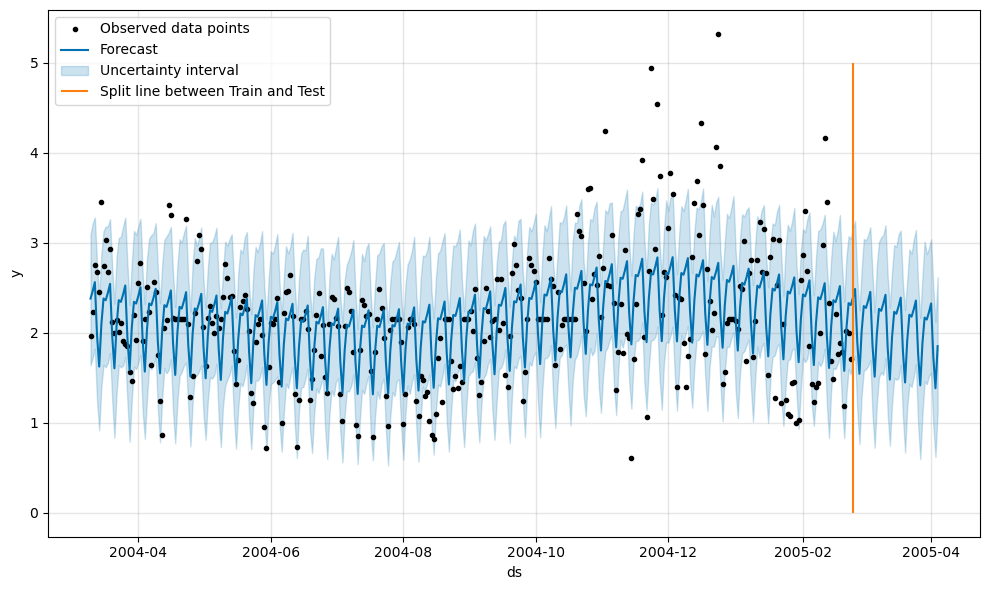

In [54]:
plt.figure(figsize=(20,8))
fig = model.plot(results)
plt.vlines(test_df['ds'].iloc[0], 0, 5, color='tab:orange', label='Split line between Train and Test')
plt.legend()
plt.show()

In [55]:
fig = plot_components_plotly(model, results)
fig.update_layout(title='Trend, yearly seasonality and weekly seasonality')

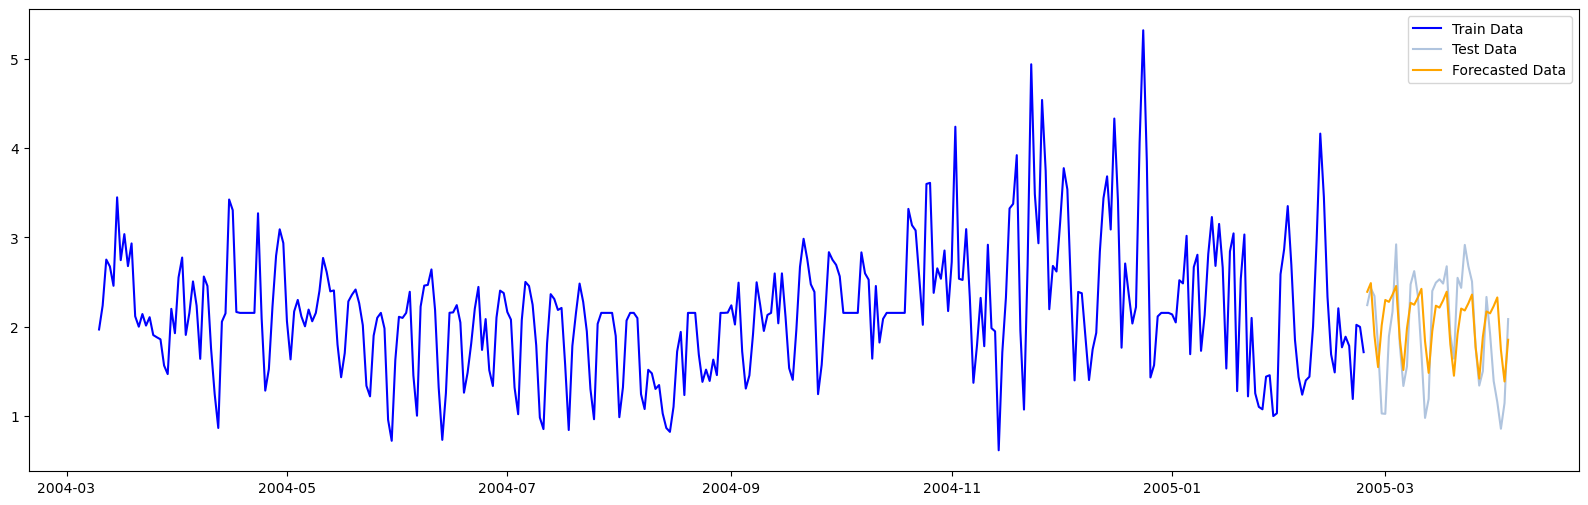

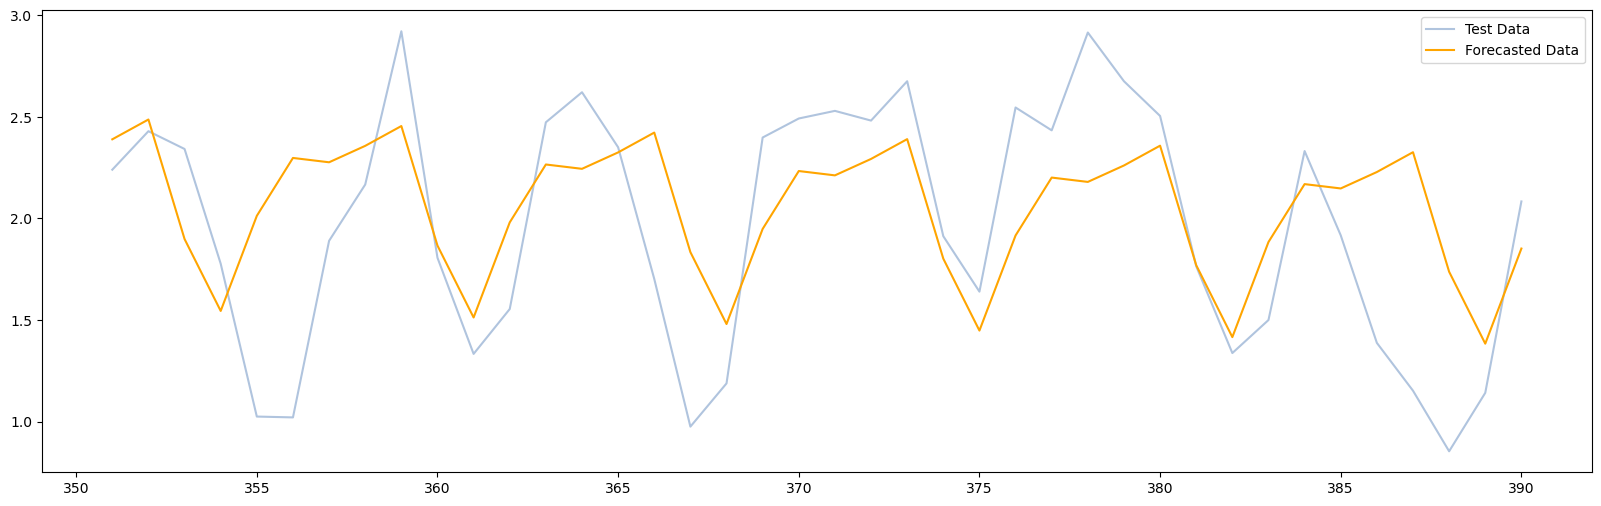

In [56]:
x_train = train_df['ds']
y_train = train_df['y']

x_test = test_df['ds']
y_test = test_df['y']

x_pred = df_grp['ds'][-len(x_test):]
y_pred = results['yhat'][-len(y_test):]

plt.figure(figsize=(20,6))
plt.plot(x_train, y_train, color='blue', label='Train Data')
plt.plot(x_test, y_test, color='lightsteelblue', label='Test Data')
plt.plot(x_pred, y_pred, color='orange', label='Forecasted Data')
plt.legend()
plt.show()

plt.figure(figsize=(20,6))
plt.plot(y_test, color='lightsteelblue', label='Test Data')
plt.plot(y_pred, color='orange', label='Forecasted Data')
plt.legend()
plt.show()

---
## Grid search over different (p, d, q) values for a ARIMA
### Without exogenous variables (for comparison only)


In [57]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order
    model = ARIMA(train_df_endog, 
                    exog=None, 
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 7),
                    trend=None,
                    enforce_stationarity=False,
                    enforce_invertibility=False, 
                    freq='1D')
    
    results = model.fit()
    results = results.forecast(steps=len(test_df_endog))
   
    mape = mean_absolute_percentage_error(test_df_endog, results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


(p, d, q) order: (0, 0, 0), with MAPE = 40.24%
(p, d, q) order: (0, 0, 1), with MAPE = 40.41%
(p, d, q) order: (0, 0, 2), with MAPE = 40.64%
(p, d, q) order: (0, 1, 0), with MAPE = 33.28%
(p, d, q) order: (0, 1, 1), with MAPE = 33.55%
(p, d, q) order: (0, 1, 2), with MAPE = 35.89%
(p, d, q) order: (0, 2, 0), with MAPE = 349.71%
(p, d, q) order: (0, 2, 1), with MAPE = 33.16%
(p, d, q) order: (0, 2, 2), with MAPE = 33.15%
(p, d, q) order: (1, 0, 0), with MAPE = 40.53%
(p, d, q) order: (1, 0, 1), with MAPE = 40.65%
(p, d, q) order: (1, 0, 2), with MAPE = 38.02%
(p, d, q) order: (1, 1, 0), with MAPE = 33.33%
(p, d, q) order: (1, 1, 1), with MAPE = 37.05%
(p, d, q) order: (1, 1, 2), with MAPE = 36.53%
(p, d, q) order: (1, 2, 0), with MAPE = 247.85%
(p, d, q) order: (1, 2, 1), with MAPE = 33.12%
(p, d, q) order: (1, 2, 2), with MAPE = 33.09%
(p, d, q) order: (2, 0, 0), with MAPE = 40.63%
(p, d, q) order: (2, 0, 1), with MAPE = 40.59%
(p, d, q) order: (2, 0, 2), with MAPE = 37.8%
(p, d, q) or

In [58]:
model = ARIMA(train_df_endog,                                         # endogenous variable
                exog=None,                                            # exogenous variables
                order= (best_order[0], best_order[1], best_order[2]), # best parameters for the model
                seasonal_order=(0, 0, 0, 7),                          # seasonal component showing non-seasonal behavior
                trend=None,
                enforce_stationarity=False,                           # handling non-stationary data     
                enforce_invertibility=False, 
                freq='1D')

results = model.fit()
results = results.forecast(steps = len(test_df_endog))

In [59]:
y_test = test_df_endog
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for ARIMA model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2))
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for ARIMA model:
--------------------------------------
MAE:    0.62
RMSE:   0.73
R2:     -38.49
MAPE:   32.83 %


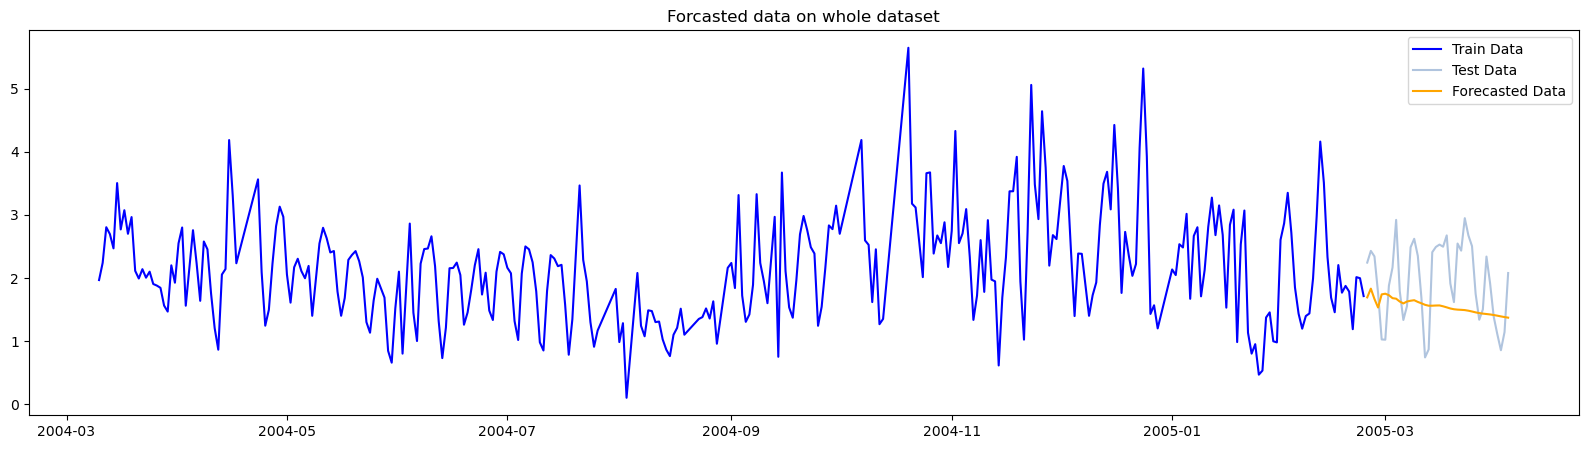

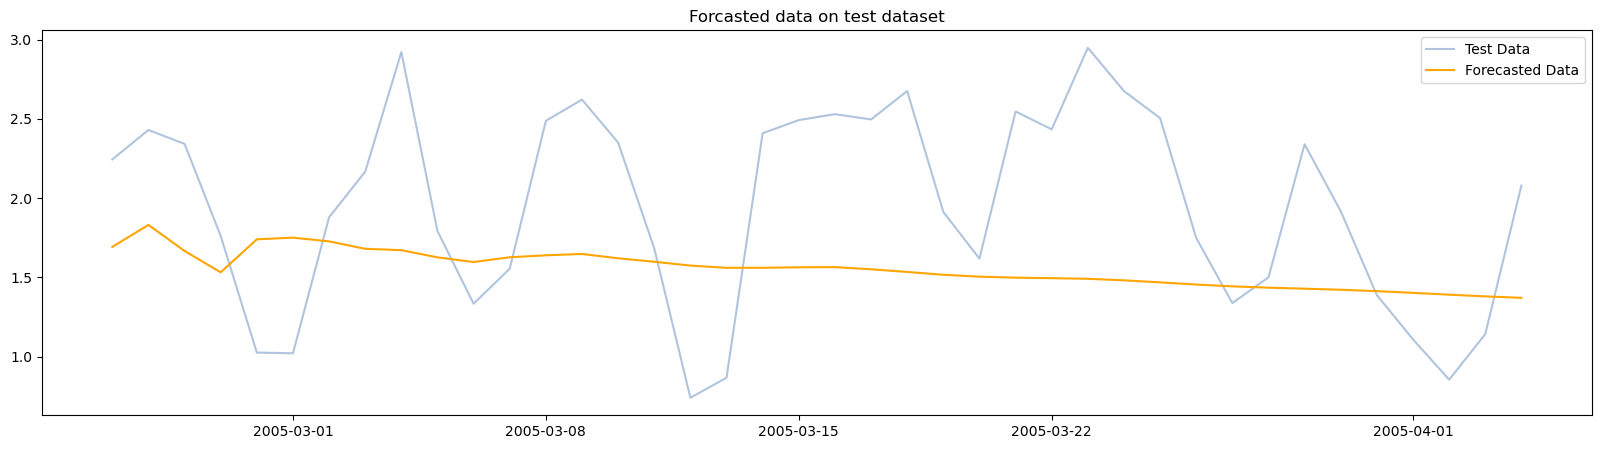

In [60]:
Train = train_df_endog
Test = test_df_endog
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset')
plt.legend()
plt.show()

---
# RESULTS

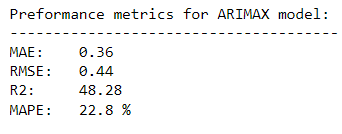
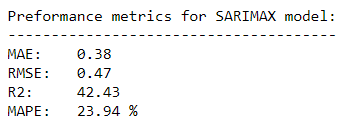
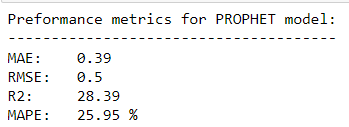
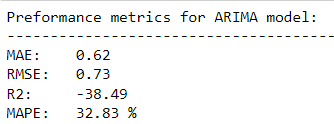


# CONCLUSION
All of the models demonstrated GOOD forecasting performance on the test dataset, as evidenced by both visual representation of the predictions and the comprehensive evaluation metrics used.     
* ARIMA model was made just for comparson with ARIMAX and as expected this model preformed the worst of all. 
* ARIMAX i SARIMAX perform the same if seasonal parameter was 0 or 7 days.
